<img src="./logo.png">

ref: https://dacon.io/competitions/open/235610/overview/description
<pre>
index 구분자
quality 품질
fixed acidity 산도
volatile acidity 휘발성산
citric acid 시트르산
residual sugar 잔당 : 발효 후 와인 속에 남아있는 당분
chlorides 염화물
free sulfur dioxide 독립 이산화황
total sulfur dioxide 총 이산화황
density 밀도
pH 수소이온농도
sulphates 황산염
alcohol 도수
type 종류


* ref : https://labelyourdata.com/articles/machine-learning-for-wine-quality-prediction
* ref : https://www.kaggle.com/code/anupamujawane/feature-selection-beginner-s-guide/notebook
* ref  :https://github.com/MzSusann/Red-Wine-Quality-Prediction/blob/master/Red%20Wine%20Quality%20Prediction.ipynb
* https://www.tensorflow.org/datasets/catalog/wine_quality
* https://heytech.tistory.com/150


In [ ]:
# # 코랩 catboost optuna 설치 #####################
# ! pip install catboost
# ! pip install optuna


# ! pip install xgboost
# ! pip install lightgbm


In [ ]:
from __future__ import print_function
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


#------------------------------------------------------------------ 학습데이터셋
from sklearn.model_selection import train_test_split

#------------------------------------------------------------------ 분류모델
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC, NuSVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier,  AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 
from catboost import CatBoostClassifier


#------------------------------------------------------------------ 증강학습
from sklearn.model_selection import StratifiedKFold,cross_val_score,GridSearchCV
from imblearn.over_sampling import SMOTE

#------------------------------------------------------------------ 스케일링
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler


#------------------------------------------------------------------ 평가관련
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.metrics import plot_roc_curve
# plot_roc_curve(model, X, y)
# plt.show()
from sklearn.metrics import auc
# auc(fpr, tpr)
from sklearn.preprocessing import Binarizer
# bb = Binarizer(threshold=1.1)                     
# print(bb.fit_transform(temp))

#------------------------------------------------------------------ 튜닝관련
import optuna
import sklearn.model_selection


import warnings
warnings.filterwarnings(action='ignore')
sns.set()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls /content/drive/MyDrive/colab/wine/dataset

sample_submission.csv  test.csv  train.csv


# Data Load

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/colab/wine/dataset/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/colab/wine/dataset/test.csv")
submit_df = pd.read_csv("/content/drive/MyDrive/colab/wine/dataset/sample_submission.csv")

In [ ]:
train_df.shape, test_df.shape

((5497, 14), (1000, 13))

In [ ]:
train_df.drop('index', axis=1, inplace=True)
test_df.drop('index', axis=1, inplace=True)

In [ ]:
train_df.duplicated().sum(),test_df.duplicated().sum()

(858, 36)

In [ ]:
train_df[train_df.duplicated()].describe()

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,5.945221,7.210664,0.314796,0.318974,7.328497,0.052906,32.849068,124.021562,0.995434,3.188298,0.518030,10.231981
std,0.834234,1.208133,0.142624,0.135192,5.480415,0.026275,16.971653,53.985486,0.003095,0.159245,0.146424,1.190921
min,4.000000,4.900000,0.080000,0.000000,0.600000,0.012000,1.000000,6.000000,0.987940,2.790000,0.270000,8.600000
25%,5.000000,6.500000,0.220000,0.250000,2.125000,0.038000,20.000000,92.000000,0.992915,3.080000,0.420000,9.200000
50%,6.000000,7.000000,0.280000,0.300000,6.350000,0.048000,32.000000,129.000000,0.995690,3.180000,0.490000,9.900000
75%,6.000000,7.500000,0.360000,0.380000,12.075000,0.058000,44.000000,162.375000,0.997900,3.290000,0.580000,11.000000
max,8.000000,15.500000,0.965000,0.910000,31.600000,0.415000,108.000000,253.000000,1.010300,3.720000,1.950000,14.000000


In [ ]:
train_df.nunique()

quality                   7
fixed acidity           106
volatile acidity        179
citric acid              89
residual sugar          309
chlorides               205
free sulfur dioxide     127
total sulfur dioxide    271
density                 970
pH                      107
sulphates               106
alcohol                 103
type                      2
dtype: int64

In [ ]:
pd.crosstab(train_df['type'], train_df['quality'])

quality,3,4,5,6,7,8,9
type,,,,,,,
red,9,41,571,535,169,13,0
white,17,145,1217,1881,755,139,5


6    2416
5    1788
7     924
4     186
8     152
3      26
9       5
Name: quality, dtype: int64


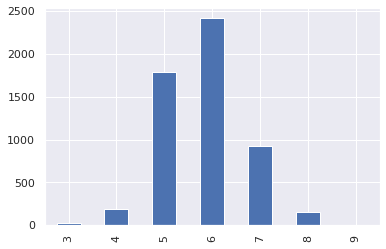

In [ ]:
print(  train_df['quality'].value_counts()  )
train_df['quality'].value_counts().sort_index().plot.bar()

white    4159
red      1338
Name: type, dtype: int64


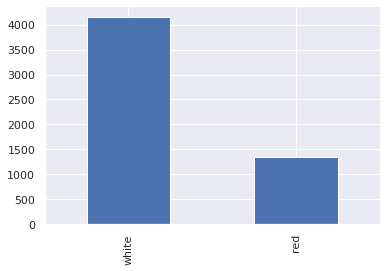

In [ ]:
print(train_df['type'].value_counts())
train_df['type'].value_counts().plot.bar()

white    739
red      261
Name: type, dtype: int64


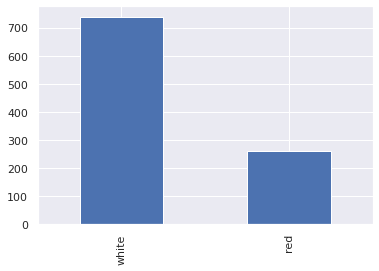

In [ ]:
print(test_df['type'].value_counts())
test_df['type'].value_counts().plot.bar()

In [ ]:
train_df.nunique()

quality                   7
fixed acidity           106
volatile acidity        179
citric acid              89
residual sugar          309
chlorides               205
free sulfur dioxide     127
total sulfur dioxide    271
density                 970
pH                      107
sulphates               106
alcohol                 103
type                      2
dtype: int64

# train test 분포도

In [ ]:
df = pd.concat([train_df, test_df], axis=0)
df['gubun'] = "train"                        #-----------train
df.iloc[-test_df.shape[0]:, -1] = "test"    #-----------test
df = df.reset_index(drop=True)
df.gubun.value_counts()

train    5497
test     1000
Name: gubun, dtype: int64

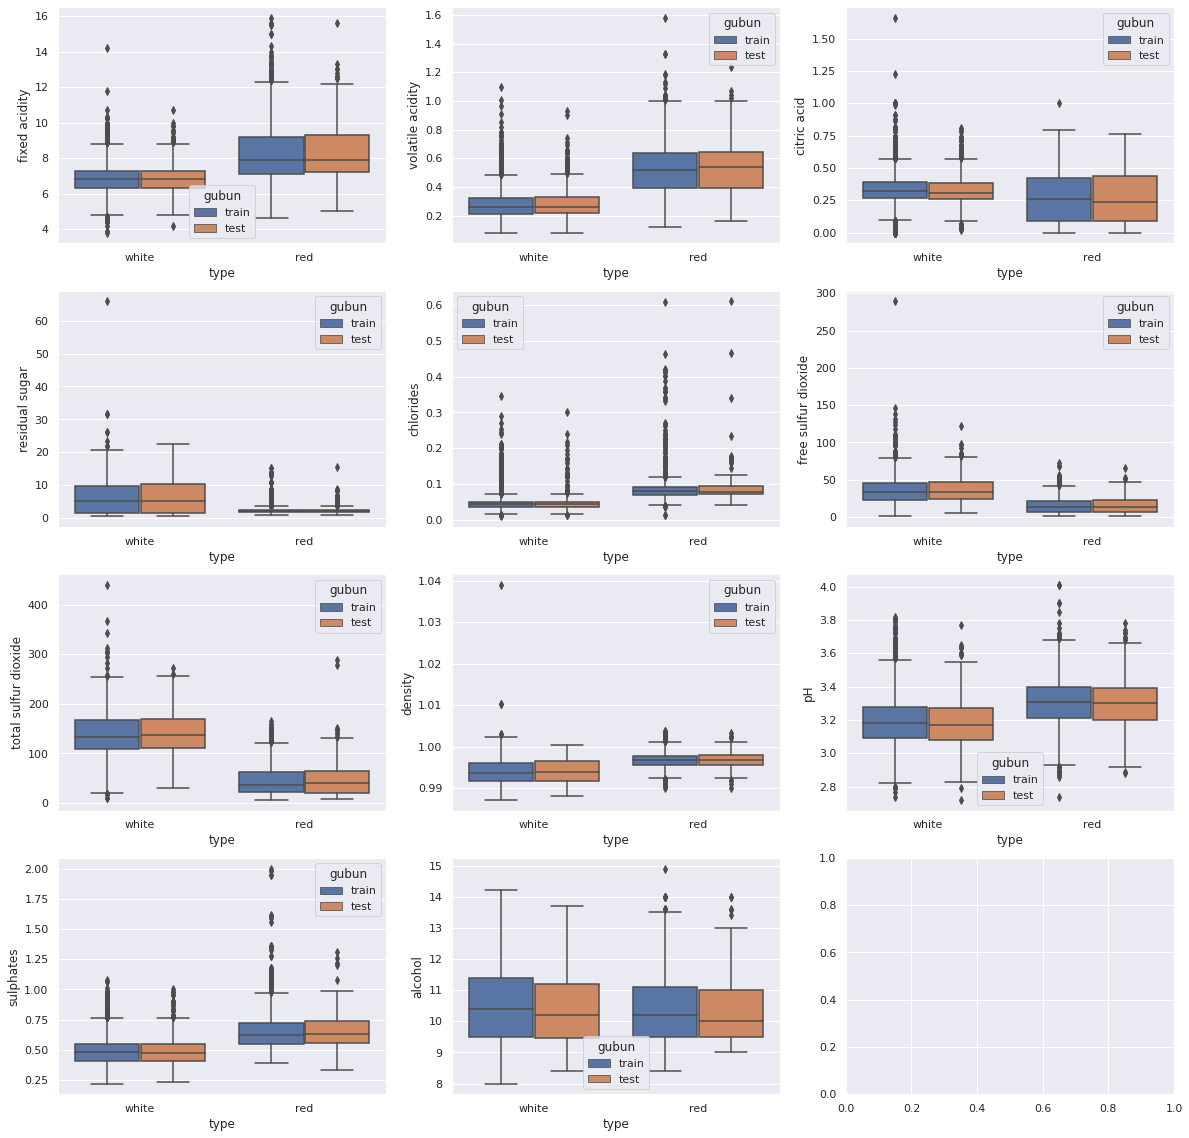

In [ ]:
cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide',  'density', 'pH', 'sulphates', 'alcohol']
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))

for i in range(len(cols)):
    col = cols[i]
    r = i//3
    c = i%3
    sns.boxplot(x="type",     y=col, data=df, hue='gubun', ax=axes[r][c])
plt.show()
plt.close()

# train : red white 분포도

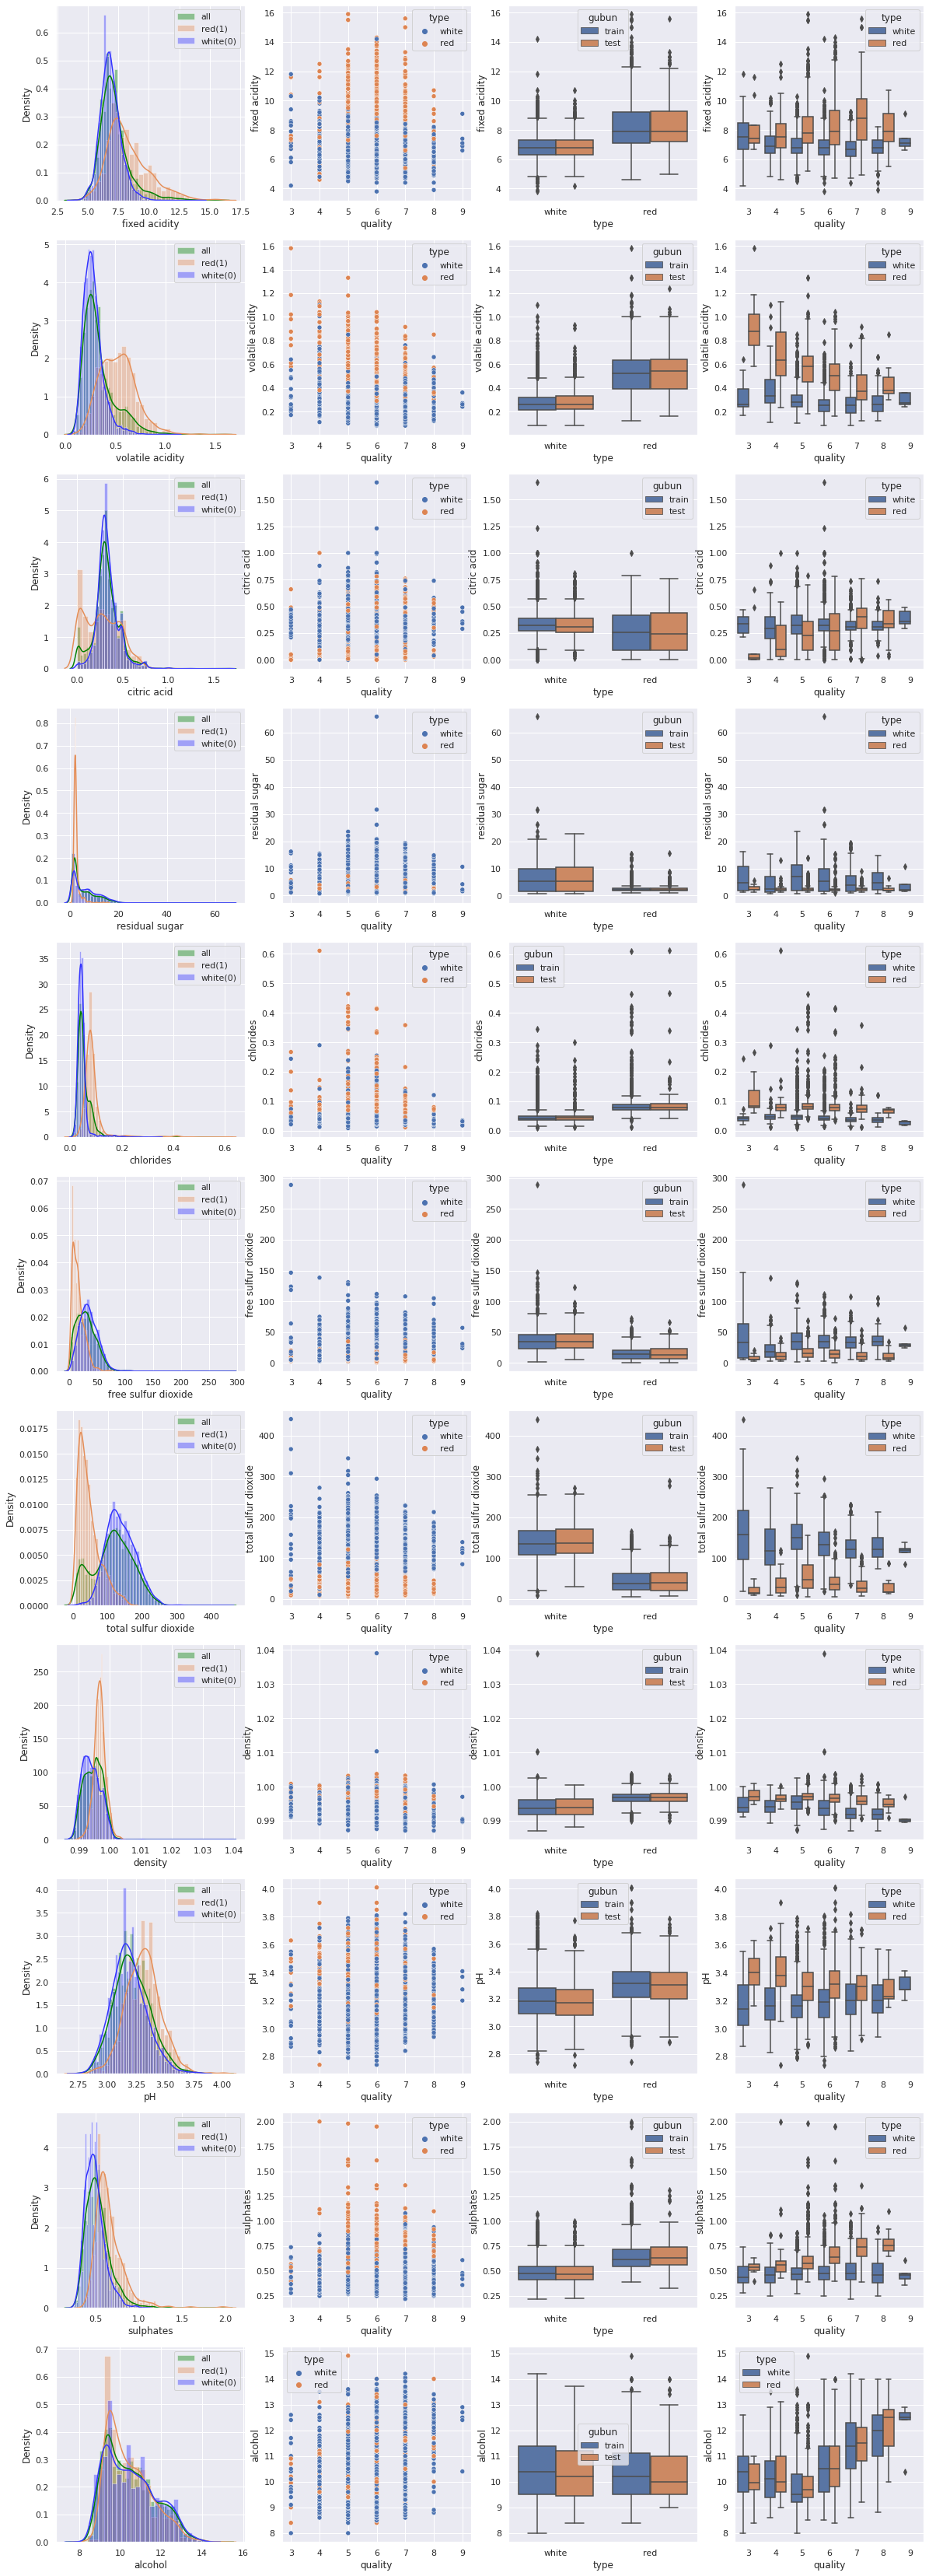

In [ ]:
cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide',  'density', 'pH', 'sulphates', 'alcohol']
fig, axes = plt.subplots(nrows=len(cols), ncols=4, figsize=(20, 60))

for r in range(len(cols)):
    col = cols[r]
    # plt.subplot(i+1,3,1)  
    sns.distplot(train_df[col]                      , color="green", fit_kws={"color":"green"},label="all" ,ax=axes[r][0])
    sns.distplot(train_df[train_df['type']=='red'][col] , color="#E48E58", fit_kws={"color":"#E48E58"},label="red(1)",ax=axes[r][0])
    sns.distplot(train_df[train_df['type']=='white'][col] , color="#3333FF", fit_kws={"color":"#3333FF"},label="white(0)",ax=axes[r][0])
    axes[r][0].legend()
    # plt.subplot(i+1,3,2)
    sns.scatterplot(x="quality", y=col,data=train_df, hue="type",ax=axes[r][1])
    # plt.subplot(i+1,3,3)
    #----------------------------------------------
    sns.boxplot(x="type",     y=col, data=df, hue='gubun', ax=axes[r][2])
    #----------------------------------------------
    sns.boxplot(x="quality", y=col, data=train_df, hue="type",ax=axes[r][3])
plt.show()
plt.close()

# oulier 선별

In [ ]:
outlier_idx = []
idx = train_df[ (train_df['type']=='white') & (train_df['fixed acidity']>12) ].index.values
outlier_idx.extend(idx)
idx = train_df[ (train_df['type']=='red')   & (train_df['volatile acidity']>1.5) ].index.values
outlier_idx.extend(idx)
idx = train_df[ (train_df['type']=='white') & (train_df['citric acid']>1.2) ].index.values
outlier_idx.extend(idx)
idx = train_df[ (train_df['type']=='red')   & (train_df['citric acid']>0.95) ].index.values
outlier_idx.extend(idx)
idx = train_df[ (train_df['type']=='white') & (train_df['residual sugar']>60) ].index.values
outlier_idx.extend(idx)
idx = train_df[ (train_df['type']=='red')   & (train_df['chlorides']>0.58) ].index.values
outlier_idx.extend(idx)
idx = train_df[ (train_df['type']=='white') & (train_df['free sulfur dioxide']>250) ].index.values
outlier_idx.extend(idx)
idx = train_df[ (train_df['type']=='white') & (train_df['total sulfur dioxide']>330) ].index.values
outlier_idx.extend(idx)
idx = train_df[ (train_df['type']=='white') & (train_df['density']>1.009) ].index.values
outlier_idx.extend(idx)
idx = train_df[ (train_df['type']=='red')   & (train_df['pH']>3.83) ].index.values
outlier_idx.extend(idx)
idx = train_df[ (train_df['type']=='red')   & (train_df['sulphates']>1.5) ].index.values
outlier_idx.extend(idx)
idx = train_df[ (train_df['type']=='red')   & (train_df['alcohol']>14.5) ].index.values
outlier_idx.extend(idx)

print(len(set(outlier_idx)))
print(outlier_idx)

24
[3074, 3014, 300, 5039, 584, 1220, 584, 5402, 2307, 2741, 5402, 1220, 4068, 4189, 214, 271, 493, 1124, 1652, 584, 2089, 2533, 3321, 3641, 4007, 4137, 4310, 2787]


In [ ]:
# before_remove = len(train)
# train_df[transform_data.columns] = np.where(abs(std_transform_data) > 3, np.nan, std_transform_data)
# train = train.dropna()
# print('Removed : -', before_remove - len(train))

# Quality 별 평균 분포도

In [ ]:
qualities = {}
for i in range(3,10):
    quality_description = train_df[train_df['quality'] == i].drop(['quality'], axis=1).describe()
    if i == 3:
        means = pd.DataFrame({i: quality_description.loc['mean']})
    else:
        mean = pd.DataFrame({i: quality_description.loc['mean']})
        means = pd.concat([means, mean], axis=1) # column을 기준으로 합치기

In [ ]:
means = means.T
means

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
3,7.860870,0.504348,0.275652,4.989130,0.076000,31.000000,101.847826,0.995676,3.240435,0.492609,10.180435,0.347826
4,7.273913,0.446495,0.277120,4.160598,0.056283,20.559783,105.222826,0.994710,3.227609,0.492011,10.168750,0.211957
5,7.322447,0.387587,0.307873,5.802497,0.064188,30.190797,120.345679,0.995839,3.213984,0.522132,9.845069,0.317621
6,7.164274,0.311300,0.322751,5.503246,0.053806,30.999792,115.286725,0.994499,3.218801,0.531040,10.602760,0.219725
7,7.123972,0.289724,0.332987,4.748918,0.045352,30.457251,108.178571,0.993122,3.228333,0.546786,11.383864,0.182900
8,6.839474,0.292730,0.330263,5.581579,0.041105,34.585526,119.421053,0.992544,3.216711,0.506184,11.680921,0.085526
9,7.420000,0.298000,0.386000,4.120000,0.027400,33.400000,116.000000,0.991460,3.308000,0.466000,12.180000,0.000000


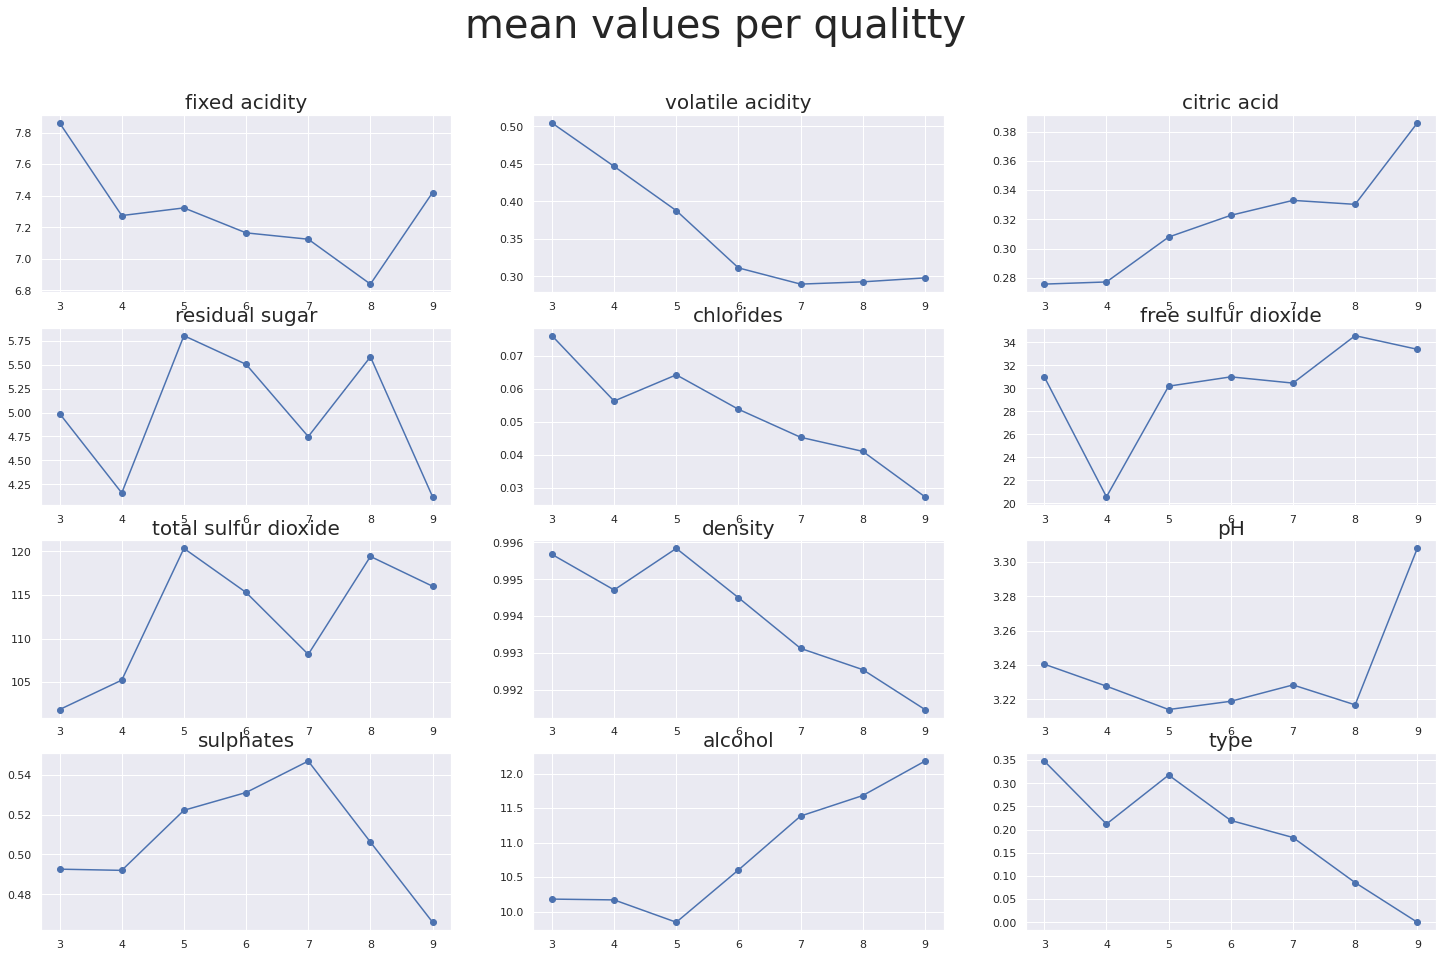

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(25, 15))

fig.suptitle('mean values per qualitty', fontsize=40)
for ax, col in zip(axes.flat, means.columns):
    ax.plot([3,4,5,6,7,8,9], means[col])
    ax.scatter([3,4,5,6,7,8,9], means[col])
    ax.set_title(col, fontsize=20)
plt.setp(axes, xticks=[3,4,5,6,7,8,9])
plt.show()

<pre>
------------------------------------------------------------------------------------
volatile acidity    : quality가 높아질수록 낮아진다
chlorides           : quality가 높아질수록 낮아진다(예외 : 4->5)
fixed acidity       : quality가 높아질수록 낮아진다(예외 : 4->5, 8->9)
density             : quality가 높아질수록 낮아진다(예외 : 4->5)
------------------------------------------------------------------------------------
citric acid         : quality가 높아질수록 높아진다
free sulfur dioxide : quality가 높아질수록 높아진다(예외 : 3->4, 8->9)
alcohol             : quality가 높아질수록 높아진다(예외 : 3->5)
sulphates           : quality가 높아질수록 높아진다(예외 : 7->9)
pH                  : quality가 높아질수록 높아진다(예외 : 3->5)
------------------------------------------------------------------------------------
residual sugar      : 규칙없음
total sulfur dioxide : 규칙없음

# type : object --> int 타입변환

In [ ]:
train_df['type'] = train_df['type'].map({"red":1,"white":0})
test_df['type']  = test_df['type'].map({"red":1,"white":0})

# 우선 점수부터 보자

* ref : https://www.kaggle.com/code/prashant111/catboost-classifier-in-python/notebook

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/08/13153401/Screen-Shot-2017-08-13-at-3.33.33-PM-768x443.png" width=600>

In [ ]:
train_red = train_df[train_df['type']==1]      # red
train_white = train_df[train_df['type']==0]    # white
test_red = test_df[test_df['type']==1]      # red
test_white = test_df[test_df['type']==0]    # white

In [ ]:
train_red.shape, train_white.shape, test_red.shape, test_white.shape

((1338, 13), (4159, 13), (261, 12), (739, 12))

In [ ]:
train_red_y   = train_red['quality']
train_red_X   = train_red.drop('quality', axis = 1)
train_white_y = train_white['quality']
train_white_X = train_white.drop('quality', axis = 1)

In [ ]:
train_red_y.shape, train_red_X.shape, train_white_y.shape, train_white_X.shape

((1338,), (1338, 12), (4159,), (4159, 12))

In [ ]:
models=[]
models.append(("RF",RandomForestClassifier()))
# models.append(("LGBM",LGBMClassifier()))
# # models.append(("LR",LogisticRegression()))
# models.append(("KNN",KNeighborsClassifier()))
# # models.append(("DT",DecisionTreeClassifier()))
# models.append(("SVM rbf",SVC()))
# models.append(("EXT",ExtraTreesClassifier()))
# models.append(("BG",BaggingClassifier()))
# models.append(("AB",AdaBoostClassifier()))
# models.append(("GB",GradientBoostingClassifier()))
# models.append(("XGB",XGBClassifier()))
scores=[]
names= []
for name, model in models:
    skfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1234)
    cv_result=cross_val_score(model, train_red_X, train_red_y, cv=skfold, scoring="accuracy")
    names.append(name)
    scores.append(cv_result)
    print(f"red model : {name}, {np.array(scores).mean():.4f}")

red model : RF, 0.6756


In [ ]:
models=[]
models.append(("RF",RandomForestClassifier()))
scores=[]
names= []
for name, model in models:
    skfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1234)
    cv_result=cross_val_score(model, train_white_X, train_white_y, cv=skfold, scoring="accuracy")
    names.append(name)
    scores.append(cv_result)
    print(f"white model : {name}, {np.array(scores).mean():.4f}")

white model : RF, 0.6699


# outlier 제거 + Scaling 후 점수

## outlier 제거

In [ ]:
print(train_df.shape)
train_df.drop(outlier_idx, axis=0, inplace=True)
train_df = train_df.reset_index(drop=True)
print(train_df.shape)

(5497, 13)
(5473, 13)


In [ ]:
train_df.columns

Index(['quality', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'type'],
      dtype='object')

In [ ]:
cols = ['fixed acidity', 'volatile acidity', 'citric acid','residual sugar', 'chlorides', 'free sulfur dioxide','total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
X = train_df.drop('quality', axis = 1)
y = train_df['quality']
sc = StandardScaler()
X_scaler = sc.fit_transform(X[cols])
test_scaler = sc.transform(test_df[cols])
X.shape, y.shape

((5473, 12), (5473,))

In [ ]:
train_scaler_df = pd.DataFrame(X_scaler, columns=cols)
train_scaler_df['type'] = X['type']
train_scaler_df['quality'] = y
train_scaler_df.tail()
# scaler_df.shape

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
5468,0.385895,-1.156517,-0.196999,-0.885030,-0.795713,-1.176279,-0.920411,-0.495862,0.822121,-0.979448,-0.338160,0,5
5469,-0.709502,-0.971301,0.292540,-0.906476,-0.645909,-0.253507,-0.079682,-1.332541,-0.372573,-0.131287,0.417132,0,6
5470,0.464138,-1.156517,0.152672,-0.927921,-0.615949,0.034859,-0.401663,-1.257716,-0.938481,1.352994,0.668896,0,7
5471,-0.474774,0.448684,-0.057130,-0.820695,-0.406224,-0.714893,-0.258560,-0.921004,-0.561209,-0.838087,-0.002474,0,5
5472,-0.161804,0.078253,-1.036207,-0.927921,-0.196499,-1.349298,0.063421,-0.574088,-0.561209,-1.191488,-0.673845,0,6


In [ ]:
test_scaler_df = pd.DataFrame(test_scaler, columns=cols)
test_scaler_df['type'] = test_df['type']
test_scaler_df.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
995,-0.083561,1.559977,-2.085218,-0.670578,0.792204,-0.368854,-0.383775,0.946220,2.079694,0.010073,-0.673845,1
996,1.168322,-1.156517,-0.127065,-0.820695,-0.286381,-0.080487,0.260188,-0.155748,0.004699,-1.050128,-0.589924,0
997,1.246565,1.992146,-0.406801,-0.799250,0.552518,-1.522318,-1.653814,0.830581,-0.435452,1.494354,-1.093452,1
998,-0.161804,0.510423,-0.896339,-0.670578,0.462636,-0.714893,-1.421272,0.034715,1.073636,0.222113,0.333211,1
999,1.011837,-0.786086,-0.406801,0.819862,-0.645909,2.457134,0.474842,-0.053714,-1.064238,-1.120808,0.752818,0


## scaling 후 점수ㅡ
* train_scaler_df
* test_scaler_df

In [ ]:
train_red = train_scaler_df[train_scaler_df['type']==1]      # red
train_white = train_scaler_df[train_scaler_df['type']==0]    # white
test_red = test_scaler_df[test_scaler_df['type']==1]      # red
test_white = test_scaler_df[test_scaler_df['type']==0]    # white

In [ ]:
train_red.shape, train_white.shape, test_red.shape, test_white.shape

((1323, 13), (4150, 13), (261, 12), (739, 12))

In [ ]:
train_red_y   = train_red['quality']
train_red_X   = train_red.drop('quality', axis = 1)
train_white_y = train_white['quality']
train_white_X = train_white.drop('quality', axis = 1)

In [ ]:
train_red_y.shape, train_red_X.shape, train_white_y.shape, train_white_X.shape

((1323,), (1323, 12), (4150,), (4150, 12))

In [ ]:
red_model = RandomForestClassifier()
skfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1234)
scores=cross_val_score(red_model, train_red_X, train_red_y, cv=skfold, scoring="accuracy")
print(f"red model :  {np.array(scores).mean():.4f}")

red model :  0.6787


In [ ]:
white_model = RandomForestClassifier()
skfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1234)
scores=cross_val_score(white_model, train_white_X, train_white_y, cv=skfold, scoring="accuracy")
print(f"white model :  {np.array(scores).mean():.4f}")

white model :  0.6814


<pre> * red model   : RF, 0.6756  --> 0.6787
 * white model : RF, 0.6699  --> 0.6814

# RF Optuna 튜닝
* ref : https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args

## RandomForest()
<pre>
n_estimators : 모델에서 사용할 트리 갯수(학습시 생성할 트리 갯수)
criterion : 분할 품질을 측정하는 기능 (default : gini)
max_depth : 트리의 최대 깊이
min_samples_split : 내부 노드를 분할하는데 필요한 최소 샘플 수 (default : 2)
min_samples_leaf : 리프 노드에 있어야 할 최소 샘플 수 (default : 1)
min_weight_fraction_leaf : min_sample_leaf와 같지만 가중치가 부여된 샘플 수에서의 비율
max_features : 각 노드에서 분할에 사용할 특징의 최대 수
max_leaf_nodes : 리프 노드의 최대수
min_impurity_decrease : 최소 불순도
min_impurity_split : 나무 성장을 멈추기 위한 임계치
bootstrap : 부트스트랩(중복허용 샘플링) 사용 여부
oob_score : 일반화 정확도를 줄이기 위해 밖의 샘플 사용 여부
n_jobs :적합성과 예측성을 위해 병렬로 실행할 작업 수
random_state : 난수 seed 설정
verbose : 실행 과정 출력 여부
warm_start : 이전 호출의 솔루션을 재사용하여 합계에 더 많은 견적가를 추가
class_weight : 클래스 가중치

---------------------------------
optuna.trial.Trial.suggest_categorical()      : 리스트 범위 내에서 값을 선택한다.
optuna.trial.Trial.suggest_int()              : 범위 내에서 정수형 값을 선택한다.
optuna.trial.Trial.suggest_float()            : 범위 내에서 소수형 값을 선택한다.
optuna.trial.Trial.suggest_uniform()          : 범위 내에서 균일분포 값을 선택한다.
optuna.trial.Trial.suggest_discrete_uniform() : 범위 내에서 이산 균일분포 값을 선택한다.
optuna.trial.Trial.suggest_loguniform()       : 범위 내에서 로그 함수 값을 선택한다.

In [ ]:
def objectiveRF(trial,X, y):
    params = {
         "n_estimators"       : trial.suggest_int('n_estimators', 100, 500)
        , "max_depth"         : trial.suggest_int("max_depth", 2, 32, log=True)
        , "min_samples_split" : trial.suggest_int("min_samples_split", 2, 10)
        , "max_leaf_nodes"    : trial.suggest_int('max_leaf_nodes', 2, 1000)         
    }

    score = []
    model = RandomForestClassifier(**params)
    model.fit(X, y)    
    skfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1234)
    score = cross_val_score(model, X, y, cv=skfold, scoring="accuracy")  
    accuracy = score.mean()
    return accuracy


## red 튜닝

In [ ]:
study_red = optuna.create_study(direction="maximize")
study_red.optimize(lambda trial: objectiveRF(trial, train_red_X, train_red_y), n_trials=100) 

print('study.best_score:'        , study_red.best_trial.value)
print('Number of finished trials:', len(study_red.trials))
print('Best trial:'               , study_red.best_trial.params)
print('study.best_params:'        , study_red.best_params)

[I 2022-08-15 02:31:44,067] A new study created in memory with name: no-name-7c67db61-e23f-4afa-ac04-67f8ff3b6dc8
[I 2022-08-15 02:31:47,386] Trial 0 finished with value: 0.581986849628359 and parameters: {'n_estimators': 301, 'max_depth': 2, 'min_samples_split': 8, 'max_leaf_nodes': 545}. Best is trial 0 with value: 0.581986849628359.
[I 2022-08-15 02:31:49,992] Trial 1 finished with value: 0.6061806746712407 and parameters: {'n_estimators': 192, 'max_depth': 9, 'min_samples_split': 8, 'max_leaf_nodes': 15}. Best is trial 1 with value: 0.6061806746712407.
[I 2022-08-15 02:31:57,699] Trial 2 finished with value: 0.6817581475128645 and parameters: {'n_estimators': 340, 'max_depth': 16, 'min_samples_split': 4, 'max_leaf_nodes': 526}. Best is trial 2 with value: 0.6817581475128645.
[I 2022-08-15 02:32:02,829] Trial 3 finished with value: 0.6250600343053172 and parameters: {'n_estimators': 359, 'max_depth': 6, 'min_samples_split': 10, 'max_leaf_nodes': 507}. Best is trial 2 with value: 0.6

study.best_score: 0.6945997712978844
Number of finished trials: 100
Best trial: {'n_estimators': 481, 'max_depth': 17, 'min_samples_split': 2, 'max_leaf_nodes': 667}
study.best_params: {'n_estimators': 481, 'max_depth': 17, 'min_samples_split': 2, 'max_leaf_nodes': 667}


<pre> 
study.best_score: 0.6945997712978844
Number of finished trials: 100
Best trial: {'n_estimators': 481, 'max_depth': 17, 'min_samples_split': 2, 'max_leaf_nodes': 667}
study.best_params: {'n_estimators': 481, 'max_depth': 17, 'min_samples_split': 2, 'max_leaf_nodes': 667}


In [ ]:
train_red_X.shape, train_red_y.shape

((1323, 12), (1323,))

In [ ]:
test_red.shape

(261, 12)

In [ ]:
red_pred_df = test_red[['type']].copy()
red_pred_df

,type
1,1
6,1
15,1
19,1
20,1
...,...
987,1
988,1
995,1
997,1


In [ ]:
red_best_params = study_red.best_params
model = RandomForestClassifier(**red_best_params)
model.fit(train_red_X, train_red_y)
pred = model.predict(test_red)
red_pred_df["rf"] = pred
red_pred_df.head()

,type,rf
1,1,6
6,1,6
15,1,5
19,1,5
20,1,6


## white 튜닝 

In [ ]:
study_white = optuna.create_study(direction="maximize")
study_white.optimize(lambda trial: objectiveRF(trial, train_white_X, train_white_y), n_trials=100) 

print('study.best_score:'         , study_white.best_trial.value)
print('Number of finished trials:', len(study_white.trials))
print('Best trial:'               , study_white.best_trial.params)
print('study.best_params:'        , study_white.best_params)

[I 2022-08-15 02:45:37,930] A new study created in memory with name: no-name-ba1f49d7-9dd6-4e79-a1d9-763500c309f0
[I 2022-08-15 02:45:51,651] Trial 0 finished with value: 0.5821686746987952 and parameters: {'n_estimators': 485, 'max_depth': 7, 'min_samples_split': 4, 'max_leaf_nodes': 974}. Best is trial 0 with value: 0.5821686746987952.
[I 2022-08-15 02:45:54,709] Trial 1 finished with value: 0.5091566265060241 and parameters: {'n_estimators': 196, 'max_depth': 2, 'min_samples_split': 7, 'max_leaf_nodes': 445}. Best is trial 0 with value: 0.5821686746987952.
[I 2022-08-15 02:45:59,344] Trial 2 finished with value: 0.653012048192771 and parameters: {'n_estimators': 105, 'max_depth': 30, 'min_samples_split': 10, 'max_leaf_nodes': 933}. Best is trial 2 with value: 0.653012048192771.
[I 2022-08-15 02:46:16,129] Trial 3 finished with value: 0.5968674698795182 and parameters: {'n_estimators': 474, 'max_depth': 13, 'min_samples_split': 10, 'max_leaf_nodes': 94}. Best is trial 2 with value: 0

study.best_score: 0.6843373493975904
Number of finished trials: 100
Best trial: {'n_estimators': 412, 'max_depth': 22, 'min_samples_split': 3, 'max_leaf_nodes': 693}
study.best_params: {'n_estimators': 412, 'max_depth': 22, 'min_samples_split': 3, 'max_leaf_nodes': 693}


<pre>
study.best_score: 0.6867469879518071
Number of finished trials: 30
Best trial: {'n_estimators': 296, 'max_depth': 24, 'min_samples_split': 2, 'max_leaf_nodes': 760}
study.best_params: {'n_estimators': 296, 'max_depth': 24, 'min_samples_split': 2, 'max_leaf_nodes': 760}


-----------------------------

study.best_score: 0.6848192771084337
Number of finished trials: 100
Best trial: {'n_estimators': 332, 'max_depth': 28, 'min_samples_split': 4, 'max_leaf_nodes': 894}
study.best_params: {'n_estimators': 332, 'max_depth': 28, 'min_samples_split': 4, 'max_leaf_nodes': 894}

------------------------------

study.best_score: 0.6843373493975904
Number of finished trials: 100
Best trial: {'n_estimators': 412, 'max_depth': 22, 'min_samples_split': 3, 'max_leaf_nodes': 693}
study.best_params: {'n_estimators': 412, 'max_depth': 22, 'min_samples_split': 3, 'max_leaf_nodes': 693}



In [ ]:
train_white_X.shape, train_white_y.shape

((4150, 12), (4150,))

In [ ]:
test_white.shape

(739, 12)

In [ ]:
white_pred_df = test_white[['type']].copy()
white_pred_df.head()

,type
0,0
2,0
3,0
4,0
5,0


In [ ]:
white_best_params = study_white.best_params
wmodel = RandomForestClassifier(**white_best_params)
wmodel.fit(train_white_X, train_white_y)
pred = wmodel.predict(test_white)
white_pred_df["rf"] = pred
white_pred_df.head()

,type,rf
0,0,5
2,0,6
3,0,5
4,0,6
5,0,6


# submit__rank.51

In [ ]:
red_pred_df['rf'].head()

1     6
6     6
15    5
19    5
20    6
Name: rf, dtype: int64

In [ ]:
white_pred_df['rf'].head()

0    5
2    6
3    5
4    6
5    6
Name: rf, dtype: int64

In [ ]:
pred = pd.concat( [red_pred_df['rf'], white_pred_df['rf']], axis=0)
pred = pred.sort_index()
pred.head()

0    5
1    6
2    6
3    5
4    6
Name: rf, dtype: int64

In [ ]:
submit_df['quality'] = pred
submit_df.to_csv('01_red_white_1.csv', index=False)
submit_df.head(10)

,index,quality
0,0,5
1,1,6
2,2,6
3,3,5
4,4,6
5,5,6
6,6,6
7,7,6
8,8,6
9,9,7


In [ ]:
submit_df['quality'].value_counts()

6    508
5    353
7    123
8     11
4      5
Name: quality, dtype: int64

<!-- 6    509
5    347
7    127
8     11
4      6 -->

In [ ]:
6    509
5    347
7    127
8     11
4      6

# LightGBM() Optuna 튜닝
* ref : https://www.kaggle.com/code/bjoernholzhauer/lightgbm-tuning-with-optuna

In [ ]:
import lightgbm as lgb

def cal_acc(true, pred):
    return np.mean(true==pred)

def objectiveLGBM(trial,X, y):
    params = {
        "objective"         : "multiclass",
        "metric"            : "multi_logloss",
        "verbosity"         : -1,
        "boosting_type"     : "gbdt",
        "lambda_l1"         : trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2"         : trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves"        : trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction"  : trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction"  : trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq"      : trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples" : trial.suggest_int("min_child_samples", 5, 100),
        "feature_pre_filter": False
    }
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=1234)
 
    score = []
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    print("-----------------------------------------------------", pred[:5])
    # pred_labels = []
    # for i in range(0,len(pred)):
    #     pred_labels.append(np.argmax(pred[i]))
    # score.append(cal_acc(y_val, pred_labels))
    score.append(cal_acc(y_val, pred))
    score = np.mean(score)
    return score

## red 튜닝

In [ ]:
study_red_lgbm = optuna.create_study(direction="maximize")
study_red_lgbm.optimize(lambda trial: objectiveLGBM(trial, train_red_X, train_red_y), n_trials=100) 

print('study.best_score:'        , study_red_lgbm.best_trial.value)
print('Number of finished trials:', len(study_red_lgbm.trials))
print('Best trial:'               , study_red_lgbm.best_trial.params)
print('study.best_params:'        , study_red_lgbm.best_params)

[I 2022-08-15 03:16:41,526] A new study created in memory with name: no-name-2b9f459a-1b3f-449e-8352-9e2236fe3492
[I 2022-08-15 03:16:41,795] Trial 0 finished with value: 0.6 and parameters: {'lambda_l1': 0.0012666239647151033, 'lambda_l2': 1.908433588172676e-06, 'num_leaves': 115, 'feature_fraction': 0.40238280866203163, 'bagging_fraction': 0.9822748333528628, 'bagging_freq': 4, 'min_child_samples': 36}. Best is trial 0 with value: 0.6.


----------------------------------------------------- [6 5 5 5 5]


[I 2022-08-15 03:16:42,008] Trial 1 finished with value: 0.5962264150943396 and parameters: {'lambda_l1': 5.59881776690707e-05, 'lambda_l2': 0.007543427751158374, 'num_leaves': 170, 'feature_fraction': 0.9561424816171686, 'bagging_fraction': 0.513205652548924, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 0 with value: 0.6.
[I 2022-08-15 03:16:42,185] Trial 2 finished with value: 0.5924528301886792 and parameters: {'lambda_l1': 0.00026935370610788197, 'lambda_l2': 2.5797700000581202e-05, 'num_leaves': 52, 'feature_fraction': 0.8040867839549495, 'bagging_fraction': 0.8545519494092628, 'bagging_freq': 1, 'min_child_samples': 96}. Best is trial 0 with value: 0.6.


----------------------------------------------------- [7 6 5 5 7]
----------------------------------------------------- [7 6 5 5 7]


[I 2022-08-15 03:16:42,432] Trial 3 finished with value: 0.6150943396226415 and parameters: {'lambda_l1': 1.1444017634094567e-08, 'lambda_l2': 0.04561771896391716, 'num_leaves': 237, 'feature_fraction': 0.8044378212204333, 'bagging_fraction': 0.4204915452163106, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 3 with value: 0.6150943396226415.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:42,666] Trial 4 finished with value: 0.6188679245283019 and parameters: {'lambda_l1': 2.223152328101957e-05, 'lambda_l2': 1.8393840388720126e-08, 'num_leaves': 81, 'feature_fraction': 0.8303722141936611, 'bagging_fraction': 0.5516760632469344, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 4 with value: 0.6188679245283019.


----------------------------------------------------- [6 6 5 5 7]


[I 2022-08-15 03:16:42,985] Trial 5 finished with value: 0.6188679245283019 and parameters: {'lambda_l1': 8.665258041927518e-08, 'lambda_l2': 0.00013153597012853578, 'num_leaves': 174, 'feature_fraction': 0.8292929191877695, 'bagging_fraction': 0.5451203890437446, 'bagging_freq': 5, 'min_child_samples': 20}. Best is trial 4 with value: 0.6188679245283019.


----------------------------------------------------- [6 6 5 5 5]
----------------------------------------------------- [7 6 5 5 7]


[I 2022-08-15 03:16:43,181] Trial 6 finished with value: 0.5962264150943396 and parameters: {'lambda_l1': 4.870941762721722, 'lambda_l2': 0.47169630125418516, 'num_leaves': 223, 'feature_fraction': 0.8270609746369595, 'bagging_fraction': 0.7912239200104925, 'bagging_freq': 3, 'min_child_samples': 22}. Best is trial 4 with value: 0.6188679245283019.
[I 2022-08-15 03:16:43,342] Trial 7 finished with value: 0.5849056603773585 and parameters: {'lambda_l1': 0.8887871141713802, 'lambda_l2': 1.3349179554285194e-06, 'num_leaves': 138, 'feature_fraction': 0.521538979635895, 'bagging_fraction': 0.8920763430248739, 'bagging_freq': 3, 'min_child_samples': 91}. Best is trial 4 with value: 0.6188679245283019.


----------------------------------------------------- [7 6 5 5 7]


[I 2022-08-15 03:16:43,635] Trial 8 finished with value: 0.630188679245283 and parameters: {'lambda_l1': 5.1403850931028753e-05, 'lambda_l2': 0.002285278153030604, 'num_leaves': 65, 'feature_fraction': 0.8967215979218877, 'bagging_fraction': 0.8132852323100369, 'bagging_freq': 4, 'min_child_samples': 31}. Best is trial 8 with value: 0.630188679245283.
[I 2022-08-15 03:16:43,797] Trial 9 finished with value: 0.6 and parameters: {'lambda_l1': 6.338047421418545e-05, 'lambda_l2': 1.1629876238593051e-07, 'num_leaves': 142, 'feature_fraction': 0.468563402666906, 'bagging_fraction': 0.4204613709244058, 'bagging_freq': 2, 'min_child_samples': 31}. Best is trial 8 with value: 0.630188679245283.


----------------------------------------------------- [6 6 5 5 5]
----------------------------------------------------- [7 6 5 5 7]


[I 2022-08-15 03:16:43,973] Trial 10 finished with value: 0.5924528301886792 and parameters: {'lambda_l1': 0.06551721107292559, 'lambda_l2': 2.6870684862223384, 'num_leaves': 5, 'feature_fraction': 0.6203299764258303, 'bagging_fraction': 0.6677466598857822, 'bagging_freq': 7, 'min_child_samples': 61}. Best is trial 8 with value: 0.630188679245283.


----------------------------------------------------- [7 6 5 5 5]


[I 2022-08-15 03:16:44,216] Trial 11 finished with value: 0.5886792452830188 and parameters: {'lambda_l1': 2.1257236597563163e-06, 'lambda_l2': 0.0014283715015541024, 'num_leaves': 76, 'feature_fraction': 0.9870482210047844, 'bagging_fraction': 0.6731264510040085, 'bagging_freq': 5, 'min_child_samples': 43}. Best is trial 8 with value: 0.630188679245283.
[I 2022-08-15 03:16:44,402] Trial 12 finished with value: 0.5849056603773585 and parameters: {'lambda_l1': 3.0539924427025175e-06, 'lambda_l2': 3.230601979243076e-08, 'num_leaves': 61, 'feature_fraction': 0.6988843219205203, 'bagging_fraction': 0.586359689527179, 'bagging_freq': 4, 'min_child_samples': 65}. Best is trial 8 with value: 0.630188679245283.


----------------------------------------------------- [7 6 5 5 7]
----------------------------------------------------- [6 6 5 5 7]


[I 2022-08-15 03:16:44,702] Trial 13 finished with value: 0.6377358490566037 and parameters: {'lambda_l1': 0.006711419333604896, 'lambda_l2': 2.223818343703226e-05, 'num_leaves': 13, 'feature_fraction': 0.897934233849765, 'bagging_fraction': 0.7360110605757081, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 13 with value: 0.6377358490566037.
[I 2022-08-15 03:16:44,806] Trial 14 finished with value: 0.6 and parameters: {'lambda_l1': 0.008232759234476467, 'lambda_l2': 4.914476867096454e-05, 'num_leaves': 2, 'feature_fraction': 0.8994322406957883, 'bagging_fraction': 0.7698408575005663, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 13 with value: 0.6377358490566037.


----------------------------------------------------- [6 6 5 5 5]
----------------------------------------------------- [7 5 5 5 7]


[I 2022-08-15 03:16:45,344] Trial 15 finished with value: 0.6452830188679245 and parameters: {'lambda_l1': 0.017724265533674236, 'lambda_l2': 0.0035929294303943295, 'num_leaves': 42, 'feature_fraction': 0.6971396464553634, 'bagging_fraction': 0.7493022257451032, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 15 with value: 0.6452830188679245.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:45,790] Trial 16 finished with value: 0.6490566037735849 and parameters: {'lambda_l1': 0.08032942670240986, 'lambda_l2': 0.05793857780067335, 'num_leaves': 32, 'feature_fraction': 0.6928746385783446, 'bagging_fraction': 0.7269841873527433, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 16 with value: 0.6490566037735849.
[I 2022-08-15 03:16:45,974] Trial 17 finished with value: 0.5924528301886792 and parameters: {'lambda_l1': 0.16252128394850857, 'lambda_l2': 0.06283250987889029, 'num_leaves': 34, 'feature_fraction': 0.6653147963908743, 'bagging_fraction': 0.6350588385975172, 'bagging_freq': 2, 'min_child_samples': 78}. Best is trial 16 with value: 0.6490566037735849.


----------------------------------------------------- [6 6 5 5 5]
----------------------------------------------------- [6 6 5 5 7]


[I 2022-08-15 03:16:46,401] Trial 18 finished with value: 0.630188679245283 and parameters: {'lambda_l1': 0.0511641684890492, 'lambda_l2': 6.292512274075235, 'num_leaves': 104, 'feature_fraction': 0.5887294964041014, 'bagging_fraction': 0.9450825325242225, 'bagging_freq': 2, 'min_child_samples': 14}. Best is trial 16 with value: 0.6490566037735849.
[I 2022-08-15 03:16:46,537] Trial 19 finished with value: 0.6264150943396226 and parameters: {'lambda_l1': 8.823041024121702, 'lambda_l2': 0.052194761726793604, 'num_leaves': 44, 'feature_fraction': 0.7634522442054421, 'bagging_fraction': 0.7185725062587673, 'bagging_freq': 2, 'min_child_samples': 43}. Best is trial 16 with value: 0.6490566037735849.


----------------------------------------------------- [6 6 5 5 5]
----------------------------------------------------- [7 6 5 5 5]


[I 2022-08-15 03:16:47,076] Trial 20 finished with value: 0.6490566037735849 and parameters: {'lambda_l1': 0.004280113860868224, 'lambda_l2': 0.5088413594583445, 'num_leaves': 95, 'feature_fraction': 0.7331411047754254, 'bagging_fraction': 0.86099092570457, 'bagging_freq': 1, 'min_child_samples': 12}. Best is trial 16 with value: 0.6490566037735849.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:47,584] Trial 21 finished with value: 0.6226415094339622 and parameters: {'lambda_l1': 0.0052253078613160465, 'lambda_l2': 0.49362814758474644, 'num_leaves': 93, 'feature_fraction': 0.7403879635545322, 'bagging_fraction': 0.8762441910480375, 'bagging_freq': 1, 'min_child_samples': 13}. Best is trial 16 with value: 0.6490566037735849.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:47,997] Trial 22 finished with value: 0.6490566037735849 and parameters: {'lambda_l1': 0.4414648377392528, 'lambda_l2': 0.4144586434586957, 'num_leaves': 28, 'feature_fraction': 0.6441370113854628, 'bagging_fraction': 0.8308232041947201, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 16 with value: 0.6490566037735849.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:48,309] Trial 23 finished with value: 0.6415094339622641 and parameters: {'lambda_l1': 0.5963371521535306, 'lambda_l2': 0.6421766781695503, 'num_leaves': 24, 'feature_fraction': 0.5962491379530188, 'bagging_fraction': 0.8199102058675469, 'bagging_freq': 1, 'min_child_samples': 18}. Best is trial 16 with value: 0.6490566037735849.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:48,715] Trial 24 finished with value: 0.6339622641509434 and parameters: {'lambda_l1': 0.6454743485981227, 'lambda_l2': 9.749842795836411, 'num_leaves': 27, 'feature_fraction': 0.638235728683049, 'bagging_fraction': 0.9504764958273275, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 16 with value: 0.6490566037735849.


----------------------------------------------------- [6 6 5 5 7]


[I 2022-08-15 03:16:49,019] Trial 25 finished with value: 0.6226415094339622 and parameters: {'lambda_l1': 0.001299354420165253, 'lambda_l2': 0.01695789511265626, 'num_leaves': 87, 'feature_fraction': 0.5553458171332979, 'bagging_fraction': 0.8975774847320539, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 16 with value: 0.6490566037735849.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:49,467] Trial 26 finished with value: 0.6415094339622641 and parameters: {'lambda_l1': 0.2519198011263963, 'lambda_l2': 0.18838555643308405, 'num_leaves': 122, 'feature_fraction': 0.7390336936716585, 'bagging_fraction': 0.8367113910240633, 'bagging_freq': 3, 'min_child_samples': 16}. Best is trial 16 with value: 0.6490566037735849.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:49,740] Trial 27 finished with value: 0.6226415094339622 and parameters: {'lambda_l1': 0.04462890923227917, 'lambda_l2': 1.9148868774299366, 'num_leaves': 173, 'feature_fraction': 0.6632017868275862, 'bagging_fraction': 0.9207065476229163, 'bagging_freq': 2, 'min_child_samples': 41}. Best is trial 16 with value: 0.6490566037735849.


----------------------------------------------------- [6 6 5 5 7]


[I 2022-08-15 03:16:50,009] Trial 28 finished with value: 0.6377358490566037 and parameters: {'lambda_l1': 2.2375682894772964, 'lambda_l2': 0.0009501659518094858, 'num_leaves': 65, 'feature_fraction': 0.5247301401571488, 'bagging_fraction': 0.7802251204085906, 'bagging_freq': 1, 'min_child_samples': 13}. Best is trial 16 with value: 0.6490566037735849.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:50,227] Trial 29 finished with value: 0.5962264150943396 and parameters: {'lambda_l1': 0.0011864602424310697, 'lambda_l2': 0.1533526227088849, 'num_leaves': 109, 'feature_fraction': 0.4157712573565431, 'bagging_fraction': 0.6954558883729294, 'bagging_freq': 5, 'min_child_samples': 51}. Best is trial 16 with value: 0.6490566037735849.


----------------------------------------------------- [6 6 5 5 7]


[I 2022-08-15 03:16:50,540] Trial 30 finished with value: 0.6377358490566037 and parameters: {'lambda_l1': 0.0012292849106221887, 'lambda_l2': 1.6510145531540497, 'num_leaves': 27, 'feature_fraction': 0.768688350135695, 'bagging_fraction': 0.9802620436867929, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial 16 with value: 0.6490566037735849.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:51,111] Trial 31 finished with value: 0.6339622641509434 and parameters: {'lambda_l1': 0.017997456057206793, 'lambda_l2': 0.010473913854972056, 'num_leaves': 45, 'feature_fraction': 0.7060864671182298, 'bagging_fraction': 0.7337580430641931, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 16 with value: 0.6490566037735849.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:51,603] Trial 32 finished with value: 0.6415094339622641 and parameters: {'lambda_l1': 0.17775486942620253, 'lambda_l2': 0.004614903837442464, 'num_leaves': 42, 'feature_fraction': 0.6881703571120273, 'bagging_fraction': 0.760847763406349, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 16 with value: 0.6490566037735849.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:51,932] Trial 33 finished with value: 0.6188679245283019 and parameters: {'lambda_l1': 0.023627056014581115, 'lambda_l2': 0.00045940957366552327, 'num_leaves': 21, 'feature_fraction': 0.6372725402051669, 'bagging_fraction': 0.8662238922792637, 'bagging_freq': 3, 'min_child_samples': 25}. Best is trial 16 with value: 0.6490566037735849.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:52,453] Trial 34 finished with value: 0.6452830188679245 and parameters: {'lambda_l1': 0.0002959059585951024, 'lambda_l2': 0.01172887437112384, 'num_leaves': 53, 'feature_fraction': 0.729930181455869, 'bagging_fraction': 0.6229320096995968, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 16 with value: 0.6490566037735849.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:52,893] Trial 35 finished with value: 0.6528301886792452 and parameters: {'lambda_l1': 0.002886172586143467, 'lambda_l2': 0.11567358414758068, 'num_leaves': 97, 'feature_fraction': 0.7824598214769873, 'bagging_fraction': 0.8341876181237847, 'bagging_freq': 1, 'min_child_samples': 17}. Best is trial 35 with value: 0.6528301886792452.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:53,285] Trial 36 finished with value: 0.6377358490566037 and parameters: {'lambda_l1': 0.0027162665530194603, 'lambda_l2': 0.12268048294038789, 'num_leaves': 199, 'feature_fraction': 0.7887871444202958, 'bagging_fraction': 0.8491412918944145, 'bagging_freq': 1, 'min_child_samples': 21}. Best is trial 35 with value: 0.6528301886792452.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:53,689] Trial 37 finished with value: 0.6339622641509434 and parameters: {'lambda_l1': 0.0005143790636570357, 'lambda_l2': 0.032893770294836325, 'num_leaves': 96, 'feature_fraction': 0.6643307176974556, 'bagging_fraction': 0.8044444920681605, 'bagging_freq': 1, 'min_child_samples': 18}. Best is trial 35 with value: 0.6528301886792452.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:53,945] Trial 38 finished with value: 0.6264150943396226 and parameters: {'lambda_l1': 0.08510505600667123, 'lambda_l2': 0.8118812321217491, 'num_leaves': 76, 'feature_fraction': 0.8465479562854434, 'bagging_fraction': 0.4845724644512006, 'bagging_freq': 1, 'min_child_samples': 24}. Best is trial 35 with value: 0.6528301886792452.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:54,224] Trial 39 finished with value: 0.6188679245283019 and parameters: {'lambda_l1': 3.2253035698113877, 'lambda_l2': 0.17961659576420108, 'num_leaves': 154, 'feature_fraction': 0.8005608497681062, 'bagging_fraction': 0.9121025450811773, 'bagging_freq': 3, 'min_child_samples': 29}. Best is trial 35 with value: 0.6528301886792452.


----------------------------------------------------- [7 6 5 5 7]


[I 2022-08-15 03:16:54,476] Trial 40 finished with value: 0.630188679245283 and parameters: {'lambda_l1': 1.5064099618094091, 'lambda_l2': 4.304288195864437, 'num_leaves': 115, 'feature_fraction': 0.8643423671781106, 'bagging_fraction': 0.8369526637017426, 'bagging_freq': 1, 'min_child_samples': 35}. Best is trial 35 with value: 0.6528301886792452.


----------------------------------------------------- [6 6 5 5 7]


[I 2022-08-15 03:16:54,907] Trial 41 finished with value: 0.6641509433962264 and parameters: {'lambda_l1': 0.00024171855869470007, 'lambda_l2': 0.011291845419876812, 'num_leaves': 57, 'feature_fraction': 0.7308116282485693, 'bagging_fraction': 0.5801752362183578, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 41 with value: 0.6641509433962264.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:55,221] Trial 42 finished with value: 0.660377358490566 and parameters: {'lambda_l1': 0.00011541679693474421, 'lambda_l2': 0.025561824838584442, 'num_leaves': 68, 'feature_fraction': 0.7648462206680271, 'bagging_fraction': 0.4702794637308146, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 41 with value: 0.6641509433962264.


----------------------------------------------------- [6 5 5 5 5]


[I 2022-08-15 03:16:55,525] Trial 43 finished with value: 0.6377358490566037 and parameters: {'lambda_l1': 0.00010474062660072083, 'lambda_l2': 0.30607053683741525, 'num_leaves': 256, 'feature_fraction': 0.7704904054371668, 'bagging_fraction': 0.4777557966633448, 'bagging_freq': 1, 'min_child_samples': 16}. Best is trial 41 with value: 0.6641509433962264.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:55,801] Trial 44 finished with value: 0.660377358490566 and parameters: {'lambda_l1': 1.1009955858443445e-05, 'lambda_l2': 0.01806391729527797, 'num_leaves': 74, 'feature_fraction': 0.7276833095693735, 'bagging_fraction': 0.4636996915768862, 'bagging_freq': 3, 'min_child_samples': 18}. Best is trial 41 with value: 0.6641509433962264.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:56,014] Trial 45 finished with value: 0.5962264150943396 and parameters: {'lambda_l1': 7.024907247958201e-06, 'lambda_l2': 0.02543476790694745, 'num_leaves': 71, 'feature_fraction': 0.8202267856764688, 'bagging_fraction': 0.45199928020160673, 'bagging_freq': 3, 'min_child_samples': 34}. Best is trial 41 with value: 0.6641509433962264.


----------------------------------------------------- [7 6 5 5 7]


[I 2022-08-15 03:16:56,374] Trial 46 finished with value: 0.6415094339622641 and parameters: {'lambda_l1': 6.917399945547795e-07, 'lambda_l2': 0.00016990332498791692, 'num_leaves': 58, 'feature_fraction': 0.9398602504020169, 'bagging_fraction': 0.5461213237136265, 'bagging_freq': 3, 'min_child_samples': 19}. Best is trial 41 with value: 0.6641509433962264.
[I 2022-08-15 03:16:56,542] Trial 47 finished with value: 0.5886792452830188 and parameters: {'lambda_l1': 2.90967463192689e-05, 'lambda_l2': 0.0048945891921881686, 'num_leaves': 83, 'feature_fraction': 0.8662617543635718, 'bagging_fraction': 0.4027784592559851, 'bagging_freq': 4, 'min_child_samples': 49}. Best is trial 41 with value: 0.6641509433962264.


----------------------------------------------------- [6 6 5 5 5]
----------------------------------------------------- [7 6 5 5 7]


[I 2022-08-15 03:16:56,714] Trial 48 finished with value: 0.5962264150943396 and parameters: {'lambda_l1': 0.00014059864830535344, 'lambda_l2': 0.06655621547740324, 'num_leaves': 132, 'feature_fraction': 0.759804944718997, 'bagging_fraction': 0.518211327231968, 'bagging_freq': 2, 'min_child_samples': 75}. Best is trial 41 with value: 0.6641509433962264.


----------------------------------------------------- [6 6 5 5 7]


[I 2022-08-15 03:16:56,986] Trial 49 finished with value: 0.6150943396226415 and parameters: {'lambda_l1': 9.621000313221932e-06, 'lambda_l2': 0.0009787016798746813, 'num_leaves': 70, 'feature_fraction': 0.7877595243290444, 'bagging_fraction': 0.5729942956296488, 'bagging_freq': 7, 'min_child_samples': 28}. Best is trial 41 with value: 0.6641509433962264.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:57,289] Trial 50 finished with value: 0.6226415094339622 and parameters: {'lambda_l1': 1.0477900658461768e-06, 'lambda_l2': 3.304946251341657e-06, 'num_leaves': 58, 'feature_fraction': 0.7094306658524432, 'bagging_fraction': 0.4493840395739102, 'bagging_freq': 4, 'min_child_samples': 22}. Best is trial 41 with value: 0.6641509433962264.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:57,627] Trial 51 finished with value: 0.6264150943396226 and parameters: {'lambda_l1': 0.00046942117403660975, 'lambda_l2': 1.3171856452321662, 'num_leaves': 102, 'feature_fraction': 0.7277920847835886, 'bagging_fraction': 0.5142744520332332, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 41 with value: 0.6641509433962264.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:58,276] Trial 52 finished with value: 0.6490566037735849 and parameters: {'lambda_l1': 1.8048221386757733e-05, 'lambda_l2': 0.37071199253698245, 'num_leaves': 87, 'feature_fraction': 0.6772743682064604, 'bagging_fraction': 0.6152038955190509, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 41 with value: 0.6641509433962264.


----------------------------------------------------- [6 5 5 5 5]


[I 2022-08-15 03:16:58,820] Trial 53 finished with value: 0.630188679245283 and parameters: {'lambda_l1': 1.9395041275766164e-05, 'lambda_l2': 0.020213703638553047, 'num_leaves': 83, 'feature_fraction': 0.6216676613701795, 'bagging_fraction': 0.5851046301487524, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 41 with value: 0.6641509433962264.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:59,121] Trial 54 finished with value: 0.6566037735849056 and parameters: {'lambda_l1': 0.0001234818430764939, 'lambda_l2': 0.1034002137768666, 'num_leaves': 123, 'feature_fraction': 0.7219163259642798, 'bagging_fraction': 0.48544496009941673, 'bagging_freq': 1, 'min_child_samples': 16}. Best is trial 41 with value: 0.6641509433962264.
[I 2022-08-15 03:16:59,285] Trial 55 finished with value: 0.569811320754717 and parameters: {'lambda_l1': 3.0339585496658e-07, 'lambda_l2': 0.002284618003411417, 'num_leaves': 150, 'feature_fraction': 0.675901243151443, 'bagging_fraction': 0.6176834649897697, 'bagging_freq': 2, 'min_child_samples': 97}. Best is trial 41 with value: 0.6641509433962264.


----------------------------------------------------- [6 6 5 5 5]
----------------------------------------------------- [6 6 5 5 7]


[I 2022-08-15 03:16:59,542] Trial 56 finished with value: 0.6226415094339622 and parameters: {'lambda_l1': 4.658068693577991e-05, 'lambda_l2': 0.09507773143625543, 'num_leaves': 13, 'feature_fraction': 0.7558515756721561, 'bagging_fraction': 0.4809614703576051, 'bagging_freq': 1, 'min_child_samples': 16}. Best is trial 41 with value: 0.6641509433962264.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:16:59,769] Trial 57 finished with value: 0.630188679245283 and parameters: {'lambda_l1': 0.00016974314130117565, 'lambda_l2': 0.035008977274407646, 'num_leaves': 126, 'feature_fraction': 0.8165303457993844, 'bagging_fraction': 0.43598518813594384, 'bagging_freq': 3, 'min_child_samples': 23}. Best is trial 41 with value: 0.6641509433962264.


----------------------------------------------------- [7 6 5 5 5]


[I 2022-08-15 03:16:59,978] Trial 58 finished with value: 0.5849056603773585 and parameters: {'lambda_l1': 3.2934389761191085e-06, 'lambda_l2': 0.004965605669713969, 'num_leaves': 115, 'feature_fraction': 0.7161354008957368, 'bagging_fraction': 0.4936611506731063, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial 41 with value: 0.6641509433962264.


----------------------------------------------------- [7 6 5 5 7]


[I 2022-08-15 03:17:00,263] Trial 59 finished with value: 0.6679245283018868 and parameters: {'lambda_l1': 7.451920571358669e-05, 'lambda_l2': 0.012489609769094018, 'num_leaves': 48, 'feature_fraction': 0.5880561065442748, 'bagging_fraction': 0.5250944736932295, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:00,533] Trial 60 finished with value: 0.6415094339622641 and parameters: {'lambda_l1': 0.00010304863234927898, 'lambda_l2': 0.002139357919418712, 'num_leaves': 53, 'feature_fraction': 0.47045104179458747, 'bagging_fraction': 0.529015252336973, 'bagging_freq': 1, 'min_child_samples': 20}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:00,858] Trial 61 finished with value: 0.6490566037735849 and parameters: {'lambda_l1': 5.789130597830061e-05, 'lambda_l2': 0.007563452983333623, 'num_leaves': 35, 'feature_fraction': 0.7495060777114243, 'bagging_fraction': 0.5612853500375471, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:01,114] Trial 62 finished with value: 0.6452830188679245 and parameters: {'lambda_l1': 0.0005390248443978149, 'lambda_l2': 0.040579060915481226, 'num_leaves': 70, 'feature_fraction': 0.5788333731133518, 'bagging_fraction': 0.6524105610888518, 'bagging_freq': 2, 'min_child_samples': 32}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:01,521] Trial 63 finished with value: 0.6377358490566037 and parameters: {'lambda_l1': 1.0622734354053821e-08, 'lambda_l2': 0.26943992533230726, 'num_leaves': 48, 'feature_fraction': 0.6437841975639677, 'bagging_fraction': 0.46108832282829887, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:01,768] Trial 64 finished with value: 0.6490566037735849 and parameters: {'lambda_l1': 5.1263000275506885e-05, 'lambda_l2': 0.006932426687096806, 'num_leaves': 37, 'feature_fraction': 0.7855706977663437, 'bagging_fraction': 0.5539070808557679, 'bagging_freq': 1, 'min_child_samples': 27}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 7]


[I 2022-08-15 03:17:02,086] Trial 65 finished with value: 0.630188679245283 and parameters: {'lambda_l1': 6.5484736019992426e-06, 'lambda_l2': 0.07334858699703306, 'num_leaves': 78, 'feature_fraction': 0.8428584191889005, 'bagging_fraction': 0.431273793278398, 'bagging_freq': 3, 'min_child_samples': 14}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:02,357] Trial 66 finished with value: 0.630188679245283 and parameters: {'lambda_l1': 0.0028645684186015094, 'lambda_l2': 0.01422563577856625, 'num_leaves': 93, 'feature_fraction': 0.7212643126713546, 'bagging_fraction': 0.5007297266316724, 'bagging_freq': 1, 'min_child_samples': 19}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:02,741] Trial 67 finished with value: 0.6415094339622641 and parameters: {'lambda_l1': 0.00026889825589239224, 'lambda_l2': 0.0003590318623796332, 'num_leaves': 63, 'feature_fraction': 0.6959386620657686, 'bagging_fraction': 0.41015003380208337, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:03,049] Trial 68 finished with value: 0.6679245283018868 and parameters: {'lambda_l1': 0.009341320550084301, 'lambda_l2': 1.1144940236585064, 'num_leaves': 139, 'feature_fraction': 0.742426448660042, 'bagging_fraction': 0.4734676738506661, 'bagging_freq': 1, 'min_child_samples': 15}. Best is trial 59 with value: 0.6679245283018868.
[I 2022-08-15 03:17:03,208] Trial 69 finished with value: 0.5773584905660377 and parameters: {'lambda_l1': 0.010579369810969132, 'lambda_l2': 0.9157959653227399, 'num_leaves': 164, 'feature_fraction': 0.8068128252866489, 'bagging_fraction': 0.5330156017556518, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]
----------------------------------------------------- [6 6 5 5 6]


[I 2022-08-15 03:17:03,481] Trial 70 finished with value: 0.6188679245283019 and parameters: {'lambda_l1': 0.000988605190718841, 'lambda_l2': 3.9781198143191383, 'num_leaves': 142, 'feature_fraction': 0.7721249747979829, 'bagging_fraction': 0.47037921984158787, 'bagging_freq': 1, 'min_child_samples': 24}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [7 6 5 5 5]


[I 2022-08-15 03:17:03,847] Trial 71 finished with value: 0.6415094339622641 and parameters: {'lambda_l1': 2.2152108653593715e-05, 'lambda_l2': 0.11658165099623298, 'num_leaves': 103, 'feature_fraction': 0.7466301801282553, 'bagging_fraction': 0.6014589416866809, 'bagging_freq': 2, 'min_child_samples': 14}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:04,487] Trial 72 finished with value: 0.6 and parameters: {'lambda_l1': 0.0026011012851621506, 'lambda_l2': 0.020591877585966478, 'num_leaves': 121, 'feature_fraction': 0.5555476043241075, 'bagging_fraction': 0.6941888280379273, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 5 5 5 5]


[I 2022-08-15 03:17:05,084] Trial 73 finished with value: 0.660377358490566 and parameters: {'lambda_l1': 1.2638015188782965e-05, 'lambda_l2': 0.22424547380027346, 'num_leaves': 134, 'feature_fraction': 0.6787095234256312, 'bagging_fraction': 0.5075616714801126, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:05,367] Trial 74 finished with value: 0.6528301886792452 and parameters: {'lambda_l1': 0.0002138089658419222, 'lambda_l2': 0.2232319648326885, 'num_leaves': 136, 'feature_fraction': 0.6128634151995889, 'bagging_fraction': 0.5005471618370698, 'bagging_freq': 1, 'min_child_samples': 17}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:05,748] Trial 75 finished with value: 0.6452830188679245 and parameters: {'lambda_l1': 1.1966364625593132e-05, 'lambda_l2': 2.4448726806831114, 'num_leaves': 186, 'feature_fraction': 0.6015796004050507, 'bagging_fraction': 0.50593290585033, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 59 with value: 0.6679245283018868.
[I 2022-08-15 03:17:05,920] Trial 76 finished with value: 0.6 and parameters: {'lambda_l1': 0.00010123483929563707, 'lambda_l2': 0.050644759228807984, 'num_leaves': 145, 'feature_fraction': 0.734853608482602, 'bagging_fraction': 0.43788610446349946, 'bagging_freq': 2, 'min_child_samples': 68}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]
----------------------------------------------------- [7 6 5 5 7]


[I 2022-08-15 03:17:06,256] Trial 77 finished with value: 0.6528301886792452 and parameters: {'lambda_l1': 0.00021021631788734792, 'lambda_l2': 0.2807417757777521, 'num_leaves': 132, 'feature_fraction': 0.625264092004448, 'bagging_fraction': 0.5335250180897594, 'bagging_freq': 1, 'min_child_samples': 14}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:06,611] Trial 78 finished with value: 0.660377358490566 and parameters: {'lambda_l1': 3.4103568925331225e-05, 'lambda_l2': 0.6630195968350303, 'num_leaves': 157, 'feature_fraction': 0.5532971870137657, 'bagging_fraction': 0.5288754454561907, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:06,849] Trial 79 finished with value: 0.630188679245283 and parameters: {'lambda_l1': 3.1618325506805464e-05, 'lambda_l2': 0.8397357910876743, 'num_leaves': 162, 'feature_fraction': 0.5039230625556772, 'bagging_fraction': 0.4673356165516545, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:07,272] Trial 80 finished with value: 0.6566037735849056 and parameters: {'lambda_l1': 3.836971812828657e-06, 'lambda_l2': 0.009344903189412189, 'num_leaves': 183, 'feature_fraction': 0.5605732548522923, 'bagging_fraction': 0.5687471804619639, 'bagging_freq': 3, 'min_child_samples': 12}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:07,661] Trial 81 finished with value: 0.6490566037735849 and parameters: {'lambda_l1': 3.90640548292892e-06, 'lambda_l2': 0.010544567146953274, 'num_leaves': 155, 'feature_fraction': 0.5674214872594786, 'bagging_fraction': 0.5215821198120157, 'bagging_freq': 3, 'min_child_samples': 12}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:08,158] Trial 82 finished with value: 0.630188679245283 and parameters: {'lambda_l1': 9.338423353284483e-07, 'lambda_l2': 0.0029129570568028344, 'num_leaves': 195, 'feature_fraction': 0.5319983036897505, 'bagging_fraction': 0.5679784931434798, 'bagging_freq': 4, 'min_child_samples': 8}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:08,492] Trial 83 finished with value: 0.6490566037735849 and parameters: {'lambda_l1': 1.5641644637356993e-06, 'lambda_l2': 0.0014355910157934242, 'num_leaves': 186, 'feature_fraction': 0.49789035108987345, 'bagging_fraction': 0.5903723981301621, 'bagging_freq': 3, 'min_child_samples': 15}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:08,766] Trial 84 finished with value: 0.6188679245283019 and parameters: {'lambda_l1': 4.7467201880611086e-08, 'lambda_l2': 0.5533295796551159, 'num_leaves': 213, 'feature_fraction': 0.5425216248777291, 'bagging_fraction': 0.492508199167921, 'bagging_freq': 4, 'min_child_samples': 19}. Best is trial 59 with value: 0.6679245283018868.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:09,148] Trial 85 finished with value: 0.6716981132075471 and parameters: {'lambda_l1': 1.2686431364950809e-05, 'lambda_l2': 1.2445428603427837, 'num_leaves': 167, 'feature_fraction': 0.6809762128150934, 'bagging_fraction': 0.5444470381539186, 'bagging_freq': 3, 'min_child_samples': 11}. Best is trial 85 with value: 0.6716981132075471.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:09,654] Trial 86 finished with value: 0.6566037735849056 and parameters: {'lambda_l1': 1.4854631392160769e-05, 'lambda_l2': 1.218280633137395, 'num_leaves': 164, 'feature_fraction': 0.6596071879978739, 'bagging_fraction': 0.5420148426082996, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 85 with value: 0.6716981132075471.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:09,859] Trial 87 finished with value: 0.6113207547169811 and parameters: {'lambda_l1': 9.791286089065613e-05, 'lambda_l2': 9.513329385432634, 'num_leaves': 176, 'feature_fraction': 0.684275869290891, 'bagging_fraction': 0.4513444701754206, 'bagging_freq': 2, 'min_child_samples': 25}. Best is trial 85 with value: 0.6716981132075471.


----------------------------------------------------- [7 6 5 5 5]


[I 2022-08-15 03:17:10,185] Trial 88 finished with value: 0.6490566037735849 and parameters: {'lambda_l1': 3.809815727671904e-05, 'lambda_l2': 3.553166940112788, 'num_leaves': 137, 'feature_fraction': 0.7093920555209168, 'bagging_fraction': 0.48831503591245606, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 85 with value: 0.6716981132075471.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:10,686] Trial 89 finished with value: 0.6641509433962264 and parameters: {'lambda_l1': 4.011477012345677e-06, 'lambda_l2': 2.2737722202416813e-05, 'num_leaves': 170, 'feature_fraction': 0.5834208399362891, 'bagging_fraction': 0.5739417785076945, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 85 with value: 0.6716981132075471.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:11,396] Trial 90 finished with value: 0.6943396226415094 and parameters: {'lambda_l1': 4.779227910158826e-07, 'lambda_l2': 4.011037013246538e-05, 'num_leaves': 169, 'feature_fraction': 0.6599791993998333, 'bagging_fraction': 0.5111738006966834, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 90 with value: 0.6943396226415094.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:12,085] Trial 91 finished with value: 0.6528301886792452 and parameters: {'lambda_l1': 2.254046611166277e-06, 'lambda_l2': 2.0352854505280405e-05, 'num_leaves': 153, 'feature_fraction': 0.5908025095884601, 'bagging_fraction': 0.5187760729997328, 'bagging_freq': 3, 'min_child_samples': 6}. Best is trial 90 with value: 0.6943396226415094.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:12,847] Trial 92 finished with value: 0.6566037735849056 and parameters: {'lambda_l1': 7.3105740945118935e-06, 'lambda_l2': 1.2762714829192025e-05, 'num_leaves': 179, 'feature_fraction': 0.6569666029460546, 'bagging_fraction': 0.5394735611416752, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 90 with value: 0.6943396226415094.


----------------------------------------------------- [6 5 5 5 5]


[I 2022-08-15 03:17:13,364] Trial 93 finished with value: 0.6377358490566037 and parameters: {'lambda_l1': 2.3460904602813027e-07, 'lambda_l2': 7.773041217492149e-05, 'num_leaves': 158, 'feature_fraction': 0.6071836356704342, 'bagging_fraction': 0.5557320295962751, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 90 with value: 0.6943396226415094.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:13,876] Trial 94 finished with value: 0.6339622641509434 and parameters: {'lambda_l1': 2.707071910538996e-07, 'lambda_l2': 1.2203666908242982e-06, 'num_leaves': 169, 'feature_fraction': 0.5725847436279201, 'bagging_fraction': 0.5112183745603143, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 90 with value: 0.6943396226415094.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:14,353] Trial 95 finished with value: 0.6679245283018868 and parameters: {'lambda_l1': 1.0649953278183475e-05, 'lambda_l2': 8.057868400243991e-06, 'num_leaves': 168, 'feature_fraction': 0.6758364674619167, 'bagging_fraction': 0.5880555836771377, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 90 with value: 0.6943396226415094.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:15,202] Trial 96 finished with value: 0.6452830188679245 and parameters: {'lambda_l1': 5.37921500970386e-07, 'lambda_l2': 6.72195750371408e-06, 'num_leaves': 146, 'feature_fraction': 0.7003852835683599, 'bagging_fraction': 0.5825688727257838, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 90 with value: 0.6943396226415094.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:15,647] Trial 97 finished with value: 0.6377358490566037 and parameters: {'lambda_l1': 2.536667032588995e-08, 'lambda_l2': 3.948316435886986e-05, 'num_leaves': 171, 'feature_fraction': 0.6354352480353475, 'bagging_fraction': 0.6038464133741538, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 90 with value: 0.6943396226415094.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:16,238] Trial 98 finished with value: 0.6754716981132075 and parameters: {'lambda_l1': 5.248865707670127e-06, 'lambda_l2': 1.01034632870702e-06, 'num_leaves': 167, 'feature_fraction': 0.6710392562868244, 'bagging_fraction': 0.5446826168710724, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 90 with value: 0.6943396226415094.


----------------------------------------------------- [6 6 5 5 5]


[I 2022-08-15 03:17:16,890] Trial 99 finished with value: 0.6415094339622641 and parameters: {'lambda_l1': 2.238794297365175e-06, 'lambda_l2': 2.3263871488592946e-07, 'num_leaves': 196, 'feature_fraction': 0.6858965913338261, 'bagging_fraction': 0.6285418431691986, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 90 with value: 0.6943396226415094.


----------------------------------------------------- [6 6 5 5 5]
study.best_score: 0.6943396226415094
Number of finished trials: 100
Best trial: {'lambda_l1': 4.779227910158826e-07, 'lambda_l2': 4.011037013246538e-05, 'num_leaves': 169, 'feature_fraction': 0.6599791993998333, 'bagging_fraction': 0.5111738006966834, 'bagging_freq': 3, 'min_child_samples': 5}
study.best_params: {'lambda_l1': 4.779227910158826e-07, 'lambda_l2': 4.011037013246538e-05, 'num_leaves': 169, 'feature_fraction': 0.6599791993998333, 'bagging_fraction': 0.5111738006966834, 'bagging_freq': 3, 'min_child_samples': 5}


<pre>
study.best_score: 0.6867924528301886
Number of finished trials: 100
Best trial: {'lambda_l1': 0.00013797855778597317, 'lambda_l2': 0.022282091484429962, 'num_leaves': 136, 'feature_fraction': 0.9616204943102997, 'bagging_fraction': 0.7036943708029908, 'bagging_freq': 3, 'min_child_samples': 10}
study.best_params: {'lambda_l1': 0.00013797855778597317, 'lambda_l2': 0.022282091484429962, 'num_leaves': 136, 'feature_fraction': 0.9616204943102997, 'bagging_fraction': 0.7036943708029908, 'bagging_freq': 3, 'min_child_samples': 10}

-------------------------------------------------

study.best_score: 0.6943396226415094
Number of finished trials: 100
Best trial: {'lambda_l1': 4.779227910158826e-07, 'lambda_l2': 4.011037013246538e-05, 'num_leaves': 169, 'feature_fraction': 0.6599791993998333, 'bagging_fraction': 0.5111738006966834, 'bagging_freq': 3, 'min_child_samples': 5}
study.best_params: {'lambda_l1': 4.779227910158826e-07, 'lambda_l2': 4.011037013246538e-05, 'num_leaves': 169, 'feature_fraction': 0.6599791993998333, 'bagging_fraction': 0.5111738006966834, 'bagging_freq': 3, 'min_child_samples': 5}

### red pred

In [ ]:
red_gbm_best_params = study_red_lgbm.best_params
model = LGBMClassifier(**red_gbm_best_params)
model.fit(train_red_X, train_red_y)
pred = model.predict(test_red)
red_pred_df["lgbm"] = pred
red_pred_df.head()

,type,rf,lgbm
1,1,6,6
6,1,6,6
15,1,5,5
19,1,5,5
20,1,6,6


## white 튜닝

In [ ]:
study_white_lgbm = optuna.create_study(direction="maximize")
study_white_lgbm.optimize(lambda trial: objectiveLGBM(trial, train_white_X, train_white_y), n_trials=100) 

print('study.best_score:'        , study_white_lgbm.best_trial.value)
print('Number of finished trials:', len(study_white_lgbm.trials))
print('Best trial:'               , study_white_lgbm.best_trial.params)
print('study.best_params:'        , study_white_lgbm.best_params)

[I 2022-08-15 03:20:46,252] A new study created in memory with name: no-name-a96edbca-96ed-4f66-90ef-ec4a2c367f65
[I 2022-08-15 03:20:47,318] Trial 0 finished with value: 0.6445783132530121 and parameters: {'lambda_l1': 0.18668358220517978, 'lambda_l2': 0.0005237962495430978, 'num_leaves': 45, 'feature_fraction': 0.9689188361784589, 'bagging_fraction': 0.6702706749446543, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 0 with value: 0.6445783132530121.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:20:48,004] Trial 1 finished with value: 0.6228915662650603 and parameters: {'lambda_l1': 0.011408777853107406, 'lambda_l2': 0.8214872184252309, 'num_leaves': 66, 'feature_fraction': 0.4339759235756767, 'bagging_fraction': 0.6863101507459237, 'bagging_freq': 3, 'min_child_samples': 43}. Best is trial 0 with value: 0.6445783132530121.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:20:48,539] Trial 2 finished with value: 0.5903614457831325 and parameters: {'lambda_l1': 1.6575450743972219e-06, 'lambda_l2': 9.947644872586209e-08, 'num_leaves': 198, 'feature_fraction': 0.576342574146153, 'bagging_fraction': 0.4329039853046544, 'bagging_freq': 5, 'min_child_samples': 51}. Best is trial 0 with value: 0.6445783132530121.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:20:49,296] Trial 3 finished with value: 0.619277108433735 and parameters: {'lambda_l1': 3.0215511831976433e-07, 'lambda_l2': 0.00021180632768694714, 'num_leaves': 62, 'feature_fraction': 0.8736942504569185, 'bagging_fraction': 0.9119960273488875, 'bagging_freq': 2, 'min_child_samples': 99}. Best is trial 0 with value: 0.6445783132530121.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:20:49,888] Trial 4 finished with value: 0.6120481927710844 and parameters: {'lambda_l1': 1.6455870226579887, 'lambda_l2': 0.0010739066069597812, 'num_leaves': 125, 'feature_fraction': 0.7238786176473752, 'bagging_fraction': 0.9449436332489561, 'bagging_freq': 5, 'min_child_samples': 88}. Best is trial 0 with value: 0.6445783132530121.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:20:50,530] Trial 5 finished with value: 0.6012048192771084 and parameters: {'lambda_l1': 3.3325112999857514e-06, 'lambda_l2': 1.905530132940654e-05, 'num_leaves': 71, 'feature_fraction': 0.5410717336632508, 'bagging_fraction': 0.8521236430319221, 'bagging_freq': 5, 'min_child_samples': 88}. Best is trial 0 with value: 0.6445783132530121.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:20:51,871] Trial 6 finished with value: 0.6686746987951807 and parameters: {'lambda_l1': 1.243089724064696e-05, 'lambda_l2': 1.5902729153281623, 'num_leaves': 235, 'feature_fraction': 0.5651669619403317, 'bagging_fraction': 0.5649639267790942, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 6 with value: 0.6686746987951807.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:20:53,378] Trial 7 finished with value: 0.6650602409638554 and parameters: {'lambda_l1': 2.8476231075428746e-05, 'lambda_l2': 6.41237631703018e-07, 'num_leaves': 179, 'feature_fraction': 0.7793419129865634, 'bagging_fraction': 0.7424182119703994, 'bagging_freq': 3, 'min_child_samples': 19}. Best is trial 6 with value: 0.6686746987951807.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:20:54,000] Trial 8 finished with value: 0.6132530120481928 and parameters: {'lambda_l1': 1.6070379331898155e-05, 'lambda_l2': 3.56183443522243e-08, 'num_leaves': 83, 'feature_fraction': 0.7268725368778266, 'bagging_fraction': 0.6973584311280331, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 6 with value: 0.6686746987951807.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:20:56,962] Trial 9 finished with value: 0.6674698795180722 and parameters: {'lambda_l1': 0.04558969983468696, 'lambda_l2': 0.14876203930105347, 'num_leaves': 242, 'feature_fraction': 0.9278794802794108, 'bagging_fraction': 0.9050750965099064, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 6 with value: 0.6686746987951807.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:20:57,204] Trial 10 finished with value: 0.5734939759036145 and parameters: {'lambda_l1': 1.1383221800476866e-08, 'lambda_l2': 9.159977570582486, 'num_leaves': 3, 'feature_fraction': 0.5937807240477619, 'bagging_fraction': 0.4942779488090702, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 6 with value: 0.6686746987951807.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:20:59,594] Trial 11 finished with value: 0.653012048192771 and parameters: {'lambda_l1': 0.002069925865939656, 'lambda_l2': 0.045898011792758424, 'num_leaves': 256, 'feature_fraction': 0.9968004789609802, 'bagging_fraction': 0.5523527824134654, 'bagging_freq': 7, 'min_child_samples': 6}. Best is trial 6 with value: 0.6686746987951807.


----------------------------------------------------- [5 7 5 5 6]


[I 2022-08-15 03:21:00,331] Trial 12 finished with value: 0.6265060240963856 and parameters: {'lambda_l1': 0.00048433635111967194, 'lambda_l2': 0.07318489793765061, 'num_leaves': 254, 'feature_fraction': 0.4020700200400543, 'bagging_fraction': 0.5799287412850325, 'bagging_freq': 1, 'min_child_samples': 28}. Best is trial 6 with value: 0.6686746987951807.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:01,893] Trial 13 finished with value: 0.6686746987951807 and parameters: {'lambda_l1': 0.03661169647083533, 'lambda_l2': 0.062106117297614116, 'num_leaves': 205, 'feature_fraction': 0.8650360804823001, 'bagging_fraction': 0.8013143324135313, 'bagging_freq': 7, 'min_child_samples': 20}. Best is trial 6 with value: 0.6686746987951807.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:02,666] Trial 14 finished with value: 0.6144578313253012 and parameters: {'lambda_l1': 3.018211423493712, 'lambda_l2': 5.626032148414962, 'num_leaves': 206, 'feature_fraction': 0.8334009851318505, 'bagging_fraction': 0.8412099611789767, 'bagging_freq': 7, 'min_child_samples': 39}. Best is trial 6 with value: 0.6686746987951807.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:03,445] Trial 15 finished with value: 0.6313253012048192 and parameters: {'lambda_l1': 0.0003613753223214826, 'lambda_l2': 0.010923359698623951, 'num_leaves': 159, 'feature_fraction': 0.6570416990238797, 'bagging_fraction': 0.7889499014229577, 'bagging_freq': 4, 'min_child_samples': 63}. Best is trial 6 with value: 0.6686746987951807.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:04,477] Trial 16 finished with value: 0.6409638554216868 and parameters: {'lambda_l1': 0.00580162367213903, 'lambda_l2': 0.7464109746868957, 'num_leaves': 220, 'feature_fraction': 0.5334536469243272, 'bagging_fraction': 0.6088349892625946, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 6 with value: 0.6686746987951807.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:05,370] Trial 17 finished with value: 0.6518072289156627 and parameters: {'lambda_l1': 0.28645822900716084, 'lambda_l2': 0.005346997111154269, 'num_leaves': 142, 'feature_fraction': 0.6542951997779067, 'bagging_fraction': 0.4175094209296862, 'bagging_freq': 4, 'min_child_samples': 17}. Best is trial 6 with value: 0.6686746987951807.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:06,467] Trial 18 finished with value: 0.6614457831325301 and parameters: {'lambda_l1': 5.627255669796799e-05, 'lambda_l2': 0.6454385617315312, 'num_leaves': 225, 'feature_fraction': 0.4856663617064634, 'bagging_fraction': 0.9866201367197349, 'bagging_freq': 4, 'min_child_samples': 36}. Best is trial 6 with value: 0.6686746987951807.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:07,209] Trial 19 finished with value: 0.6180722891566265 and parameters: {'lambda_l1': 2.664378453012055e-07, 'lambda_l2': 2.1886882950336506e-05, 'num_leaves': 185, 'feature_fraction': 0.7996898884629763, 'bagging_fraction': 0.6225906733978964, 'bagging_freq': 2, 'min_child_samples': 58}. Best is trial 6 with value: 0.6686746987951807.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:08,421] Trial 20 finished with value: 0.6759036144578313 and parameters: {'lambda_l1': 1.645311923453463e-08, 'lambda_l2': 0.004841331056921215, 'num_leaves': 113, 'feature_fraction': 0.901307137454485, 'bagging_fraction': 0.7690767086405557, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 7]


[I 2022-08-15 03:21:09,690] Trial 21 finished with value: 0.6638554216867469 and parameters: {'lambda_l1': 2.595770554279493e-08, 'lambda_l2': 0.00891950438565318, 'num_leaves': 103, 'feature_fraction': 0.9010438714731456, 'bagging_fraction': 0.7581189700543112, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:11,557] Trial 22 finished with value: 0.655421686746988 and parameters: {'lambda_l1': 1.0718882795158961e-07, 'lambda_l2': 0.19956958066742073, 'num_leaves': 159, 'feature_fraction': 0.8491629524317164, 'bagging_fraction': 0.8092895617032969, 'bagging_freq': 7, 'min_child_samples': 14}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:12,658] Trial 23 finished with value: 0.6626506024096386 and parameters: {'lambda_l1': 2.1364111260709258e-06, 'lambda_l2': 0.002754710257185252, 'num_leaves': 115, 'feature_fraction': 0.7789164386489651, 'bagging_fraction': 0.7446469431961393, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:13,384] Trial 24 finished with value: 0.6108433734939759 and parameters: {'lambda_l1': 0.00012403132979217909, 'lambda_l2': 0.00011570930878075445, 'num_leaves': 151, 'feature_fraction': 0.9500204811379933, 'bagging_fraction': 0.5096539932412455, 'bagging_freq': 7, 'min_child_samples': 48}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:14,949] Trial 25 finished with value: 0.655421686746988 and parameters: {'lambda_l1': 0.0400209068985787, 'lambda_l2': 0.02281443687863878, 'num_leaves': 228, 'feature_fraction': 0.6474487127421273, 'bagging_fraction': 0.635330950793517, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 5 6]


[I 2022-08-15 03:21:16,357] Trial 26 finished with value: 0.6650602409638554 and parameters: {'lambda_l1': 0.0011001313403697323, 'lambda_l2': 2.202988804658869, 'num_leaves': 171, 'feature_fraction': 0.9056339404070649, 'bagging_fraction': 0.8660863887330241, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:17,551] Trial 27 finished with value: 0.6590361445783133 and parameters: {'lambda_l1': 5.727871275880883e-08, 'lambda_l2': 0.19378675233905965, 'num_leaves': 205, 'feature_fraction': 0.6968750991023156, 'bagging_fraction': 0.7327453910287949, 'bagging_freq': 7, 'min_child_samples': 24}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:18,105] Trial 28 finished with value: 0.3373493975903614 and parameters: {'lambda_l1': 8.021780217681123, 'lambda_l2': 0.0029690781936459816, 'num_leaves': 96, 'feature_fraction': 0.812910896294883, 'bagging_fraction': 0.8034747505038516, 'bagging_freq': 1, 'min_child_samples': 12}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 3 6 6]


[I 2022-08-15 03:21:18,887] Trial 29 finished with value: 0.6204819277108434 and parameters: {'lambda_l1': 0.24163130613329378, 'lambda_l2': 0.0007644929736001607, 'num_leaves': 28, 'feature_fraction': 0.9590918693646084, 'bagging_fraction': 0.658844909409132, 'bagging_freq': 3, 'min_child_samples': 43}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:19,694] Trial 30 finished with value: 0.6325301204819277 and parameters: {'lambda_l1': 5.929363023925983e-06, 'lambda_l2': 1.2738854453657205, 'num_leaves': 131, 'feature_fraction': 0.7589020773804822, 'bagging_fraction': 0.5370401406991232, 'bagging_freq': 2, 'min_child_samples': 34}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:22,226] Trial 31 finished with value: 0.6614457831325301 and parameters: {'lambda_l1': 0.05844794906352175, 'lambda_l2': 0.16136291716541468, 'num_leaves': 241, 'feature_fraction': 0.9181052162986751, 'bagging_fraction': 0.8947525042756664, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:25,438] Trial 32 finished with value: 0.6746987951807228 and parameters: {'lambda_l1': 0.01691543652212856, 'lambda_l2': 0.030974057542881753, 'num_leaves': 238, 'feature_fraction': 0.8634380245845632, 'bagging_fraction': 0.9606159226555064, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 5 6]


[I 2022-08-15 03:21:27,012] Trial 33 finished with value: 0.6674698795180722 and parameters: {'lambda_l1': 0.009057219071414057, 'lambda_l2': 0.025285230731205793, 'num_leaves': 195, 'feature_fraction': 0.9882573753854575, 'bagging_fraction': 0.9842608577861627, 'bagging_freq': 5, 'min_child_samples': 27}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:28,027] Trial 34 finished with value: 0.6240963855421687 and parameters: {'lambda_l1': 7.641107688380974e-07, 'lambda_l2': 3.107344240268786, 'num_leaves': 217, 'feature_fraction': 0.8704236399058038, 'bagging_fraction': 0.4646164421391102, 'bagging_freq': 7, 'min_child_samples': 16}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:29,527] Trial 35 finished with value: 0.6710843373493975 and parameters: {'lambda_l1': 0.5029055680448654, 'lambda_l2': 0.5680300269630205, 'num_leaves': 237, 'feature_fraction': 0.8834246142919976, 'bagging_fraction': 0.6713085490377357, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:30,684] Trial 36 finished with value: 0.6686746987951807 and parameters: {'lambda_l1': 0.5097037278701436, 'lambda_l2': 0.00026832732911574367, 'num_leaves': 188, 'feature_fraction': 0.8630994244800418, 'bagging_fraction': 0.6720506610425535, 'bagging_freq': 5, 'min_child_samples': 23}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:31,516] Trial 37 finished with value: 0.6469879518072289 and parameters: {'lambda_l1': 0.5494716172859386, 'lambda_l2': 0.00010279465861530419, 'num_leaves': 53, 'feature_fraction': 0.8225027661590327, 'bagging_fraction': 0.6640419473742963, 'bagging_freq': 5, 'min_child_samples': 41}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:32,438] Trial 38 finished with value: 0.6590361445783133 and parameters: {'lambda_l1': 1.1269309917629944, 'lambda_l2': 1.2138341278395443e-06, 'num_leaves': 187, 'feature_fraction': 0.8848487711836375, 'bagging_fraction': 0.7080661885200117, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:33,487] Trial 39 finished with value: 0.6638554216867469 and parameters: {'lambda_l1': 0.14288788678399583, 'lambda_l2': 0.00036783115611806465, 'num_leaves': 169, 'feature_fraction': 0.741101415943425, 'bagging_fraction': 0.9572354776770218, 'bagging_freq': 5, 'min_child_samples': 47}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:35,023] Trial 40 finished with value: 0.6686746987951807 and parameters: {'lambda_l1': 0.018090168094174297, 'lambda_l2': 0.44833294014458636, 'num_leaves': 213, 'feature_fraction': 0.9435514020240077, 'bagging_fraction': 0.7773140747163403, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:36,262] Trial 41 finished with value: 0.6650602409638554 and parameters: {'lambda_l1': 0.08932260670485626, 'lambda_l2': 0.0014276252111653847, 'num_leaves': 241, 'feature_fraction': 0.8572970401226901, 'bagging_fraction': 0.7007067842552237, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:37,047] Trial 42 finished with value: 0.6240963855421687 and parameters: {'lambda_l1': 2.9636948703585637, 'lambda_l2': 2.359523063670458e-05, 'num_leaves': 230, 'feature_fraction': 0.597412957715612, 'bagging_fraction': 0.5868963458107641, 'bagging_freq': 4, 'min_child_samples': 11}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:38,797] Trial 43 finished with value: 0.6590361445783133 and parameters: {'lambda_l1': 0.01989343641994289, 'lambda_l2': 0.38653188876319267, 'num_leaves': 212, 'feature_fraction': 0.9381073602483916, 'bagging_fraction': 0.7707895201447805, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:42,132] Trial 44 finished with value: 0.6626506024096386 and parameters: {'lambda_l1': 0.003349083824633895, 'lambda_l2': 0.05805708255946916, 'num_leaves': 249, 'feature_fraction': 0.9666905752171344, 'bagging_fraction': 0.8450251277461388, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:43,950] Trial 45 finished with value: 0.6686746987951807 and parameters: {'lambda_l1': 0.02305072683674408, 'lambda_l2': 0.02030719041910351, 'num_leaves': 205, 'feature_fraction': 0.9000418041428977, 'bagging_fraction': 0.9265539069380669, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:44,703] Trial 46 finished with value: 0.6349397590361445 and parameters: {'lambda_l1': 0.0009850237544580197, 'lambda_l2': 0.03366284485227727, 'num_leaves': 199, 'feature_fraction': 0.9024709103183113, 'bagging_fraction': 0.9471485840770663, 'bagging_freq': 7, 'min_child_samples': 99}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:46,394] Trial 47 finished with value: 0.6710843373493975 and parameters: {'lambda_l1': 0.023900290954890394, 'lambda_l2': 0.01503273761677794, 'num_leaves': 79, 'feature_fraction': 0.8340653223097994, 'bagging_fraction': 0.9209507552539437, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:48,284] Trial 48 finished with value: 0.6686746987951807 and parameters: {'lambda_l1': 0.014597757729539654, 'lambda_l2': 0.42323560648166725, 'num_leaves': 93, 'feature_fraction': 0.9314662361418156, 'bagging_fraction': 0.8784407068188611, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:49,876] Trial 49 finished with value: 0.6686746987951807 and parameters: {'lambda_l1': 0.0051917523063361335, 'lambda_l2': 0.003915503670134852, 'num_leaves': 75, 'feature_fraction': 0.795286590480849, 'bagging_fraction': 0.8634557881333532, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 20 with value: 0.6759036144578313.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:51,604] Trial 50 finished with value: 0.6879518072289157 and parameters: {'lambda_l1': 0.004215518369555512, 'lambda_l2': 0.0071646669567014005, 'num_leaves': 75, 'feature_fraction': 0.796678415415554, 'bagging_fraction': 0.9248085565916546, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:52,659] Trial 51 finished with value: 0.6662650602409639 and parameters: {'lambda_l1': 0.41006885072266996, 'lambda_l2': 0.0015805189964576095, 'num_leaves': 38, 'feature_fraction': 0.8347549484451955, 'bagging_fraction': 0.9197067155151168, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:54,150] Trial 52 finished with value: 0.6783132530120481 and parameters: {'lambda_l1': 0.0017699296850413532, 'lambda_l2': 0.011881300415922056, 'num_leaves': 60, 'feature_fraction': 0.8781318996218015, 'bagging_fraction': 0.8233190808386349, 'bagging_freq': 7, 'min_child_samples': 6}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:55,640] Trial 53 finished with value: 0.6674698795180722 and parameters: {'lambda_l1': 0.0001249232373305209, 'lambda_l2': 0.009204367219509454, 'num_leaves': 60, 'feature_fraction': 0.8478530453902384, 'bagging_fraction': 0.8227875442173166, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:57,390] Trial 54 finished with value: 0.6783132530120481 and parameters: {'lambda_l1': 0.001458778305035131, 'lambda_l2': 0.10124763101685699, 'num_leaves': 81, 'feature_fraction': 0.7747793715426826, 'bagging_fraction': 0.9642566933841167, 'bagging_freq': 7, 'min_child_samples': 6}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:21:59,462] Trial 55 finished with value: 0.672289156626506 and parameters: {'lambda_l1': 0.0005487482018248652, 'lambda_l2': 0.08240070700935098, 'num_leaves': 114, 'feature_fraction': 0.7713487552024828, 'bagging_fraction': 0.969975227036156, 'bagging_freq': 7, 'min_child_samples': 6}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:01,587] Trial 56 finished with value: 0.6734939759036145 and parameters: {'lambda_l1': 0.0016438938459607535, 'lambda_l2': 0.06347623204578855, 'num_leaves': 114, 'feature_fraction': 0.7123284472021195, 'bagging_fraction': 0.9680708902414572, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:02,463] Trial 57 finished with value: 0.6542168674698795 and parameters: {'lambda_l1': 0.0018886818710472778, 'lambda_l2': 0.10070430885081451, 'num_leaves': 89, 'feature_fraction': 0.6963663238578167, 'bagging_fraction': 0.991962855863375, 'bagging_freq': 7, 'min_child_samples': 70}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:04,544] Trial 58 finished with value: 0.6710843373493975 and parameters: {'lambda_l1': 9.97796984719993e-05, 'lambda_l2': 0.00862174564558333, 'num_leaves': 107, 'feature_fraction': 0.7342983025709962, 'bagging_fraction': 0.888280975933671, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:06,415] Trial 59 finished with value: 0.6650602409638554 and parameters: {'lambda_l1': 0.001366446121879418, 'lambda_l2': 0.004742434216166219, 'num_leaves': 128, 'feature_fraction': 0.675692072447174, 'bagging_fraction': 0.9646936175733708, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:07,173] Trial 60 finished with value: 0.6180722891566265 and parameters: {'lambda_l1': 0.00023916090312254654, 'lambda_l2': 1.1808306492258942e-08, 'num_leaves': 21, 'feature_fraction': 0.7988278995520142, 'bagging_fraction': 0.9347489654353319, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:10,649] Trial 61 finished with value: 0.6771084337349398 and parameters: {'lambda_l1': 0.0004023790866064579, 'lambda_l2': 0.05795780442496152, 'num_leaves': 115, 'feature_fraction': 0.7722775135619732, 'bagging_fraction': 0.9625737641145982, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:12,516] Trial 62 finished with value: 0.636144578313253 and parameters: {'lambda_l1': 3.806274073278268e-05, 'lambda_l2': 0.029981468251333764, 'num_leaves': 63, 'feature_fraction': 0.7185900512403348, 'bagging_fraction': 0.9982683474217403, 'bagging_freq': 7, 'min_child_samples': 89}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:14,505] Trial 63 finished with value: 0.6734939759036145 and parameters: {'lambda_l1': 0.0035095226944793965, 'lambda_l2': 0.04610670945773911, 'num_leaves': 141, 'feature_fraction': 0.7559396164442538, 'bagging_fraction': 0.9037024838504197, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:15,899] Trial 64 finished with value: 0.6674698795180722 and parameters: {'lambda_l1': 0.005577054163901068, 'lambda_l2': 0.001988270686728123, 'num_leaves': 70, 'feature_fraction': 0.7634514889274311, 'bagging_fraction': 0.8299342421166118, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:18,077] Trial 65 finished with value: 0.6650602409638554 and parameters: {'lambda_l1': 0.0005096887847543463, 'lambda_l2': 0.006699904875271971, 'num_leaves': 121, 'feature_fraction': 0.787870953948523, 'bagging_fraction': 0.943102112296048, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:20,095] Trial 66 finished with value: 0.6650602409638554 and parameters: {'lambda_l1': 0.0032734182173503905, 'lambda_l2': 0.2086621334985698, 'num_leaves': 138, 'feature_fraction': 0.7484335979276405, 'bagging_fraction': 0.9027072824668767, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:21,624] Trial 67 finished with value: 0.6698795180722892 and parameters: {'lambda_l1': 0.00026589481780848676, 'lambda_l2': 0.0007558706558411897, 'num_leaves': 85, 'feature_fraction': 0.8096884496963216, 'bagging_fraction': 0.8725063759931035, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:23,119] Trial 68 finished with value: 0.6674698795180722 and parameters: {'lambda_l1': 0.0007255941911659227, 'lambda_l2': 0.015037263083999497, 'num_leaves': 101, 'feature_fraction': 0.8209658729177781, 'bagging_fraction': 0.9055983511926754, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:24,413] Trial 69 finished with value: 0.6662650602409639 and parameters: {'lambda_l1': 0.007953311997469365, 'lambda_l2': 0.04216189900877731, 'num_leaves': 56, 'feature_fraction': 0.7835055990568418, 'bagging_fraction': 0.9753114045782345, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:26,508] Trial 70 finished with value: 0.6662650602409639 and parameters: {'lambda_l1': 1.6982222247442202e-05, 'lambda_l2': 0.09693489579194713, 'num_leaves': 147, 'feature_fraction': 0.7561778313588947, 'bagging_fraction': 0.9534868772413931, 'bagging_freq': 7, 'min_child_samples': 13}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:27,653] Trial 71 finished with value: 0.6686746987951807 and parameters: {'lambda_l1': 0.0023408680817055363, 'lambda_l2': 0.059250226798512814, 'num_leaves': 45, 'feature_fraction': 0.6882372275112287, 'bagging_fraction': 0.9281817605180316, 'bagging_freq': 7, 'min_child_samples': 6}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:29,541] Trial 72 finished with value: 0.6698795180722892 and parameters: {'lambda_l1': 0.0015984418511902283, 'lambda_l2': 0.2626576791807491, 'num_leaves': 115, 'feature_fraction': 0.7119663508590351, 'bagging_fraction': 0.9752270132013587, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:31,688] Trial 73 finished with value: 0.6674698795180722 and parameters: {'lambda_l1': 0.003717625143984215, 'lambda_l2': 0.013057977982407184, 'num_leaves': 135, 'feature_fraction': 0.7288295760543823, 'bagging_fraction': 0.9434930179979394, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:32,476] Trial 74 finished with value: 0.6385542168674698 and parameters: {'lambda_l1': 0.0002056052499012549, 'lambda_l2': 1.2988183046979889, 'num_leaves': 106, 'feature_fraction': 0.6342382804308909, 'bagging_fraction': 0.8547508032127655, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:34,808] Trial 75 finished with value: 0.653012048192771 and parameters: {'lambda_l1': 0.009754022597066817, 'lambda_l2': 0.10804676892103802, 'num_leaves': 121, 'feature_fraction': 0.8847314989571411, 'bagging_fraction': 0.8891785624331541, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:36,479] Trial 76 finished with value: 0.6746987951807228 and parameters: {'lambda_l1': 0.0008640954557071286, 'lambda_l2': 0.002870829640791725, 'num_leaves': 97, 'feature_fraction': 0.7748810791365166, 'bagging_fraction': 0.9120064947680071, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:38,009] Trial 77 finished with value: 0.6566265060240963 and parameters: {'lambda_l1': 6.737461127073391e-05, 'lambda_l2': 0.0023559820308146056, 'num_leaves': 98, 'feature_fraction': 0.7769746625881083, 'bagging_fraction': 0.7222143280195087, 'bagging_freq': 4, 'min_child_samples': 16}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:39,580] Trial 78 finished with value: 0.6734939759036145 and parameters: {'lambda_l1': 0.0008450773369699856, 'lambda_l2': 0.0053738811411056025, 'num_leaves': 82, 'feature_fraction': 0.6740284247628926, 'bagging_fraction': 0.9657917533853091, 'bagging_freq': 3, 'min_child_samples': 11}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:41,125] Trial 79 finished with value: 0.6674698795180722 and parameters: {'lambda_l1': 0.0008816884574461967, 'lambda_l2': 0.0009592738060476552, 'num_leaves': 84, 'feature_fraction': 0.6191477208544737, 'bagging_fraction': 0.9992543199871725, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:42,368] Trial 80 finished with value: 0.6662650602409639 and parameters: {'lambda_l1': 0.00039917704561921036, 'lambda_l2': 0.0001323637591135744, 'num_leaves': 71, 'feature_fraction': 0.6687646625111443, 'bagging_fraction': 0.9162929741320952, 'bagging_freq': 2, 'min_child_samples': 31}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:44,651] Trial 81 finished with value: 0.6795180722891566 and parameters: {'lambda_l1': 0.00016630597312420803, 'lambda_l2': 0.00497322537442327, 'num_leaves': 110, 'feature_fraction': 0.8480742171018988, 'bagging_fraction': 0.9593457816173886, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:46,940] Trial 82 finished with value: 0.672289156626506 and parameters: {'lambda_l1': 5.874531875329756e-07, 'lambda_l2': 0.0005310564009129305, 'num_leaves': 110, 'feature_fraction': 0.8518725674931231, 'bagging_fraction': 0.9823175513493068, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:48,857] Trial 83 finished with value: 0.6674698795180722 and parameters: {'lambda_l1': 1.1705966924632344e-08, 'lambda_l2': 0.00498958262656696, 'num_leaves': 92, 'feature_fraction': 0.9185598614142534, 'bagging_fraction': 0.9517939365964643, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:50,597] Trial 84 finished with value: 0.6710843373493975 and parameters: {'lambda_l1': 8.06699312529753e-06, 'lambda_l2': 0.022753787999373637, 'num_leaves': 79, 'feature_fraction': 0.8379592537740624, 'bagging_fraction': 0.934496736840612, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:52,555] Trial 85 finished with value: 0.6638554216867469 and parameters: {'lambda_l1': 0.07565953981985146, 'lambda_l2': 0.0029144200619369382, 'num_leaves': 120, 'feature_fraction': 0.8126230284102052, 'bagging_fraction': 0.9589188038125244, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:54,214] Trial 86 finished with value: 0.6746987951807228 and parameters: {'lambda_l1': 0.0001578691028899324, 'lambda_l2': 0.006280620362027645, 'num_leaves': 100, 'feature_fraction': 0.8796686455149882, 'bagging_fraction': 0.7866403423487983, 'bagging_freq': 3, 'min_child_samples': 15}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:55,838] Trial 87 finished with value: 0.6734939759036145 and parameters: {'lambda_l1': 0.0001919343452034093, 'lambda_l2': 0.01154663874273965, 'num_leaves': 89, 'feature_fraction': 0.8831432910812599, 'bagging_fraction': 0.7549556053009964, 'bagging_freq': 4, 'min_child_samples': 15}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:57,351] Trial 88 finished with value: 0.6566265060240963 and parameters: {'lambda_l1': 7.043907177260768e-05, 'lambda_l2': 0.0011516421830866117, 'num_leaves': 99, 'feature_fraction': 0.8648840210461596, 'bagging_fraction': 0.7985486065778412, 'bagging_freq': 4, 'min_child_samples': 21}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:58,787] Trial 89 finished with value: 0.6867469879518072 and parameters: {'lambda_l1': 3.9834018387196644e-05, 'lambda_l2': 0.016618471645733938, 'num_leaves': 66, 'feature_fraction': 0.9826235165106103, 'bagging_fraction': 0.8249592200819156, 'bagging_freq': 3, 'min_child_samples': 18}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:22:59,914] Trial 90 finished with value: 0.6602409638554216 and parameters: {'lambda_l1': 0.034418045210910096, 'lambda_l2': 0.020120849213027574, 'num_leaves': 51, 'feature_fraction': 0.9664041142747183, 'bagging_fraction': 0.822666046200365, 'bagging_freq': 5, 'min_child_samples': 36}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:23:01,343] Trial 91 finished with value: 0.6710843373493975 and parameters: {'lambda_l1': 3.015277254733718e-05, 'lambda_l2': 0.007841696039812706, 'num_leaves': 68, 'feature_fraction': 0.9892065443743484, 'bagging_fraction': 0.784644047829776, 'bagging_freq': 3, 'min_child_samples': 18}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:23:02,969] Trial 92 finished with value: 0.6819277108433734 and parameters: {'lambda_l1': 0.00015000064738937498, 'lambda_l2': 0.0036456904035998146, 'num_leaves': 75, 'feature_fraction': 0.9131903336737754, 'bagging_fraction': 0.8070440084908085, 'bagging_freq': 3, 'min_child_samples': 14}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:23:04,391] Trial 93 finished with value: 0.6566265060240963 and parameters: {'lambda_l1': 0.00010627620735126899, 'lambda_l2': 0.003084828072996396, 'num_leaves': 74, 'feature_fraction': 0.9196277227913796, 'bagging_fraction': 0.8362097440809588, 'bagging_freq': 3, 'min_child_samples': 25}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:23:05,636] Trial 94 finished with value: 0.6710843373493975 and parameters: {'lambda_l1': 0.0002698273288929106, 'lambda_l2': 0.034233599728312775, 'num_leaves': 44, 'feature_fraction': 0.8995545124246586, 'bagging_fraction': 0.8133992533491133, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:23:07,111] Trial 95 finished with value: 0.6698795180722892 and parameters: {'lambda_l1': 4.094114409661955e-06, 'lambda_l2': 0.01623506715537115, 'num_leaves': 63, 'feature_fraction': 0.9540366376328222, 'bagging_fraction': 0.8759493778699546, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:23:08,212] Trial 96 finished with value: 0.672289156626506 and parameters: {'lambda_l1': 2.0509663231006203e-05, 'lambda_l2': 0.0017429642188591615, 'num_leaves': 36, 'feature_fraction': 0.980666886136165, 'bagging_fraction': 0.8480280952355039, 'bagging_freq': 3, 'min_child_samples': 11}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:23:09,479] Trial 97 finished with value: 0.6698795180722892 and parameters: {'lambda_l1': 7.920304735633581e-08, 'lambda_l2': 0.006685945743599218, 'num_leaves': 56, 'feature_fraction': 0.8720102693763413, 'bagging_fraction': 0.7592274189917206, 'bagging_freq': 3, 'min_child_samples': 17}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:23:10,931] Trial 98 finished with value: 0.6674698795180722 and parameters: {'lambda_l1': 0.0005788387889336003, 'lambda_l2': 0.0004547422226853178, 'num_leaves': 77, 'feature_fraction': 0.9371282232662878, 'bagging_fraction': 0.7956886780779329, 'bagging_freq': 3, 'min_child_samples': 22}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]


[I 2022-08-15 03:23:13,033] Trial 99 finished with value: 0.6734939759036145 and parameters: {'lambda_l1': 0.00014628952069406834, 'lambda_l2': 0.1457811216132314, 'num_leaves': 127, 'feature_fraction': 0.8477654740358489, 'bagging_fraction': 0.7692218352717971, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 50 with value: 0.6879518072289157.


----------------------------------------------------- [5 7 5 6 6]
study.best_score: 0.6879518072289157
Number of finished trials: 100
Best trial: {'lambda_l1': 0.004215518369555512, 'lambda_l2': 0.0071646669567014005, 'num_leaves': 75, 'feature_fraction': 0.796678415415554, 'bagging_fraction': 0.9248085565916546, 'bagging_freq': 6, 'min_child_samples': 5}
study.best_params: {'lambda_l1': 0.004215518369555512, 'lambda_l2': 0.0071646669567014005, 'num_leaves': 75, 'feature_fraction': 0.796678415415554, 'bagging_fraction': 0.9248085565916546, 'bagging_freq': 6, 'min_child_samples': 5}


<pre>
study.best_score: 0.691566265060241
Number of finished trials: 100
Best trial: {'lambda_l1': 1.1112041771294678e-08, 'lambda_l2': 0.014480846187760568, 'num_leaves': 81, 'feature_fraction': 0.7229544980347662, 'bagging_fraction': 0.8117748999430672, 'bagging_freq': 5, 'min_child_samples': 13}
study.best_params: {'lambda_l1': 1.1112041771294678e-08, 'lambda_l2': 0.014480846187760568, 'num_leaves': 81, 'feature_fraction': 0.7229544980347662, 'bagging_fraction': 0.8117748999430672, 'bagging_freq': 5, 'min_child_samples': 13}

-------------------------------------------

study.best_score: 0.6879518072289157
Number of finished trials: 100
Best trial: {'lambda_l1': 0.004215518369555512, 'lambda_l2': 0.0071646669567014005, 'num_leaves': 75, 'feature_fraction': 0.796678415415554, 'bagging_fraction': 0.9248085565916546, 'bagging_freq': 6, 'min_child_samples': 5}
study.best_params: {'lambda_l1': 0.004215518369555512, 'lambda_l2': 0.0071646669567014005, 'num_leaves': 75, 'feature_fraction': 0.796678415415554, 'bagging_fraction': 0.9248085565916546, 'bagging_freq': 6, 'min_child_samples': 5}

### white pred

In [ ]:
# white_gbm_best_params = study_white_lgbm.best_params

white_gbm_best_params = {'lambda_l1': 1.1112041771294678e-08, 'lambda_l2': 0.014480846187760568, 'num_leaves': 81, 'feature_fraction': 0.7229544980347662, 'bagging_fraction': 0.8117748999430672, 'bagging_freq': 5, 'min_child_samples': 13}
model = LGBMClassifier(**white_gbm_best_params)
model.fit(train_white_X, train_white_y)
pred = model.predict(test_white)
white_pred_df["lgbm"] = pred
white_pred_df.head()

,type,rf,lgbm
0,0,5,5
2,0,6,6
3,0,5,5
4,0,6,6
5,0,6,6


# SVC Optuna 튜닝

In [ ]:
def objectiveSVC(trial, X, y):
    svc_c = trial.suggest_float("C", 1e-10, 1e10, log=True)
    model = SVC(C=svc_c, gamma="auto")

    skfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1234)
    scores=cross_val_score(model, X, y, cv=skfold, scoring="accuracy")
    accuracy = scores.mean()
    return accuracy

## red 튜닝 : 약 1시간 소요

In [ ]:
# study_red_svc = optuna.create_study(direction="maximize")
# study_red_svc.optimize(lambda trial: objectiveSVC(trial, train_red_X, train_red_y), n_trials=100) 

# print('study.best_score:'        , study_red_svc.best_trial.value)
# print('Number of finished trials:', len(study_red_svc.trials))
# print('Best trial:'               , study_red_svc.best_trial.params)
# print('study.best_params:'        , study_red_svc.best_params)

[I 2022-08-15 08:20:13,300] A new study created in memory with name: no-name-29b39018-a0ff-4828-a9cd-5f9856be86ae
[I 2022-08-15 08:20:13,548] Trial 0 finished with value: 0.42781589479702686 and parameters: {'C': 0.006605758868064533}. Best is trial 0 with value: 0.42781589479702686.
[I 2022-08-15 08:20:13,742] Trial 1 finished with value: 0.6099542595769011 and parameters: {'C': 0.48579653196040906}. Best is trial 1 with value: 0.6099542595769011.
[I 2022-08-15 08:20:16,506] Trial 2 finished with value: 0.5948684962835906 and parameters: {'C': 1646134.1967853904}. Best is trial 1 with value: 0.6099542595769011.
[I 2022-08-15 08:20:16,690] Trial 3 finished with value: 0.42781589479702686 and parameters: {'C': 2.7269320286023657e-08}. Best is trial 1 with value: 0.6099542595769011.
[I 2022-08-15 08:20:19,543] Trial 4 finished with value: 0.5948684962835906 and parameters: {'C': 174804.67394467953}. Best is trial 1 with value: 0.6099542595769011.
[I 2022-08-15 08:20:22,298] Trial 5 finis

study.best_score: 0.6197770154373929
Number of finished trials: 100
Best trial: {'C': 2.5817428891443335}
study.best_params: {'C': 2.5817428891443335}


<pre>
study.best_score: 0.6197770154373929
Number of finished trials: 100
Best trial: {'C': 2.5817428891443335}
study.best_params: {'C': 2.5817428891443335}

### red pred

In [ ]:
# red_svc_best_params = study_red_svc.best_params
red_svc_best_params = {'C': 2.5817428891443335}
model = SVC(**red_svc_best_params)
model.fit(train_red_X, train_red_y)
pred = model.predict(test_red)
red_pred_df["svc"] = pred
red_pred_df.head()

,type,rf,lgbm,svc
1,1,6,6,5
6,1,6,6,6
15,1,5,5,5
19,1,5,5,5
20,1,6,6,6


## white 튜닝 : 약 1시간 소요

In [ ]:
# study_white_svc = optuna.create_study(direction="maximize")
# study_white_svc.optimize(lambda trial: objectiveSVC(trial, train_white_X, train_white_y), n_trials=100) 

# print('study.best_score:'        , study_white_svc.best_trial.value)
# print('Number of finished trials:', len(study_white_svc.trials))
# print('Best trial:'               , study_white_svc.best_trial.params)
# print('study.best_params:'        , study_white_svc.best_params)

[I 2022-08-15 08:28:43,784] A new study created in memory with name: no-name-51759513-420a-4562-b7a9-af2ade75cc18
[I 2022-08-15 08:30:19,505] Trial 0 finished with value: 0.5848192771084337 and parameters: {'C': 1296678.204650959}. Best is trial 0 with value: 0.5848192771084337.
[I 2022-08-15 08:30:21,082] Trial 1 finished with value: 0.45180722891566266 and parameters: {'C': 3.574925851378399e-09}. Best is trial 0 with value: 0.5848192771084337.
[I 2022-08-15 08:30:22,820] Trial 2 finished with value: 0.45180722891566266 and parameters: {'C': 0.00032430232306602386}. Best is trial 0 with value: 0.5848192771084337.
[I 2022-08-15 08:30:24,393] Trial 3 finished with value: 0.45180722891566266 and parameters: {'C': 5.690968032647291e-06}. Best is trial 0 with value: 0.5848192771084337.
[I 2022-08-15 08:31:58,189] Trial 4 finished with value: 0.5848192771084337 and parameters: {'C': 245187.71764084545}. Best is trial 0 with value: 0.5848192771084337.
[I 2022-08-15 08:33:31,859] Trial 5 fin

study.best_score: 0.5959036144578314
Number of finished trials: 100
Best trial: {'C': 2605.986625828601}
study.best_params: {'C': 2605.986625828601}


<pre>
study.best_score: 0.5959036144578314
Number of finished trials: 100
Best trial: {'C': 2605.986625828601}
study.best_params: {'C': 2605.986625828601}

### white pred

In [ ]:
# white_svc_best_params = study_white_svc.best_params

white_svc_best_params = {'C': 2605.986625828601}
model = SVC(**white_svc_best_params)
model.fit(train_white_X, train_white_y)
pred = model.predict(test_white)
white_pred_df["svc"] = pred
white_pred_df.head()

,type,rf,lgbm,svc
0,0,5,5,4
2,0,6,6,5
3,0,5,5,5
4,0,6,6,6
5,0,6,6,6


# XGBoost Optuna 튜닝
* ref : 

In [ ]:
# error : Trial 0 failed because of the following error: ValueError('Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5], got [3 4 5 6 7 8]')
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
def objectiveXBG(trial,X,y):
    y = le.fit_transform(y)  #-------------타겟이 0부터 시작해야 한다......
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=1234)
    
    params = {
        "objective": "multi:softmax",
        "num_class": 7,  #-------------------------------------target 갯수
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "early_stopping_rounds":25
    }

    if params["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        params["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        params["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if params["booster"] == "dart":
        params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        params["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        params["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    
    score = []
    model = XGBClassifier(**params)
    model.fit(X_train,y_train,  eval_set=[(X_val,y_val)], verbose=False)   #로그안찍기
    
    
    pred = model.predict(X_val)
    print("-----------------------------------------------------", pred[:5])
    # pred_labels = []
    # for i in range(0,len(pred)):
    #     pred_labels.append(np.argmax(pred[i]))
    # score.append(cal_acc(y_val, pred_labels))
    score.append(cal_acc(y_val, pred))
    score = np.mean(score)
    return score

    # model = XGBClassifier(params)
    # model.fit()
    # pred = model.predict(dtest)
    # pred_labels = np.rint(pred)
    # accuracy = accuracy_score(y_val, pred_labels)
    # return accuracy


## red 튜닝

In [ ]:
study_red_xgb = optuna.create_study(direction="maximize")
study_red_xgb.optimize(lambda trial: objectiveXBG(trial, train_red_X, train_red_y), n_trials=100) 

print('study.best_score:'        , study_red_xgb.best_trial.value)
print('Number of finished trials:', len(study_red_xgb.trials))
print('Best trial:'               , study_red_xgb.best_trial.params)
print('study.best_params:'        , study_red_xgb.best_params)

[I 2022-08-15 03:44:02,631] A new study created in memory with name: no-name-d1456627-9e91-42c8-8701-c359b91aa619
[I 2022-08-15 03:44:03,013] Trial 0 finished with value: 0.5622641509433962 and parameters: {'booster': 'gblinear', 'lambda': 0.02158231452386488, 'alpha': 1.1901278106223701e-08, 'subsample': 0.23880656210902806, 'colsample_bytree': 0.5369426445054104}. Best is trial 0 with value: 0.5622641509433962.


----------------------------------------------------- [3 2 2 2 3]


[I 2022-08-15 03:44:03,447] Trial 1 finished with value: 0.6150943396226415 and parameters: {'booster': 'gbtree', 'lambda': 2.633527944538016e-08, 'alpha': 0.06714823589280415, 'subsample': 0.25159471186867766, 'colsample_bytree': 0.6068679793966267, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.028259217000018894, 'gamma': 0.027284470803596916, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.6150943396226415.


----------------------------------------------------- [3 3 2 2 4]


[I 2022-08-15 03:44:04,207] Trial 2 finished with value: 0.6339622641509434 and parameters: {'booster': 'gbtree', 'lambda': 1.9711498868623008e-07, 'alpha': 0.036188304511450414, 'subsample': 0.9714310651388915, 'colsample_bytree': 0.7396738024116865, 'max_depth': 9, 'min_child_weight': 5, 'eta': 2.245945765091174e-07, 'gamma': 0.0013318638688986923, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.6339622641509434.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:44:06,290] Trial 3 finished with value: 0.6150943396226415 and parameters: {'booster': 'dart', 'lambda': 6.0322540395551146e-06, 'alpha': 1.3108995759136254e-08, 'subsample': 0.9353353132946638, 'colsample_bytree': 0.7989382960819589, 'max_depth': 3, 'min_child_weight': 8, 'eta': 3.398496851089914e-08, 'gamma': 4.1046724981188945e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.36816763241279565, 'skip_drop': 1.25308059040853e-06}. Best is trial 2 with value: 0.6339622641509434.


----------------------------------------------------- [4 3 2 2 2]


[I 2022-08-15 03:44:06,535] Trial 4 finished with value: 0.5622641509433962 and parameters: {'booster': 'gblinear', 'lambda': 6.870292224053369e-08, 'alpha': 6.274695622169349e-06, 'subsample': 0.8241823009260629, 'colsample_bytree': 0.2654952401604982}. Best is trial 2 with value: 0.6339622641509434.


----------------------------------------------------- [3 2 2 2 3]


[I 2022-08-15 03:44:06,775] Trial 5 finished with value: 0.5622641509433962 and parameters: {'booster': 'gblinear', 'lambda': 9.60141766758217e-08, 'alpha': 0.014445940837026192, 'subsample': 0.24091574379784514, 'colsample_bytree': 0.6568218212665953}. Best is trial 2 with value: 0.6339622641509434.


----------------------------------------------------- [3 2 2 2 3]


[I 2022-08-15 03:44:09,594] Trial 6 finished with value: 0.6339622641509434 and parameters: {'booster': 'dart', 'lambda': 4.272118084667622e-06, 'alpha': 1.5086259680635764e-07, 'subsample': 0.7940919745411472, 'colsample_bytree': 0.7283895933290367, 'max_depth': 7, 'min_child_weight': 8, 'eta': 2.8077891060754155e-07, 'gamma': 0.02661632981265235, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.509785339875621e-08, 'skip_drop': 0.00317999652499555}. Best is trial 2 with value: 0.6339622641509434.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:44:09,830] Trial 7 finished with value: 0.5622641509433962 and parameters: {'booster': 'gblinear', 'lambda': 5.664671181511087e-08, 'alpha': 0.008466098621739384, 'subsample': 0.9246911598848209, 'colsample_bytree': 0.31091956445776625}. Best is trial 2 with value: 0.6339622641509434.


----------------------------------------------------- [3 2 2 2 3]


[I 2022-08-15 03:44:12,417] Trial 8 finished with value: 0.6113207547169811 and parameters: {'booster': 'dart', 'lambda': 0.33471069737374665, 'alpha': 0.4809195029993715, 'subsample': 0.3616997020061429, 'colsample_bytree': 0.7727449987776136, 'max_depth': 5, 'min_child_weight': 9, 'eta': 9.77402091902175e-08, 'gamma': 0.025491110670160716, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.3204078639692588, 'skip_drop': 1.4946907933403179e-05}. Best is trial 2 with value: 0.6339622641509434.


----------------------------------------------------- [3 3 2 2 4]


[I 2022-08-15 03:44:12,881] Trial 9 finished with value: 0.6264150943396226 and parameters: {'booster': 'gbtree', 'lambda': 1.6610578313666356e-05, 'alpha': 0.00037137744985008133, 'subsample': 0.5373993876683595, 'colsample_bytree': 0.4186452694360209, 'max_depth': 5, 'min_child_weight': 6, 'eta': 5.490257721127974e-06, 'gamma': 0.00034958968847337193, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.6339622641509434.


----------------------------------------------------- [3 3 2 2 4]


[I 2022-08-15 03:44:13,910] Trial 10 finished with value: 0.6641509433962264 and parameters: {'booster': 'gbtree', 'lambda': 0.0015708935333129802, 'alpha': 0.0002430702236762684, 'subsample': 0.6469297921607755, 'colsample_bytree': 0.9626434288798732, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.00045471171690967014, 'gamma': 1.2156498635070784e-08, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.6641509433962264.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:44:14,936] Trial 11 finished with value: 0.6528301886792452 and parameters: {'booster': 'gbtree', 'lambda': 0.001186342984155752, 'alpha': 0.0004654689453546923, 'subsample': 0.6392600974698317, 'colsample_bytree': 0.9978508145174624, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.0013747276815906722, 'gamma': 1.3728619353982931e-08, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.6641509433962264.


----------------------------------------------------- [3 2 2 2 2]


[I 2022-08-15 03:44:15,955] Trial 12 finished with value: 0.6490566037735849 and parameters: {'booster': 'gbtree', 'lambda': 0.0012898307913109352, 'alpha': 0.00014619858016822176, 'subsample': 0.6027502982290014, 'colsample_bytree': 0.9849994988301506, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.00160039378349847, 'gamma': 1.274667614217163e-08, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.6641509433962264.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:44:16,894] Trial 13 finished with value: 0.6490566037735849 and parameters: {'booster': 'gbtree', 'lambda': 0.0008237190055378889, 'alpha': 6.291273316734722e-06, 'subsample': 0.5875933842406186, 'colsample_bytree': 0.9864319834867669, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.00022241104005514892, 'gamma': 1.0323857205534217e-08, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.6641509433962264.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:44:17,831] Trial 14 finished with value: 0.6415094339622641 and parameters: {'booster': 'gbtree', 'lambda': 0.0009667994961641039, 'alpha': 0.0005663310840142558, 'subsample': 0.692806459537982, 'colsample_bytree': 0.8883082112374883, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.9239630040177698, 'gamma': 8.206165710808293e-07, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.6641509433962264.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:44:18,619] Trial 15 finished with value: 0.6113207547169811 and parameters: {'booster': 'gbtree', 'lambda': 0.03590147273507856, 'alpha': 1.2199489858229499e-05, 'subsample': 0.4650149491612944, 'colsample_bytree': 0.8813128916905847, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.0024769354645713232, 'gamma': 5.721179941627951e-07, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.6641509433962264.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:44:19,529] Trial 16 finished with value: 0.6452830188679245 and parameters: {'booster': 'gbtree', 'lambda': 0.0001608889121141911, 'alpha': 0.0021291130927292303, 'subsample': 0.6890993027028828, 'colsample_bytree': 0.8697917932485432, 'max_depth': 9, 'min_child_weight': 4, 'eta': 5.925478530987737e-06, 'gamma': 2.145988434635144e-07, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.6641509433962264.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:44:20,385] Trial 17 finished with value: 0.6528301886792452 and parameters: {'booster': 'gbtree', 'lambda': 0.012446524131924132, 'alpha': 4.1159743221436844e-05, 'subsample': 0.43937774595408097, 'colsample_bytree': 0.9928047259563831, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.04176626115862982, 'gamma': 1.6738880924260226e-05, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.6641509433962264.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:44:20,927] Trial 18 finished with value: 0.6188679245283019 and parameters: {'booster': 'gbtree', 'lambda': 0.015155717383418208, 'alpha': 8.582908296290206e-07, 'subsample': 0.395276721400811, 'colsample_bytree': 0.483006185051709, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.10828852789044463, 'gamma': 2.267678372555161e-05, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.6641509433962264.


----------------------------------------------------- [3 2 2 2 2]


[I 2022-08-15 03:44:24,614] Trial 19 finished with value: 0.6566037735849056 and parameters: {'booster': 'dart', 'lambda': 6.749614473690094e-05, 'alpha': 0.0024059941688187015, 'subsample': 0.7105721036053401, 'colsample_bytree': 0.8979300483440198, 'max_depth': 9, 'min_child_weight': 3, 'eta': 8.582421943281088e-05, 'gamma': 6.725065808461303e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.1711193816222746e-06, 'skip_drop': 0.8790142386369336}. Best is trial 10 with value: 0.6641509433962264.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:44:27,349] Trial 20 finished with value: 0.6452830188679245 and parameters: {'booster': 'dart', 'lambda': 6.462678864650792e-05, 'alpha': 0.24091075124044195, 'subsample': 0.7926385897842206, 'colsample_bytree': 0.8425700658484795, 'max_depth': 5, 'min_child_weight': 5, 'eta': 6.545848086073541e-05, 'gamma': 1.1704663290531158e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.2427240075960678e-06, 'skip_drop': 0.7579532244926922}. Best is trial 10 with value: 0.6641509433962264.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:44:30,523] Trial 21 finished with value: 0.6264150943396226 and parameters: {'booster': 'dart', 'lambda': 0.5553453957293123, 'alpha': 3.952495823397907e-05, 'subsample': 0.4814771217978553, 'colsample_bytree': 0.9243723435501638, 'max_depth': 7, 'min_child_weight': 3, 'eta': 2.2019206803319387e-05, 'gamma': 1.7231245997506943e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 5.9292849559211474e-05, 'skip_drop': 0.9732112351470259}. Best is trial 10 with value: 0.6641509433962264.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:44:34,264] Trial 22 finished with value: 0.6716981132075471 and parameters: {'booster': 'dart', 'lambda': 0.006470752132814828, 'alpha': 0.0024832971304979998, 'subsample': 0.70136192817773, 'colsample_bytree': 0.9266904893892409, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.02255758035474109, 'gamma': 9.173474402509737e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00039429866207906503, 'skip_drop': 1.022592601289645e-08}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 4]


[I 2022-08-15 03:44:37,897] Trial 23 finished with value: 0.6716981132075471 and parameters: {'booster': 'dart', 'lambda': 1.1856330579015686e-06, 'alpha': 0.0014762168183012616, 'subsample': 0.7092232556612329, 'colsample_bytree': 0.6971065021482367, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.0003659368844167414, 'gamma': 6.540906741095724e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0002871633713880985, 'skip_drop': 1.0890371556213665e-08}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:44:41,685] Trial 24 finished with value: 0.6377358490566037 and parameters: {'booster': 'dart', 'lambda': 1.2336090597104487e-06, 'alpha': 0.0024099226542611597, 'subsample': 0.8443884167597211, 'colsample_bytree': 0.6746713983389216, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.005490580629851225, 'gamma': 2.5570381981719177e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0024954521970091898, 'skip_drop': 1.2747872925584971e-08}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:44:43,613] Trial 25 finished with value: 0.6150943396226415 and parameters: {'booster': 'dart', 'lambda': 6.573361378984737e-07, 'alpha': 0.006282988650838662, 'subsample': 0.7389081516875664, 'colsample_bytree': 0.790882754621898, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.0005347244871459501, 'gamma': 7.534429920749687e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001256656426776942, 'skip_drop': 1.171924444833549e-08}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [4 3 2 2 2]


[I 2022-08-15 03:44:46,210] Trial 26 finished with value: 0.6377358490566037 and parameters: {'booster': 'dart', 'lambda': 0.10705273029800463, 'alpha': 0.00010498370779913549, 'subsample': 0.6253531323561192, 'colsample_bytree': 0.6688376377720675, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.3869680447745711, 'gamma': 0.40571310601297317, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0009832320793014303, 'skip_drop': 3.93038011300662e-07}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 4]


[I 2022-08-15 03:44:49,602] Trial 27 finished with value: 0.660377358490566 and parameters: {'booster': 'dart', 'lambda': 0.00318750599053393, 'alpha': 0.0012042821220863986, 'subsample': 0.5424437703655767, 'colsample_bytree': 0.9321354039851725, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.006751853581454987, 'gamma': 4.2368997034661584e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.9401640681637426e-05, 'skip_drop': 2.5210673786567447e-07}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 4]


[I 2022-08-15 03:44:53,229] Trial 28 finished with value: 0.6415094339622641 and parameters: {'booster': 'dart', 'lambda': 0.00025708531060666294, 'alpha': 0.133116475825886, 'subsample': 0.8791004841485719, 'colsample_bytree': 0.8246024035368356, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.017775557688179087, 'gamma': 3.7216522585998315e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.018141683828135656, 'skip_drop': 0.00031494516441128413}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 4]


[I 2022-08-15 03:44:53,500] Trial 29 finished with value: 0.5622641509433962 and parameters: {'booster': 'gblinear', 'lambda': 0.0043499985642563065, 'alpha': 1.490557351225689e-06, 'subsample': 0.7627511224171781, 'colsample_bytree': 0.5545595805780951}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 2 2 2 3]


[I 2022-08-15 03:44:56,532] Trial 30 finished with value: 0.6264150943396226 and parameters: {'booster': 'dart', 'lambda': 0.05301617396600501, 'alpha': 0.00982668621024386, 'subsample': 0.6606362514865828, 'colsample_bytree': 0.4264729814693139, 'max_depth': 9, 'min_child_weight': 6, 'eta': 1.8138458982113459e-06, 'gamma': 4.247028943505922e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 5.221765757064861e-06, 'skip_drop': 1.1042650216285067e-07}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:44:59,879] Trial 31 finished with value: 0.630188679245283 and parameters: {'booster': 'dart', 'lambda': 0.007447197044421302, 'alpha': 0.0008237344470112329, 'subsample': 0.5262520799847586, 'colsample_bytree': 0.9300987795800022, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.005851279923948305, 'gamma': 5.7053229042546404e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 5.055017579537486e-05, 'skip_drop': 1.023147798993869e-08}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:45:03,673] Trial 32 finished with value: 0.6452830188679245 and parameters: {'booster': 'dart', 'lambda': 0.0019542269822852686, 'alpha': 0.035239515532396536, 'subsample': 0.5550388823612346, 'colsample_bytree': 0.9215739877411269, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.0005458697294016542, 'gamma': 1.6114107576984868e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015189840930507126, 'skip_drop': 1.1888452782560132e-07}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:45:07,379] Trial 33 finished with value: 0.6452830188679245 and parameters: {'booster': 'dart', 'lambda': 0.0002401736094685424, 'alpha': 0.0011831314543103884, 'subsample': 0.7417203520728761, 'colsample_bytree': 0.9409758049094454, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.009552607519236282, 'gamma': 2.6120766877560482e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.675722488121855e-05, 'skip_drop': 3.271045675640609e-06}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 2 2 2 4]


[I 2022-08-15 03:45:10,124] Trial 34 finished with value: 0.630188679245283 and parameters: {'booster': 'dart', 'lambda': 0.0036609678637669714, 'alpha': 0.00020573661094749207, 'subsample': 0.31379932540970934, 'colsample_bytree': 0.7464667638570406, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.06109993171350246, 'gamma': 3.1536895022688603e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0003110036655852006, 'skip_drop': 1.1744686970918477e-07}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:45:13,916] Trial 35 finished with value: 0.6528301886792452 and parameters: {'booster': 'dart', 'lambda': 0.15346387157698319, 'alpha': 5.8667291196161015e-05, 'subsample': 0.5725128599661004, 'colsample_bytree': 0.602598390676227, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.0003627558266984405, 'gamma': 1.9346090900405652e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.01543471200803352, 'skip_drop': 6.470046442223477e-08}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:45:14,168] Trial 36 finished with value: 0.5622641509433962 and parameters: {'booster': 'gblinear', 'lambda': 2.707636867536594e-05, 'alpha': 0.029716079083806423, 'subsample': 0.6599799079060165, 'colsample_bytree': 0.8522977183766596}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 2 2 2 3]


[I 2022-08-15 03:45:17,327] Trial 37 finished with value: 0.6339622641509434 and parameters: {'booster': 'dart', 'lambda': 0.0004369961931413215, 'alpha': 0.0032801455783339076, 'subsample': 0.5067068759638681, 'colsample_bytree': 0.7139165943226449, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.1482285269307075, 'gamma': 3.009003856694193e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 5.925921745602865e-07, 'skip_drop': 1.0515059774370592e-05}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:45:17,580] Trial 38 finished with value: 0.5622641509433962 and parameters: {'booster': 'gblinear', 'lambda': 2.40303188938896e-08, 'alpha': 1.764577157156455e-05, 'subsample': 0.6054274632042446, 'colsample_bytree': 0.8110118919956762}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 2 2 2 3]


[I 2022-08-15 03:45:21,351] Trial 39 finished with value: 0.660377358490566 and parameters: {'booster': 'dart', 'lambda': 1.0053885399263355e-06, 'alpha': 0.01910065207248338, 'subsample': 0.865064533246603, 'colsample_bytree': 0.9550591091156911, 'max_depth': 9, 'min_child_weight': 5, 'eta': 3.8065992362122695e-05, 'gamma': 5.513540678642098e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.014738523445330073, 'skip_drop': 7.072503103392574e-07}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 4]


[I 2022-08-15 03:45:25,016] Trial 40 finished with value: 0.6528301886792452 and parameters: {'booster': 'dart', 'lambda': 4.180340979942708e-06, 'alpha': 0.07655355615859005, 'subsample': 0.9860722015405371, 'colsample_bytree': 0.9633914976526904, 'max_depth': 9, 'min_child_weight': 5, 'eta': 4.971438815416578e-05, 'gamma': 5.915471519563815e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.013553039454780832, 'skip_drop': 0.00025040251193045256}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 4]


[I 2022-08-15 03:45:28,908] Trial 41 finished with value: 0.6339622641509434 and parameters: {'booster': 'dart', 'lambda': 3.0040835765106075e-07, 'alpha': 0.014865675068798767, 'subsample': 0.8988743410746329, 'colsample_bytree': 0.9515309084601191, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.0001968595120366103, 'gamma': 1.0184776666496907e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0038196754678054387, 'skip_drop': 7.895616977031445e-07}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 4]


[I 2022-08-15 03:45:33,216] Trial 42 finished with value: 0.6452830188679245 and parameters: {'booster': 'dart', 'lambda': 1.2185536769676484e-08, 'alpha': 0.0002137322783674508, 'subsample': 0.8170284770408481, 'colsample_bytree': 0.9008382583404246, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.001397552781900856, 'gamma': 0.00011276116192836461, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00042526647938076516, 'skip_drop': 3.2731073857581615e-08}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 2 2 2 4]


[I 2022-08-15 03:45:36,368] Trial 43 finished with value: 0.5849056603773585 and parameters: {'booster': 'dart', 'lambda': 1.565600204716782e-06, 'alpha': 0.005199561755696472, 'subsample': 0.9447368268280102, 'colsample_bytree': 0.22293663475590397, 'max_depth': 9, 'min_child_weight': 7, 'eta': 1.3932090078899738e-05, 'gamma': 0.0024923224452545697, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.759789303766663e-05, 'skip_drop': 2.7187476848022406e-07}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:45:40,055] Trial 44 finished with value: 0.6188679245283019 and parameters: {'booster': 'dart', 'lambda': 1.531433337556097e-07, 'alpha': 0.899896706210396, 'subsample': 0.8559188091752149, 'colsample_bytree': 0.8461213613958498, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.019723293985026737, 'gamma': 1.1567364415937984e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.07008770816559044, 'skip_drop': 4.16898041402685e-08}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [4 3 2 2 4]


[I 2022-08-15 03:45:42,029] Trial 45 finished with value: 0.6188679245283019 and parameters: {'booster': 'dart', 'lambda': 1.9817543467225368e-05, 'alpha': 0.018937140316577967, 'subsample': 0.7667737135868002, 'colsample_bytree': 0.772889827073597, 'max_depth': 3, 'min_child_weight': 4, 'eta': 1.2189953774262926e-06, 'gamma': 2.9399003378867466e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0001122181591465912, 'skip_drop': 2.5342364706321294e-06}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [4 3 2 2 2]


[I 2022-08-15 03:45:42,504] Trial 46 finished with value: 0.6037735849056604 and parameters: {'booster': 'gbtree', 'lambda': 6.379629586189864e-06, 'alpha': 0.0015869153425182017, 'subsample': 0.20359139193244402, 'colsample_bytree': 0.958941405215848, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.002665041719467831, 'gamma': 3.4033940370052776e-06, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 2 2 2 4]


[I 2022-08-15 03:45:42,757] Trial 47 finished with value: 0.5622641509433962 and parameters: {'booster': 'gblinear', 'lambda': 0.0058869447184850725, 'alpha': 0.0004287987268515446, 'subsample': 0.7076085972109875, 'colsample_bytree': 0.3795039605602638}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 2 2 2 3]


[I 2022-08-15 03:45:43,495] Trial 48 finished with value: 0.6566037735849056 and parameters: {'booster': 'gbtree', 'lambda': 0.0005268552585626778, 'alpha': 1.0740732024243346e-08, 'subsample': 0.666886979401729, 'colsample_bytree': 0.6345032477109267, 'max_depth': 7, 'min_child_weight': 3, 'eta': 3.1587881343305e-05, 'gamma': 1.027741268109604e-08, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:45:46,403] Trial 49 finished with value: 0.6452830188679245 and parameters: {'booster': 'dart', 'lambda': 0.0026731533749090207, 'alpha': 0.000879012277874901, 'subsample': 0.6246739282714271, 'colsample_bytree': 0.7101756883177107, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.0001812437795602019, 'gamma': 0.001048402102322052, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0063598051732120684, 'skip_drop': 3.3057307278220013e-08}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:45:47,329] Trial 50 finished with value: 0.6377358490566037 and parameters: {'booster': 'gbtree', 'lambda': 2.8879309381350635e-07, 'alpha': 0.07729420179995773, 'subsample': 0.7970100997449865, 'colsample_bytree': 0.9997562654841248, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.0006722225844282382, 'gamma': 6.962797560548514e-06, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:45:48,034] Trial 51 finished with value: 0.660377358490566 and parameters: {'booster': 'gbtree', 'lambda': 0.000683831319851097, 'alpha': 1.2488318458512574e-08, 'subsample': 0.6639830128897621, 'colsample_bytree': 0.5420971710378204, 'max_depth': 7, 'min_child_weight': 3, 'eta': 2.526438790455846e-05, 'gamma': 1.0548467736391558e-08, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:45:48,770] Trial 52 finished with value: 0.6339622641509434 and parameters: {'booster': 'gbtree', 'lambda': 0.017199919898026432, 'alpha': 7.246688569648176e-08, 'subsample': 0.5763555048557641, 'colsample_bytree': 0.5276934262695646, 'max_depth': 9, 'min_child_weight': 3, 'eta': 9.453877641526696e-06, 'gamma': 1.974513344922933e-08, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:45:49,504] Trial 53 finished with value: 0.6339622641509434 and parameters: {'booster': 'gbtree', 'lambda': 0.0013921271652125027, 'alpha': 3.398465467002749e-08, 'subsample': 0.7161027466150092, 'colsample_bytree': 0.5423360323156295, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.0001440593741972681, 'gamma': 1.3602715618746566e-07, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:45:50,187] Trial 54 finished with value: 0.6075471698113207 and parameters: {'booster': 'gbtree', 'lambda': 0.03664447029880096, 'alpha': 3.763382296946382e-07, 'subsample': 0.6729355671361983, 'colsample_bytree': 0.4837355927141499, 'max_depth': 9, 'min_child_weight': 4, 'eta': 1.6318712902806784e-06, 'gamma': 1.0730368226310303e-08, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:45:50,791] Trial 55 finished with value: 0.6415094339622641 and parameters: {'booster': 'gbtree', 'lambda': 8.839967372337339e-05, 'alpha': 0.003821793259947841, 'subsample': 0.6413204712246726, 'colsample_bytree': 0.5810244842395198, 'max_depth': 5, 'min_child_weight': 3, 'eta': 4.967837293991704e-06, 'gamma': 4.340521299703742e-08, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:45:51,677] Trial 56 finished with value: 0.6490566037735849 and parameters: {'booster': 'gbtree', 'lambda': 0.0007275251790511199, 'alpha': 0.0002766940313695993, 'subsample': 0.542493842344168, 'colsample_bytree': 0.8703970746446477, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.004068172260189713, 'gamma': 5.157690216522407e-07, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:45:55,467] Trial 57 finished with value: 0.6226415094339622 and parameters: {'booster': 'dart', 'lambda': 0.008028581500399114, 'alpha': 2.1707501784244295e-06, 'subsample': 0.6038989718732327, 'colsample_bytree': 0.8985581822736799, 'max_depth': 9, 'min_child_weight': 4, 'eta': 1.163062487567372e-08, 'gamma': 5.899185206065487e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.054202551046691014, 'skip_drop': 2.53431149235626e-07}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [4 3 2 2 4]


[I 2022-08-15 03:45:56,368] Trial 58 finished with value: 0.6415094339622641 and parameters: {'booster': 'gbtree', 'lambda': 2.6062799035373687e-06, 'alpha': 6.12561848544111e-05, 'subsample': 0.750616400857168, 'colsample_bytree': 0.9586908201597955, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.0013185193740045758, 'gamma': 7.749744857774931e-08, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:45:59,047] Trial 59 finished with value: 0.6150943396226415 and parameters: {'booster': 'dart', 'lambda': 4.713462733348919e-05, 'alpha': 0.007745010248222525, 'subsample': 0.46347933744954284, 'colsample_bytree': 0.6346872496541498, 'max_depth': 9, 'min_child_weight': 7, 'eta': 7.231852660940666e-05, 'gamma': 1.934491555717271e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0007179250463772234, 'skip_drop': 4.57566705668029e-05}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:45:59,314] Trial 60 finished with value: 0.5622641509433962 and parameters: {'booster': 'gblinear', 'lambda': 1.2624695043322456e-05, 'alpha': 0.0005321643318964359, 'subsample': 0.41559740393766675, 'colsample_bytree': 0.47391123120126427}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 2 2 2 3]


[I 2022-08-15 03:46:00,057] Trial 61 finished with value: 0.6566037735849056 and parameters: {'booster': 'gbtree', 'lambda': 0.0005990935157635581, 'alpha': 2.916172855379361e-08, 'subsample': 0.6906909623371755, 'colsample_bytree': 0.6184631501209131, 'max_depth': 7, 'min_child_weight': 3, 'eta': 2.0514162195922756e-05, 'gamma': 1.2854782795278541e-08, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:46:00,764] Trial 62 finished with value: 0.6566037735849056 and parameters: {'booster': 'gbtree', 'lambda': 0.00014308319901280356, 'alpha': 4.500008973375599e-08, 'subsample': 0.6925730211882705, 'colsample_bytree': 0.5136957472738733, 'max_depth': 7, 'min_child_weight': 3, 'eta': 1.819469324340346e-05, 'gamma': 1.7987382060538206e-08, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:46:01,509] Trial 63 finished with value: 0.6566037735849056 and parameters: {'booster': 'gbtree', 'lambda': 0.00019563941390244143, 'alpha': 0.0017585007881960985, 'subsample': 0.7277680047825869, 'colsample_bytree': 0.5054389949711418, 'max_depth': 7, 'min_child_weight': 2, 'eta': 3.886877285791283e-06, 'gamma': 1.7987723467137713e-07, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:46:05,176] Trial 64 finished with value: 0.660377358490566 and parameters: {'booster': 'dart', 'lambda': 0.0018484129428412044, 'alpha': 0.003406721099212469, 'subsample': 0.7859347222708788, 'colsample_bytree': 0.9086214176747536, 'max_depth': 9, 'min_child_weight': 4, 'eta': 8.871480310486949e-05, 'gamma': 6.517417900171596e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.391335145498168e-07, 'skip_drop': 0.09441599566060412}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:46:08,726] Trial 65 finished with value: 0.6566037735849056 and parameters: {'booster': 'dart', 'lambda': 0.002401630346951013, 'alpha': 0.012100195672022664, 'subsample': 0.8129562769112774, 'colsample_bytree': 0.9210630036666396, 'max_depth': 9, 'min_child_weight': 5, 'eta': 4.1631970425062995e-05, 'gamma': 6.432979743946331e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 9.843368044775662e-08, 'skip_drop': 0.07114998777406759}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:46:12,451] Trial 66 finished with value: 0.6452830188679245 and parameters: {'booster': 'dart', 'lambda': 0.010683308397498353, 'alpha': 0.0009058743779568747, 'subsample': 0.7782911785232389, 'colsample_bytree': 0.9731834325653125, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.00033065379584896624, 'gamma': 4.062666162530308e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.2391708711064898e-07, 'skip_drop': 0.003008168365909995}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 2 2 2 4]


[I 2022-08-15 03:46:16,083] Trial 67 finished with value: 0.6415094339622641 and parameters: {'booster': 'dart', 'lambda': 5.725555467093403e-07, 'alpha': 0.00396303635359218, 'subsample': 0.8756316656154194, 'colsample_bytree': 0.8318367518143023, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.0009154437840045982, 'gamma': 9.74294103444356e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.5028771051381454e-08, 'skip_drop': 0.007494688095314828}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:46:19,544] Trial 68 finished with value: 0.6188679245283019 and parameters: {'booster': 'dart', 'lambda': 0.0013755851535855058, 'alpha': 0.0001260440369815003, 'subsample': 0.6343970267796357, 'colsample_bytree': 0.5722627946641868, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.00010390675646907943, 'gamma': 4.839155031720256e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.4344416640452638, 'skip_drop': 1.1460346301273757e-06}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:46:23,215] Trial 69 finished with value: 0.6339622641509434 and parameters: {'booster': 'dart', 'lambda': 0.004505132712657375, 'alpha': 0.02893950529536373, 'subsample': 0.8999575210161033, 'colsample_bytree': 0.8700366121439492, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.03281132633154421, 'gamma': 1.1773737028191743e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.7464926451535833e-05, 'skip_drop': 5.3000596202442275e-06}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:46:27,501] Trial 70 finished with value: 0.6452830188679245 and parameters: {'booster': 'dart', 'lambda': 0.000391916353649997, 'alpha': 1.8422301000533025e-05, 'subsample': 0.8340031910352472, 'colsample_bytree': 0.9088821523837463, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.007794834708441297, 'gamma': 2.474885292679424e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.05785955072612259, 'skip_drop': 4.2095653354401555e-05}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 2 2 2 4]


[I 2022-08-15 03:46:31,040] Trial 71 finished with value: 0.660377358490566 and parameters: {'booster': 'dart', 'lambda': 0.002259421194568331, 'alpha': 0.0115010029946714, 'subsample': 0.8194249667995852, 'colsample_bytree': 0.921060181342746, 'max_depth': 9, 'min_child_weight': 5, 'eta': 4.8760919615606234e-05, 'gamma': 5.421369716241593e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 9.697878707246083e-08, 'skip_drop': 0.1404407284572855}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:46:34,557] Trial 72 finished with value: 0.6716981132075471 and parameters: {'booster': 'dart', 'lambda': 0.02403993922980718, 'alpha': 0.007082158158111164, 'subsample': 0.7862150290409115, 'colsample_bytree': 0.9388070270072972, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.00031347989246387334, 'gamma': 3.2528636107611495e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 5.5519132391542394e-08, 'skip_drop': 0.097155520388389}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:46:38,083] Trial 73 finished with value: 0.6415094339622641 and parameters: {'booster': 'dart', 'lambda': 0.08975788034170254, 'alpha': 0.053439522936045314, 'subsample': 0.7817526168861593, 'colsample_bytree': 0.9760614351538313, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.0002906366799875271, 'gamma': 2.7111111468760645e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 9.025399192852865e-08, 'skip_drop': 0.14433515426282564}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:46:41,631] Trial 74 finished with value: 0.660377358490566 and parameters: {'booster': 'dart', 'lambda': 0.025969427939602833, 'alpha': 0.1566128740355963, 'subsample': 0.8613361624587288, 'colsample_bytree': 0.937224507801255, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.00010811287661323187, 'gamma': 9.265935385562622e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.204568197241155e-07, 'skip_drop': 0.11594372392385675}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:46:45,068] Trial 75 finished with value: 0.6490566037735849 and parameters: {'booster': 'dart', 'lambda': 0.041574904279285965, 'alpha': 0.26777565854799124, 'subsample': 0.9610201292840354, 'colsample_bytree': 0.9459421106973531, 'max_depth': 9, 'min_child_weight': 6, 'eta': 3.3547342916005707e-05, 'gamma': 1.0133741888073572e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.587514186771795e-08, 'skip_drop': 0.02813151694781968}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:46:48,157] Trial 76 finished with value: 0.660377358490566 and parameters: {'booster': 'dart', 'lambda': 0.01985979012217072, 'alpha': 0.1660796402813044, 'subsample': 0.8499830225832886, 'colsample_bytree': 0.8784304133845042, 'max_depth': 9, 'min_child_weight': 9, 'eta': 8.08682858796009e-06, 'gamma': 3.1904658309719176e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.560094438739235e-07, 'skip_drop': 0.2700020901932629}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 4]


[I 2022-08-15 03:46:50,623] Trial 77 finished with value: 0.6150943396226415 and parameters: {'booster': 'dart', 'lambda': 0.0653706828626175, 'alpha': 0.0186202933967129, 'subsample': 0.7300512697185016, 'colsample_bytree': 0.8718438018232332, 'max_depth': 5, 'min_child_weight': 9, 'eta': 4.702419735007666e-07, 'gamma': 2.6553510821705835e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.634222686082918e-06, 'skip_drop': 2.1443120452030422e-08}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [4 3 2 2 4]


[I 2022-08-15 03:46:54,036] Trial 78 finished with value: 0.6415094339622641 and parameters: {'booster': 'dart', 'lambda': 0.3527110258086083, 'alpha': 0.0014372747182894241, 'subsample': 0.9133729160652365, 'colsample_bytree': 0.9326730957877837, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.011990500912487167, 'gamma': 1.8468278286369791e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00022159206215995495, 'skip_drop': 0.0016420799215490418}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 4]


[I 2022-08-15 03:46:54,297] Trial 79 finished with value: 0.5622641509433962 and parameters: {'booster': 'gblinear', 'lambda': 0.02598335118364475, 'alpha': 0.1260941944934308, 'subsample': 0.8847159334594653, 'colsample_bytree': 0.9813930483366415}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 2 2 2 3]


[I 2022-08-15 03:46:57,770] Trial 80 finished with value: 0.6339622641509434 and parameters: {'booster': 'dart', 'lambda': 6.790027794978391e-08, 'alpha': 0.42877136830296814, 'subsample': 0.7541414638105575, 'colsample_bytree': 0.788055870962195, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.00294259355112306, 'gamma': 2.153692275114016e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0016898981592947935, 'skip_drop': 0.008947801844453415}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:47:00,949] Trial 81 finished with value: 0.6490566037735849 and parameters: {'booster': 'dart', 'lambda': 0.0146600017061517, 'alpha': 0.04938496867960765, 'subsample': 0.8674553383976878, 'colsample_bytree': 0.8857720398786012, 'max_depth': 9, 'min_child_weight': 8, 'eta': 6.9359507265861616e-06, 'gamma': 4.404967073293296e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 8.743563410458582e-07, 'skip_drop': 0.2292078228023256}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:47:04,128] Trial 82 finished with value: 0.6490566037735849 and parameters: {'booster': 'dart', 'lambda': 0.17828975722367846, 'alpha': 0.004940965766152158, 'subsample': 0.8446879587551223, 'colsample_bytree': 0.908073409710379, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.00010063901803108262, 'gamma': 0.8390603725646671, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.113067732191354e-07, 'skip_drop': 0.383241768028139}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 4]


[I 2022-08-15 03:47:08,227] Trial 83 finished with value: 0.6452830188679245 and parameters: {'booster': 'dart', 'lambda': 0.00880425089248477, 'alpha': 0.10673667736980871, 'subsample': 0.809399664019701, 'colsample_bytree': 0.8506416649102037, 'max_depth': 9, 'min_child_weight': 5, 'eta': 2.884843543514661e-06, 'gamma': 1.7606555400956135e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.587509524282449e-08, 'skip_drop': 0.03291900898608956}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 4]


[I 2022-08-15 03:47:11,819] Trial 84 finished with value: 0.6528301886792452 and parameters: {'booster': 'dart', 'lambda': 0.002617956039450352, 'alpha': 0.007879199774654205, 'subsample': 0.82655914836891, 'colsample_bytree': 0.9372173291380025, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.0004943425349953155, 'gamma': 7.521795212992015e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.345077977636864e-07, 'skip_drop': 0.08172028461863397}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:47:15,508] Trial 85 finished with value: 0.6377358490566037 and parameters: {'booster': 'dart', 'lambda': 0.023878349164886868, 'alpha': 0.002657571917432974, 'subsample': 0.8538674411261828, 'colsample_bytree': 0.9931105469510597, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.1224223434000235, 'gamma': 3.79735703297076e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.1487949970473725e-06, 'skip_drop': 0.6372556751615716}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:47:17,436] Trial 86 finished with value: 0.44150943396226416 and parameters: {'booster': 'dart', 'lambda': 0.00570863992816147, 'alpha': 0.864148588225492, 'subsample': 0.5089966255429154, 'colsample_bytree': 0.8205693189813327, 'max_depth': 9, 'min_child_weight': 9, 'eta': 1.1070688177906302e-05, 'gamma': 0.01206535568269609, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.9754346319368044, 'skip_drop': 1.134151619447334e-08}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 3 3 3]


[I 2022-08-15 03:47:20,504] Trial 87 finished with value: 0.6528301886792452 and parameters: {'booster': 'dart', 'lambda': 0.001695735034002573, 'alpha': 0.022636789527172924, 'subsample': 0.7104090466159274, 'colsample_bytree': 0.9144070782035795, 'max_depth': 9, 'min_child_weight': 8, 'eta': 5.316581377737637e-05, 'gamma': 7.325736848069012e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.5514223919607363e-08, 'skip_drop': 0.04037635006791313}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:47:24,248] Trial 88 finished with value: 0.6528301886792452 and parameters: {'booster': 'dart', 'lambda': 0.003967186590712716, 'alpha': 0.1947098894923151, 'subsample': 0.6455939780669675, 'colsample_bytree': 0.9563599436333664, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.00016614634669130556, 'gamma': 1.0845409939434531e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 5.731545324712069e-05, 'skip_drop': 9.056772168310518e-08}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 4]


[I 2022-08-15 03:47:27,690] Trial 89 finished with value: 0.6339622641509434 and parameters: {'booster': 'dart', 'lambda': 0.023008459506432127, 'alpha': 0.0007534039406411985, 'subsample': 0.9459522622117996, 'colsample_bytree': 0.8850803585807518, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.26884816789681426, 'gamma': 1.514353924179015e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.910171292028075e-06, 'skip_drop': 0.281430785089309}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:47:31,003] Trial 90 finished with value: 0.6339622641509434 and parameters: {'booster': 'dart', 'lambda': 6.812291575487714e-07, 'alpha': 0.3633186570126702, 'subsample': 0.931158682854669, 'colsample_bytree': 0.9409436197809712, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.0020015634057338797, 'gamma': 3.39550853607066e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.644617369248151e-07, 'skip_drop': 0.014663008284251515}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 4]


[I 2022-08-15 03:47:34,384] Trial 91 finished with value: 0.6452830188679245 and parameters: {'booster': 'dart', 'lambda': 0.0008912061374248666, 'alpha': 0.006172204588551021, 'subsample': 0.6215153241699493, 'colsample_bytree': 0.965867252589687, 'max_depth': 9, 'min_child_weight': 5, 'eta': 3.138032429489768e-05, 'gamma': 1.935109456770083e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.2508930566635798e-08, 'skip_drop': 5.13626013584176e-07}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 4]


[I 2022-08-15 03:47:38,190] Trial 92 finished with value: 0.6452830188679245 and parameters: {'booster': 'dart', 'lambda': 0.0010410664190865164, 'alpha': 0.011047045498466515, 'subsample': 0.7861218160264297, 'colsample_bytree': 0.8549130204224662, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.06491451508313312, 'gamma': 3.780345207158094e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.000657640689294175, 'skip_drop': 0.5376316985996593}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:47:41,594] Trial 93 finished with value: 0.6641509433962264 and parameters: {'booster': 'dart', 'lambda': 0.014071552434865612, 'alpha': 0.0027231194912054214, 'subsample': 0.8321132042738338, 'colsample_bytree': 0.8955224669872349, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.00011913288941352803, 'gamma': 9.135214005406467e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.8228353298807385e-07, 'skip_drop': 0.11621009789433616}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:47:42,120] Trial 94 finished with value: 0.630188679245283 and parameters: {'booster': 'gbtree', 'lambda': 0.013421891999841522, 'alpha': 0.00038521676937453936, 'subsample': 0.678616982801362, 'colsample_bytree': 0.8885152448950349, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.0007314059515228166, 'gamma': 9.583040658568454e-08, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [4 3 2 2 2]


[I 2022-08-15 03:47:45,499] Trial 95 finished with value: 0.6566037735849056 and parameters: {'booster': 'dart', 'lambda': 0.0003548249337714143, 'alpha': 0.002321895975633477, 'subsample': 0.5662936996131988, 'colsample_bytree': 0.8028141167053747, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.0003379563229882786, 'gamma': 1.842294963875174e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.337450082915436e-06, 'skip_drop': 1.9820676323883798e-08}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:47:48,888] Trial 96 finished with value: 0.6679245283018868 and parameters: {'booster': 'dart', 'lambda': 0.006479721344469639, 'alpha': 0.000987128541938227, 'subsample': 0.8057677654364207, 'colsample_bytree': 0.9189322536020942, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.00014104433713093474, 'gamma': 6.217886307013033e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.7341072975620818e-07, 'skip_drop': 0.14539696101861818}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:47:52,093] Trial 97 finished with value: 0.6490566037735849 and parameters: {'booster': 'dart', 'lambda': 0.06488396710654941, 'alpha': 0.00018449108212732532, 'subsample': 0.8038565499966419, 'colsample_bytree': 0.743856369501837, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.0001155245515382259, 'gamma': 3.4361454930147494e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.6620081381466756e-07, 'skip_drop': 0.1275238944769722}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]


[I 2022-08-15 03:47:52,367] Trial 98 finished with value: 0.5622641509433962 and parameters: {'booster': 'gblinear', 'lambda': 0.0059054569958202656, 'alpha': 0.00029149454349784807, 'subsample': 0.7607157666159856, 'colsample_bytree': 0.702190742177289}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 2 2 2 3]


[I 2022-08-15 03:47:55,769] Trial 99 finished with value: 0.6339622641509434 and parameters: {'booster': 'dart', 'lambda': 0.010039074859887004, 'alpha': 0.0038642265486538057, 'subsample': 0.8289108360993838, 'colsample_bytree': 0.9177901321105438, 'max_depth': 9, 'min_child_weight': 6, 'eta': 7.924478524938647e-05, 'gamma': 8.056768654244445e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 5.890460834665264e-08, 'skip_drop': 0.06742833210400882}. Best is trial 22 with value: 0.6716981132075471.


----------------------------------------------------- [3 3 2 2 2]
study.best_score: 0.6716981132075471
Number of finished trials: 100
Best trial: {'booster': 'dart', 'lambda': 0.006470752132814828, 'alpha': 0.0024832971304979998, 'subsample': 0.70136192817773, 'colsample_bytree': 0.9266904893892409, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.02255758035474109, 'gamma': 9.173474402509737e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00039429866207906503, 'skip_drop': 1.022592601289645e-08}
study.best_params: {'booster': 'dart', 'lambda': 0.006470752132814828, 'alpha': 0.0024832971304979998, 'subsample': 0.70136192817773, 'colsample_bytree': 0.9266904893892409, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.02255758035474109, 'gamma': 9.173474402509737e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00039429866207906503, 'skip_drop': 1.022592601289645e-08}


<pre>
study.best_score: 0.6716981132075471
Number of finished trials: 100
Best trial: {'booster': 'gbtree', 'lambda': 3.5277305056663004e-08, 'alpha': 6.392036086265504e-06, 'subsample': 0.5342670847190435, 'colsample_bytree': 0.9625881498922632, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.03197953861942954, 'gamma': 1.767237226246897e-06, 'grow_policy': 'lossguide'}
study.best_params: {'booster': 'gbtree', 'lambda': 3.5277305056663004e-08, 'alpha': 6.392036086265504e-06, 'subsample': 0.5342670847190435, 'colsample_bytree': 0.9625881498922632, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.03197953861942954, 'gamma': 1.767237226246897e-06, 'grow_policy': 'lossguide'}

### red pred

In [ ]:
# red_xgb_best_params = study_red_xgb.best_params

red_xgb_best_params = {'booster': 'gbtree', 'lambda': 3.5277305056663004e-08, 'alpha': 6.392036086265504e-06, 'subsample': 0.5342670847190435, 'colsample_bytree': 0.9625881498922632, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.03197953861942954, 'gamma': 1.767237226246897e-06, 'grow_policy': 'lossguide'}
model = XGBClassifier(**red_xgb_best_params)

train_red_y = le.fit_transform(train_red_y)  #-------------타겟이 0부터 시작해야 한다......
model.fit(train_red_X, train_red_y)
pred = model.predict(test_red)
red_pred_df["xgb"] = pred
red_pred_df["xgb"] = red_pred_df["xgb"] + 3   #-------------타겟 0부터를 3부터로 복원.......
red_pred_df.head()

,type,rf,lgbm,svc,xgb
1,1,6,6,5,6
6,1,6,6,6,6
15,1,5,5,5,5
19,1,5,5,5,5
20,1,6,6,6,6


## white 튜닝

In [ ]:
study_white_xgb = optuna.create_study(direction="maximize")
study_white_xgb.optimize(lambda trial: objectiveXBG(trial, train_white_X, train_white_y), n_trials=100) 

print('study.best_score:'        , study_white_xgb.best_trial.value)
print('Number of finished trials:', len(study_white_xgb.trials))
print('Best trial:'               , study_white_xgb.best_trial.params)
print('study.best_params:'        , study_white_xgb.best_params)

[I 2022-08-15 08:03:48,149] A new study created in memory with name: no-name-f91634a6-8142-41b6-8d5d-cae07027e39c
[I 2022-08-15 08:03:54,801] Trial 0 finished with value: 0.5373493975903615 and parameters: {'booster': 'dart', 'lambda': 0.00047676015351829596, 'alpha': 8.273383767526614e-07, 'subsample': 0.2630800383452916, 'colsample_bytree': 0.3565693424543751, 'max_depth': 7, 'min_child_weight': 5, 'eta': 1.4977361196554914e-08, 'gamma': 0.08395386044063036, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.781892359889317e-06, 'skip_drop': 0.3836538732113056}. Best is trial 0 with value: 0.5373493975903615.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:04:01,924] Trial 1 finished with value: 0.5542168674698795 and parameters: {'booster': 'dart', 'lambda': 0.006205913983906826, 'alpha': 0.003081657571251824, 'subsample': 0.3689820946212268, 'colsample_bytree': 0.8924488358147202, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.0017792123110558394, 'gamma': 2.622085641403529e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.8128863075022738e-05, 'skip_drop': 0.003537657823828996}. Best is trial 1 with value: 0.5542168674698795.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:04:02,759] Trial 2 finished with value: 0.5939759036144578 and parameters: {'booster': 'gbtree', 'lambda': 8.470549194880261e-05, 'alpha': 0.32628177498118355, 'subsample': 0.8482457529845939, 'colsample_bytree': 0.799686725024445, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.0434273087626201, 'gamma': 6.70115770226417e-08, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.5939759036144578.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:04:10,742] Trial 3 finished with value: 0.5975903614457831 and parameters: {'booster': 'dart', 'lambda': 0.0032374141596267125, 'alpha': 0.00012156432179666285, 'subsample': 0.44467279714350716, 'colsample_bytree': 0.5974496825573385, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.021144192431712085, 'gamma': 0.007981196441092039, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 5.993602845952709e-06, 'skip_drop': 5.977095416959404e-08}. Best is trial 3 with value: 0.5975903614457831.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:04:17,620] Trial 4 finished with value: 0.5602409638554217 and parameters: {'booster': 'dart', 'lambda': 5.320887848769646e-07, 'alpha': 0.0001206904663616914, 'subsample': 0.62776383548902, 'colsample_bytree': 0.6401513833952945, 'max_depth': 5, 'min_child_weight': 9, 'eta': 8.127096357473769e-05, 'gamma': 0.5090816858621023, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.8132320179183364e-08, 'skip_drop': 1.124194583597685e-06}. Best is trial 3 with value: 0.5975903614457831.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:04:19,090] Trial 5 finished with value: 0.6108433734939759 and parameters: {'booster': 'gbtree', 'lambda': 0.25221987434975973, 'alpha': 0.0006072906720651582, 'subsample': 0.7889689334975933, 'colsample_bytree': 0.9080645265900738, 'max_depth': 9, 'min_child_weight': 2, 'eta': 3.453987274635733e-05, 'gamma': 0.037365145066144335, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6108433734939759.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:04:19,385] Trial 6 finished with value: 0.5349397590361445 and parameters: {'booster': 'gblinear', 'lambda': 1.0000223984541927e-06, 'alpha': 0.0011346860181340947, 'subsample': 0.38033425194161724, 'colsample_bytree': 0.8631757991192643}. Best is trial 5 with value: 0.6108433734939759.


----------------------------------------------------- [2 4 2 2 3]


[I 2022-08-15 08:04:26,035] Trial 7 finished with value: 0.4987951807228916 and parameters: {'booster': 'dart', 'lambda': 0.0015997428596111925, 'alpha': 0.9454201752931874, 'subsample': 0.26462035398153755, 'colsample_bytree': 0.25875774876397384, 'max_depth': 3, 'min_child_weight': 7, 'eta': 3.505806696282148e-06, 'gamma': 0.0004326889832876389, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0076872344443049065, 'skip_drop': 5.035686116397118e-06}. Best is trial 5 with value: 0.6108433734939759.


----------------------------------------------------- [2 3 2 3 3]


[I 2022-08-15 08:04:32,113] Trial 8 finished with value: 0.536144578313253 and parameters: {'booster': 'dart', 'lambda': 0.0037561247580849243, 'alpha': 5.444686966402977e-05, 'subsample': 0.28280009984520893, 'colsample_bytree': 0.5396794782237913, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.0006779217862564214, 'gamma': 0.36162907250488874, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.043348928692725004, 'skip_drop': 3.7049196086231533e-08}. Best is trial 5 with value: 0.6108433734939759.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:04:32,771] Trial 9 finished with value: 0.5506024096385542 and parameters: {'booster': 'gbtree', 'lambda': 2.7598463553407496e-07, 'alpha': 0.0003867048732896805, 'subsample': 0.6734591629945625, 'colsample_bytree': 0.805509498444162, 'max_depth': 3, 'min_child_weight': 10, 'eta': 2.6214658346262225e-08, 'gamma': 1.3700584263918013e-07, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6108433734939759.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:04:34,566] Trial 10 finished with value: 0.5879518072289157 and parameters: {'booster': 'gbtree', 'lambda': 0.8754660840880212, 'alpha': 1.2002253472255714e-08, 'subsample': 0.9965491074792187, 'colsample_bytree': 0.9780306083625101, 'max_depth': 9, 'min_child_weight': 2, 'eta': 3.4952372660756696e-06, 'gamma': 4.072975856464206e-05, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6108433734939759.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:04:34,848] Trial 11 finished with value: 0.4650602409638554 and parameters: {'booster': 'gblinear', 'lambda': 0.7192900787420702, 'alpha': 6.179190287644344e-06, 'subsample': 0.5403124493149793, 'colsample_bytree': 0.6394197239066384}. Best is trial 5 with value: 0.6108433734939759.


----------------------------------------------------- [2 3 3 3 3]


[I 2022-08-15 08:04:35,274] Trial 12 finished with value: 0.5963855421686747 and parameters: {'booster': 'gbtree', 'lambda': 0.049228496089661185, 'alpha': 0.012266273701013262, 'subsample': 0.8077610553157871, 'colsample_bytree': 0.42866805139285624, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.9763514745890354, 'gamma': 0.002934556843989724, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6108433734939759.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:04:36,355] Trial 13 finished with value: 0.5783132530120482 and parameters: {'booster': 'gbtree', 'lambda': 6.278945373527448e-05, 'alpha': 0.03318259271133087, 'subsample': 0.5001478611904266, 'colsample_bytree': 0.7073781671926715, 'max_depth': 7, 'min_child_weight': 4, 'eta': 1.5822050271915884e-05, 'gamma': 0.009123592934185182, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6108433734939759.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:04:36,579] Trial 14 finished with value: 0.5253012048192771 and parameters: {'booster': 'gblinear', 'lambda': 0.04570503185143415, 'alpha': 4.783397077346775e-06, 'subsample': 0.7545307371935696, 'colsample_bytree': 0.5074145401240698}. Best is trial 5 with value: 0.6108433734939759.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:04:44,802] Trial 15 finished with value: 0.6144578313253012 and parameters: {'booster': 'dart', 'lambda': 7.93308717759268e-06, 'alpha': 1.726261433537572e-05, 'subsample': 0.9844979870450244, 'colsample_bytree': 0.72453377923192, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.00994533273621447, 'gamma': 2.5261158771769187e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.103743755747326e-08, 'skip_drop': 1.3683102859673756e-08}. Best is trial 15 with value: 0.6144578313253012.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:04:46,418] Trial 16 finished with value: 0.5927710843373494 and parameters: {'booster': 'gbtree', 'lambda': 1.5429605164147146e-08, 'alpha': 2.3012466907395923e-07, 'subsample': 0.9966033722047156, 'colsample_bytree': 0.996117942334463, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.0033530868733322246, 'gamma': 1.2752732748953113e-05, 'grow_policy': 'lossguide'}. Best is trial 15 with value: 0.6144578313253012.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:04:46,893] Trial 17 finished with value: 0.6566265060240963 and parameters: {'booster': 'gbtree', 'lambda': 5.286948516874965e-06, 'alpha': 5.493476846064284e-06, 'subsample': 0.8961372585665304, 'colsample_bytree': 0.7390671649817622, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.8111371544578245, 'gamma': 2.8843553134925203e-06, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.6566265060240963.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:04:48,212] Trial 18 finished with value: 0.6373493975903615 and parameters: {'booster': 'dart', 'lambda': 1.0481827009448304e-05, 'alpha': 9.937146476098645e-06, 'subsample': 0.8942959168263874, 'colsample_bytree': 0.7262534298902543, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.9536167523578948, 'gamma': 3.2989173753767678e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.4552256408684044e-08, 'skip_drop': 0.00044166896790077205}. Best is trial 17 with value: 0.6566265060240963.
[I 2022-08-15 08:04:48,386] Trial 19 finished with value: 0.5373493975903615 and parameters: {'booster': 'gblinear', 'lambda': 7.955000834594715e-06, 'alpha': 1.1341185430334063e-07, 'subsample': 0.8951844287966046, 'colsample_bytree': 0.7295383298374777}. Best is trial 17 with value: 0.6566265060240963.


----------------------------------------------------- [2 4 2 2 3]
----------------------------------------------------- [2 4 2 2 3]


[I 2022-08-15 08:04:50,725] Trial 20 finished with value: 0.6542168674698795 and parameters: {'booster': 'dart', 'lambda': 2.6578834479671756e-08, 'alpha': 1.3125482807810535e-06, 'subsample': 0.9119873820859778, 'colsample_bytree': 0.7755980318997183, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.5979384028636934, 'gamma': 1.9381300078665382e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0010907116298266774, 'skip_drop': 0.0014274375063501518}. Best is trial 17 with value: 0.6566265060240963.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:04:52,090] Trial 21 finished with value: 0.6265060240963856 and parameters: {'booster': 'dart', 'lambda': 1.3730282134986972e-08, 'alpha': 1.2499581226039385e-06, 'subsample': 0.8880623465806572, 'colsample_bytree': 0.8002534753633642, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.651836248603898, 'gamma': 1.7938570961338688e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0009295121333516648, 'skip_drop': 0.000874308615716771}. Best is trial 17 with value: 0.6566265060240963.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:04:59,903] Trial 22 finished with value: 0.6349397590361445 and parameters: {'booster': 'dart', 'lambda': 1.2556208592541247e-07, 'alpha': 3.8237030813141296e-08, 'subsample': 0.7222700612576062, 'colsample_bytree': 0.6887086214173881, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.13025339081649848, 'gamma': 1.908055784969664e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0005627819371960872, 'skip_drop': 0.01681535522735548}. Best is trial 17 with value: 0.6566265060240963.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:05,785] Trial 23 finished with value: 0.6493975903614457 and parameters: {'booster': 'dart', 'lambda': 5.775257798019094e-06, 'alpha': 1.82983363266465e-06, 'subsample': 0.9276077126375935, 'colsample_bytree': 0.7682138566083804, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.13199636595229203, 'gamma': 2.0733233999827577e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.45771547908150917, 'skip_drop': 6.264902096231025e-05}. Best is trial 17 with value: 0.6566265060240963.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:06,548] Trial 24 finished with value: 0.5855421686746988 and parameters: {'booster': 'dart', 'lambda': 2.2708339971210786e-06, 'alpha': 8.990549371108973e-07, 'subsample': 0.9151494688321091, 'colsample_bytree': 0.8080450075225158, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.17413092841558783, 'gamma': 1.8745974123347287e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.96535319478499, 'skip_drop': 2.6711750505493194e-05}. Best is trial 17 with value: 0.6566265060240963.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:07,835] Trial 25 finished with value: 0.6518072289156627 and parameters: {'booster': 'gbtree', 'lambda': 1.2382850819194196e-07, 'alpha': 2.520527705108029e-07, 'subsample': 0.6893391992098483, 'colsample_bytree': 0.5732834939569519, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.12106616840986258, 'gamma': 0.00042975639580785594, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.6566265060240963.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:09,449] Trial 26 finished with value: 0.6421686746987951 and parameters: {'booster': 'gbtree', 'lambda': 8.140783884823964e-08, 'alpha': 2.1845783350905493e-07, 'subsample': 0.6942089479975118, 'colsample_bytree': 0.5518855020484085, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.05276669920746139, 'gamma': 0.0003034195347140932, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.6566265060240963.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:10,664] Trial 27 finished with value: 0.572289156626506 and parameters: {'booster': 'gbtree', 'lambda': 5.088921795784062e-08, 'alpha': 4.27203070914117e-08, 'subsample': 0.8218011489589496, 'colsample_bytree': 0.4532832312003589, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.0004376256653155886, 'gamma': 0.0009005016673900325, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.6566265060240963.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:11,966] Trial 28 finished with value: 0.6180722891566265 and parameters: {'booster': 'gbtree', 'lambda': 5.191842107052182e-08, 'alpha': 2.7383776599652426e-05, 'subsample': 0.6061612949459674, 'colsample_bytree': 0.6528951250045336, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.009651444738217455, 'gamma': 7.270189416611453e-05, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.6566265060240963.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:12,772] Trial 29 finished with value: 0.6469879518072289 and parameters: {'booster': 'gbtree', 'lambda': 1.1561277002735526e-06, 'alpha': 2.9744653264768695e-07, 'subsample': 0.759721142926592, 'colsample_bytree': 0.3420134595834145, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.21777001655454703, 'gamma': 4.039831470482202e-07, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.6566265060240963.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:13,870] Trial 30 finished with value: 0.6602409638554216 and parameters: {'booster': 'gbtree', 'lambda': 2.2916908185756093e-05, 'alpha': 2.4410805701998136e-06, 'subsample': 0.6551558251723621, 'colsample_bytree': 0.5994999898138935, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.20884098732864267, 'gamma': 8.585625666603521e-06, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.6602409638554216.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:14,591] Trial 31 finished with value: 0.6240963855421687 and parameters: {'booster': 'gbtree', 'lambda': 3.294637583913086e-05, 'alpha': 2.232281413072912e-06, 'subsample': 0.5412117820248822, 'colsample_bytree': 0.6029653872175198, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.2847270634856563, 'gamma': 8.211149186296715e-06, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.6602409638554216.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:15,547] Trial 32 finished with value: 0.6337349397590362 and parameters: {'booster': 'gbtree', 'lambda': 0.000338797219438802, 'alpha': 5.274958517620598e-07, 'subsample': 0.6487395744593436, 'colsample_bytree': 0.4769989065396861, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.0516468229965419, 'gamma': 0.00017339755681710286, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.6602409638554216.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:16,152] Trial 33 finished with value: 0.6216867469879518 and parameters: {'booster': 'gbtree', 'lambda': 0.0004612077220135946, 'alpha': 3.7432770557487777e-06, 'subsample': 0.563755487035392, 'colsample_bytree': 0.8628468108703586, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4198890351341289, 'gamma': 7.379483160835805e-07, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.6602409638554216.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:17,503] Trial 34 finished with value: 0.5963855421686747 and parameters: {'booster': 'gbtree', 'lambda': 3.6972326846193127e-07, 'alpha': 7.837067203468311e-08, 'subsample': 0.8391258193313065, 'colsample_bytree': 0.6211565419126971, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.010574066535775419, 'gamma': 1.0054195537671701e-05, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.6602409638554216.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:18,768] Trial 35 finished with value: 0.6421686746987951 and parameters: {'booster': 'gbtree', 'lambda': 3.8733685719461746e-05, 'alpha': 4.0540036080594514e-05, 'subsample': 0.7193794615464753, 'colsample_bytree': 0.5794654264151967, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.07329164193164403, 'gamma': 5.1565006142123714e-05, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.6602409638554216.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:19,703] Trial 36 finished with value: 0.5506024096385542 and parameters: {'booster': 'gbtree', 'lambda': 2.6656390851192306e-06, 'alpha': 6.69483204491127e-07, 'subsample': 0.9513397133315036, 'colsample_bytree': 0.39753364103809385, 'max_depth': 5, 'min_child_weight': 5, 'eta': 1.0097893213119877e-07, 'gamma': 7.008568780677103e-06, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.6602409638554216.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:20,006] Trial 37 finished with value: 0.5373493975903615 and parameters: {'booster': 'gblinear', 'lambda': 0.0001722409805323204, 'alpha': 0.00018390269209971614, 'subsample': 0.45967894709143864, 'colsample_bytree': 0.6632285096799246}. Best is trial 30 with value: 0.6602409638554216.


----------------------------------------------------- [2 4 2 2 3]


[I 2022-08-15 08:05:21,521] Trial 38 finished with value: 0.6313253012048192 and parameters: {'booster': 'gbtree', 'lambda': 2.5078659270525184e-08, 'alpha': 1.3665052340461431e-08, 'subsample': 0.8691759933246685, 'colsample_bytree': 0.5228912659098333, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.01800430199474393, 'gamma': 6.782311228698312e-08, 'grow_policy': 'lossguide'}. Best is trial 30 with value: 0.6602409638554216.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:22,537] Trial 39 finished with value: 0.5939759036144578 and parameters: {'booster': 'gbtree', 'lambda': 1.7831912963796498e-07, 'alpha': 1.305165343463684e-05, 'subsample': 0.7746851379961607, 'colsample_bytree': 0.9074299057583499, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.03402889140141078, 'gamma': 7.829731811254069e-07, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.6602409638554216.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:30,331] Trial 40 finished with value: 0.5843373493975904 and parameters: {'booster': 'dart', 'lambda': 2.061358358604622e-05, 'alpha': 2.8831258384502657e-06, 'subsample': 0.6419803584876492, 'colsample_bytree': 0.7623325541755954, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.002141780581666779, 'gamma': 0.0009277104240588608, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.3809106582596674e-06, 'skip_drop': 0.43473861252935314}. Best is trial 30 with value: 0.6602409638554216.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:37,361] Trial 41 finished with value: 0.6566265060240963 and parameters: {'booster': 'dart', 'lambda': 4.165394357955494e-06, 'alpha': 9.101861673305948e-07, 'subsample': 0.9361289411932918, 'colsample_bytree': 0.8555269830577088, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.13755852924662162, 'gamma': 1.6021435320272355e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.18226457747346764, 'skip_drop': 7.14600186219233e-05}. Best is trial 30 with value: 0.6602409638554216.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:39,949] Trial 42 finished with value: 0.6469879518072289 and parameters: {'booster': 'dart', 'lambda': 7.624951540918047e-07, 'alpha': 5.132137475631317e-07, 'subsample': 0.9491052618631821, 'colsample_bytree': 0.854650407670379, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.40402650288275865, 'gamma': 1.8372307004671148e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.030401313473332848, 'skip_drop': 1.485999832340927e-06}. Best is trial 30 with value: 0.6602409638554216.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:47,815] Trial 43 finished with value: 0.6638554216867469 and parameters: {'booster': 'dart', 'lambda': 2.4458360294431127e-06, 'alpha': 9.630124052100579e-08, 'subsample': 0.8483517748683125, 'colsample_bytree': 0.5678941060768017, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.10352227315100919, 'gamma': 4.382688655334848e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.001599475752125152, 'skip_drop': 0.01734990611955874}. Best is trial 43 with value: 0.6638554216867469.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:50,507] Trial 44 finished with value: 0.6578313253012048 and parameters: {'booster': 'dart', 'lambda': 0.001253202719823598, 'alpha': 4.354336131065261e-08, 'subsample': 0.8557128844745695, 'colsample_bytree': 0.9485085705982041, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.4313583990660715, 'gamma': 4.52463689563037e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0009878316092495434, 'skip_drop': 0.03036133589456749}. Best is trial 43 with value: 0.6638554216867469.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:05:57,979] Trial 45 finished with value: 0.5843373493975904 and parameters: {'booster': 'dart', 'lambda': 0.0009109267518745498, 'alpha': 2.7594140546303035e-08, 'subsample': 0.8589199607641081, 'colsample_bytree': 0.9549941645555824, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.004871217244722853, 'gamma': 2.2749691954314578e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0001697978481335403, 'skip_drop': 0.01981629680735816}. Best is trial 43 with value: 0.6638554216867469.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:06:05,355] Trial 46 finished with value: 0.5746987951807229 and parameters: {'booster': 'dart', 'lambda': 0.009577393940474218, 'alpha': 1.3201567485878489e-07, 'subsample': 0.31788489618704746, 'colsample_bytree': 0.9515770002797859, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.000992149596286917, 'gamma': 4.751471864621868e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.006856126414264707, 'skip_drop': 0.027640233061136086}. Best is trial 43 with value: 0.6638554216867469.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:06:10,662] Trial 47 finished with value: 0.6349397590361445 and parameters: {'booster': 'dart', 'lambda': 0.00017444591792368846, 'alpha': 7.10999186989949e-08, 'subsample': 0.8258596066598419, 'colsample_bytree': 0.8395643071309917, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.3104181166761866, 'gamma': 6.602690762307561e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0798984930857241, 'skip_drop': 0.08643900311704036}. Best is trial 43 with value: 0.6638554216867469.


----------------------------------------------------- [2 5 2 3 3]


[I 2022-08-15 08:06:18,819] Trial 48 finished with value: 0.5879518072289157 and parameters: {'booster': 'dart', 'lambda': 2.741819799515079e-06, 'alpha': 1.9858556613080654e-08, 'subsample': 0.959970802055526, 'colsample_bytree': 0.9380551875156358, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.00016094106939622277, 'gamma': 1.8968423864874347e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0032657603633821797, 'skip_drop': 0.0001827882920941038}. Best is trial 43 with value: 0.6638554216867469.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:06:26,151] Trial 49 finished with value: 0.5879518072289157 and parameters: {'booster': 'dart', 'lambda': 1.5299897239018174e-05, 'alpha': 0.00010354424801089133, 'subsample': 0.781433633518805, 'colsample_bytree': 0.8976718692856978, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.02429068968244901, 'gamma': 2.898308665713495e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.27646222798308e-05, 'skip_drop': 0.005580171865230987}. Best is trial 43 with value: 0.6638554216867469.
[I 2022-08-15 08:06:26,322] Trial 50 finished with value: 0.536144578313253 and parameters: {'booster': 'gblinear', 'lambda': 8.823145583117079e-05, 'alpha': 7.329683457765272e-06, 'subsample': 0.8665522961549192, 'colsample_bytree': 0.8344374926506377}. Best is trial 43 with value: 0.6638554216867469.


----------------------------------------------------- [2 4 2 3 3]
----------------------------------------------------- [2 4 2 2 3]


[I 2022-08-15 08:06:27,753] Trial 51 finished with value: 0.6566265060240963 and parameters: {'booster': 'dart', 'lambda': 1.617401766490443e-06, 'alpha': 1.1085539967098069e-06, 'subsample': 0.9270225654803034, 'colsample_bytree': 0.7570423618065956, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.7682455886545124, 'gamma': 1.4401445115812586e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0016300006987359772, 'skip_drop': 0.001397261915812833}. Best is trial 43 with value: 0.6638554216867469.


----------------------------------------------------- [3 4 2 3 4]


[I 2022-08-15 08:06:35,494] Trial 52 finished with value: 0.6421686746987951 and parameters: {'booster': 'dart', 'lambda': 4.770445705336521e-06, 'alpha': 3.6838266269568535e-07, 'subsample': 0.8035068080855906, 'colsample_bytree': 0.6909935544521497, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.05784084404258518, 'gamma': 3.9190584352539206e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0001399480733957591, 'skip_drop': 0.12532704389041588}. Best is trial 43 with value: 0.6638554216867469.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:06:36,942] Trial 53 finished with value: 0.6072289156626506 and parameters: {'booster': 'dart', 'lambda': 8.103357126914523e-07, 'alpha': 6.984853533415991e-08, 'subsample': 0.9674390309801317, 'colsample_bytree': 0.8803560544664731, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.9070350280203614, 'gamma': 1.1943621267272602e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.002758630097484427, 'skip_drop': 0.0022078381302867763}. Best is trial 43 with value: 0.6638554216867469.


----------------------------------------------------- [3 4 2 2 3]


[I 2022-08-15 08:06:43,893] Trial 54 finished with value: 0.6614457831325301 and parameters: {'booster': 'dart', 'lambda': 1.9829479047122584e-06, 'alpha': 1.403908982166384e-07, 'subsample': 0.9315060906289564, 'colsample_bytree': 0.9234580765462607, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.11032687221274132, 'gamma': 7.745330283702481e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.1616513367559063, 'skip_drop': 2.2833898494645103e-05}. Best is trial 43 with value: 0.6638554216867469.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:06:50,966] Trial 55 finished with value: 0.6542168674698795 and parameters: {'booster': 'dart', 'lambda': 1.598772707877517e-06, 'alpha': 1.3729521047111941e-07, 'subsample': 0.9414587113072351, 'colsample_bytree': 0.9264153784754524, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.08771246614300426, 'gamma': 2.3940857940265215e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.234541836685713, 'skip_drop': 1.5177242827411806e-05}. Best is trial 43 with value: 0.6638554216867469.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:06:55,542] Trial 56 finished with value: 0.6710843373493975 and parameters: {'booster': 'dart', 'lambda': 1.915559860150741e-05, 'alpha': 3.468996381093733e-08, 'subsample': 0.8973737060707573, 'colsample_bytree': 0.9763628352983658, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.23642072526020322, 'gamma': 7.34394508344789e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.019623326656728533, 'skip_drop': 1.0572133060373029e-05}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:06:58,306] Trial 57 finished with value: 0.6506024096385542 and parameters: {'booster': 'dart', 'lambda': 0.005891175268304693, 'alpha': 1.0566410989624982e-08, 'subsample': 0.855212311715175, 'colsample_bytree': 0.9960091476159003, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.3134890872087505, 'gamma': 1.2367118432857194e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.012573482760169568, 'skip_drop': 4.869434624778352e-06}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:07:06,292] Trial 58 finished with value: 0.6168674698795181 and parameters: {'booster': 'dart', 'lambda': 2.0224579114583302e-05, 'alpha': 3.526163630234559e-08, 'subsample': 0.9823174467900724, 'colsample_bytree': 0.9674965194611175, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.023694071232835942, 'gamma': 4.711614720424719e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.01891363699364245, 'skip_drop': 0.00027068545987336606}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:07:13,711] Trial 59 finished with value: 0.5698795180722892 and parameters: {'booster': 'dart', 'lambda': 0.0009622934151906535, 'alpha': 0.0736793564973575, 'subsample': 0.7266395695050843, 'colsample_bytree': 0.9230409663503235, 'max_depth': 7, 'min_child_weight': 5, 'eta': 3.2590305045938845e-07, 'gamma': 6.007593063139396e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00048524151565003984, 'skip_drop': 0.00658150453856146}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:07:20,885] Trial 60 finished with value: 0.5903614457831325 and parameters: {'booster': 'dart', 'lambda': 3.885325900571173e-05, 'alpha': 0.0012922510468985654, 'subsample': 0.8980365750592945, 'colsample_bytree': 0.9835709935502512, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.20674790004057578, 'gamma': 3.888879424681707e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.09202863218392303, 'skip_drop': 6.090052840161645e-07}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:07:27,849] Trial 61 finished with value: 0.653012048192771 and parameters: {'booster': 'dart', 'lambda': 5.00208269398984e-06, 'alpha': 1.454893730410849e-07, 'subsample': 0.9288571150107062, 'colsample_bytree': 0.8774354018446838, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.11611224514102596, 'gamma': 1.270172480058517e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.15908894159354328, 'skip_drop': 7.654405788388949e-05}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:07:29,925] Trial 62 finished with value: 0.6397590361445783 and parameters: {'booster': 'dart', 'lambda': 1.1699383659199595e-05, 'alpha': 6.919653270059051e-08, 'subsample': 0.8784341487301308, 'colsample_bytree': 0.9061457964448313, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.43135666544866663, 'gamma': 3.532673170191195e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0032158314217174116, 'skip_drop': 2.168267908706875e-05}. Best is trial 56 with value: 0.6710843373493975.
[I 2022-08-15 08:07:30,099] Trial 63 finished with value: 0.5385542168674698 and parameters: {'booster': 'gblinear', 'lambda': 3.0533899811321895e-07, 'alpha': 1.9228359268079523e-08, 'subsample': 0.9085126430830438, 'colsample_bytree': 0.6356080856412177}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 2 3]
----------------------------------------------------- [2 4 2 2 3]


[I 2022-08-15 08:07:36,881] Trial 64 finished with value: 0.5626506024096386 and parameters: {'booster': 'dart', 'lambda': 5.718096090307337e-07, 'alpha': 1.3030784181695314e-06, 'subsample': 0.22555208893245304, 'colsample_bytree': 0.2226289270980869, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.18009274183278837, 'gamma': 1.35370639907951e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.02863774472295843, 'skip_drop': 7.254122855168266e-06}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:07:44,831] Trial 65 finished with value: 0.6602409638554216 and parameters: {'booster': 'dart', 'lambda': 1.549360170506612e-06, 'alpha': 3.300094930664508e-07, 'subsample': 0.8415954630025606, 'colsample_bytree': 0.8144282588205898, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.0755293534581154, 'gamma': 1.3027424926281264e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.8237995325945962e-05, 'skip_drop': 0.0001396739426131147}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:07:46,371] Trial 66 finished with value: 0.6240963855421687 and parameters: {'booster': 'dart', 'lambda': 1.5090822510032502e-06, 'alpha': 4.473844780132133e-08, 'subsample': 0.8400550390051373, 'colsample_bytree': 0.7912057316572099, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.5425507932050962, 'gamma': 5.777624866963789e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.6617772218388874e-05, 'skip_drop': 0.11973409706311881}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 3 2]


[I 2022-08-15 08:07:52,972] Trial 67 finished with value: 0.5469879518072289 and parameters: {'booster': 'dart', 'lambda': 8.417122240932162e-06, 'alpha': 2.401709879221466e-07, 'subsample': 0.81058352097172, 'colsample_bytree': 0.824178057525706, 'max_depth': 3, 'min_child_weight': 2, 'eta': 4.187953762355959e-06, 'gamma': 3.386754409882586e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.0399436432398348e-06, 'skip_drop': 3.1046797646834094e-07}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:08:00,757] Trial 68 finished with value: 0.5963855421686747 and parameters: {'booster': 'dart', 'lambda': 0.000168571222209359, 'alpha': 5.240701717398736e-07, 'subsample': 0.996554177848556, 'colsample_bytree': 0.49598774939832685, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.013459979431723564, 'gamma': 0.1472794917559238, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00026560256752494943, 'skip_drop': 0.0005561743781011152}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:08:08,351] Trial 69 finished with value: 0.6216867469879518 and parameters: {'booster': 'dart', 'lambda': 0.014605851350473566, 'alpha': 1.0829652433228023e-07, 'subsample': 0.7948564105856774, 'colsample_bytree': 0.5471605680610865, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.033239039153771105, 'gamma': 1.5721840949170594e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.2367197799505152e-05, 'skip_drop': 7.225031816974296e-05}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:08:15,124] Trial 70 finished with value: 0.6313253012048192 and parameters: {'booster': 'dart', 'lambda': 4.155534601674957e-06, 'alpha': 1.8509677351662557e-07, 'subsample': 0.7522247616366848, 'colsample_bytree': 0.9742620204378839, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.0852085510267198, 'gamma': 0.00012731567765390505, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.40170591374056674, 'skip_drop': 2.3057975276685877e-06}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:08:18,861] Trial 71 finished with value: 0.6614457831325301 and parameters: {'booster': 'dart', 'lambda': 2.4655066806011207e-06, 'alpha': 6.002927390834412e-06, 'subsample': 0.8824753030616314, 'colsample_bytree': 0.6660803942434704, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2471043419438728, 'gamma': 3.05280229040349e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 5.894806998858234e-05, 'skip_drop': 0.005348698229384378}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 2 3]


[I 2022-08-15 08:08:20,331] Trial 72 finished with value: 0.6204819277108434 and parameters: {'booster': 'dart', 'lambda': 2.091506550217061e-06, 'alpha': 2.3414605460964323e-06, 'subsample': 0.8758063468695232, 'colsample_bytree': 0.6766152203029322, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.6725982572438662, 'gamma': 3.712017839566739e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.532910008196658e-05, 'skip_drop': 0.010414420701605963}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 3 4]


[I 2022-08-15 08:08:21,144] Trial 73 finished with value: 0.6518072289156627 and parameters: {'booster': 'gbtree', 'lambda': 2.747744272445001e-05, 'alpha': 2.2156808730384865e-05, 'subsample': 0.8341799016683124, 'colsample_bytree': 0.7114508968539095, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.22820936723358937, 'gamma': 2.7622992880548227e-06, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 3 2]


[I 2022-08-15 08:08:22,118] Trial 74 finished with value: 0.6 and parameters: {'booster': 'dart', 'lambda': 5.471502187515924e-05, 'alpha': 3.474045536232278e-07, 'subsample': 0.9080218602466933, 'colsample_bytree': 0.7481972099187737, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.9880755686224114, 'gamma': 1.10749531261434e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.6934664611843406e-05, 'skip_drop': 0.0020276554087519877}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 2 3]


[I 2022-08-15 08:08:30,018] Trial 75 finished with value: 0.6024096385542169 and parameters: {'booster': 'dart', 'lambda': 5.106872620701361e-07, 'alpha': 1.4679289596329075e-06, 'subsample': 0.40996450624567227, 'colsample_bytree': 0.6220893666369613, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.050018719387466076, 'gamma': 4.555134665306597e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.002133168712863546, 'skip_drop': 0.028040166368545137}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:08:38,680] Trial 76 finished with value: 0.608433734939759 and parameters: {'booster': 'dart', 'lambda': 8.873959604359212e-07, 'alpha': 4.624314549465757e-06, 'subsample': 0.9236181935897589, 'colsample_bytree': 0.5931827756705141, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.006568051656850709, 'gamma': 2.1365491437842501e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0003511900320170005, 'skip_drop': 0.04527241505324957}. Best is trial 56 with value: 0.6710843373493975.
[I 2022-08-15 08:08:38,829] Trial 77 finished with value: 0.5397590361445783 and parameters: {'booster': 'gblinear', 'lambda': 3.123181591826121e-06, 'alpha': 7.81122704602045e-07, 'subsample': 0.9758137400622191, 'colsample_bytree': 0.5669786349843182}. Best is trial 56 with value: 0.6710843373493975.


----------------------------------------------------- [2 4 2 3 3]
----------------------------------------------------- [2 4 2 2 3]


[I 2022-08-15 08:08:40,242] Trial 78 finished with value: 0.6734939759036145 and parameters: {'booster': 'gbtree', 'lambda': 1.1369883429776414e-05, 'alpha': 1.2349637673219742e-05, 'subsample': 0.8871309114741885, 'colsample_bytree': 0.7858497859635021, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.08907052089566818, 'gamma': 1.0731970468003084e-05, 'grow_policy': 'lossguide'}. Best is trial 78 with value: 0.6734939759036145.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:08:41,772] Trial 79 finished with value: 0.6759036144578313 and parameters: {'booster': 'gbtree', 'lambda': 1.3029782260314559e-05, 'alpha': 4.9508353598655714e-05, 'subsample': 0.8512925760430885, 'colsample_bytree': 0.9379767147691425, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.06968436833350937, 'gamma': 1.022623610886831e-05, 'grow_policy': 'lossguide'}. Best is trial 79 with value: 0.6759036144578313.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:08:43,273] Trial 80 finished with value: 0.6759036144578313 and parameters: {'booster': 'gbtree', 'lambda': 9.847008429255404e-06, 'alpha': 5.14398316422769e-05, 'subsample': 0.8880241551883342, 'colsample_bytree': 0.5241343621836196, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.09405234385806968, 'gamma': 7.715412074546128e-05, 'grow_policy': 'depthwise'}. Best is trial 79 with value: 0.6759036144578313.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:08:44,574] Trial 81 finished with value: 0.6843373493975904 and parameters: {'booster': 'gbtree', 'lambda': 1.307620338629384e-05, 'alpha': 7.312000538174791e-05, 'subsample': 0.8937590428905531, 'colsample_bytree': 0.5185235842736474, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.08001737831704371, 'gamma': 1.161794678807566e-05, 'grow_policy': 'depthwise'}. Best is trial 81 with value: 0.6843373493975904.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:08:45,844] Trial 82 finished with value: 0.6457831325301204 and parameters: {'booster': 'gbtree', 'lambda': 1.0077752536953261e-05, 'alpha': 5.944196143149686e-05, 'subsample': 0.8797258784692245, 'colsample_bytree': 0.43132928653737046, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.03477298269741851, 'gamma': 4.3188585143000684e-05, 'grow_policy': 'depthwise'}. Best is trial 81 with value: 0.6843373493975904.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:08:47,104] Trial 83 finished with value: 0.6795180722891566 and parameters: {'booster': 'gbtree', 'lambda': 1.4487359538389627e-05, 'alpha': 0.00021880862057889843, 'subsample': 0.8865905838451195, 'colsample_bytree': 0.5231864541223309, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.13476500329445748, 'gamma': 8.090384256809026e-05, 'grow_policy': 'depthwise'}. Best is trial 81 with value: 0.6843373493975904.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:08:48,568] Trial 84 finished with value: 0.6710843373493975 and parameters: {'booster': 'gbtree', 'lambda': 1.3933982225345721e-05, 'alpha': 0.000560225801619889, 'subsample': 0.900361282147087, 'colsample_bytree': 0.5218312562347434, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.10626487030254302, 'gamma': 8.949321214447083e-05, 'grow_policy': 'depthwise'}. Best is trial 81 with value: 0.6843373493975904.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:08:49,754] Trial 85 finished with value: 0.6650602409638554 and parameters: {'booster': 'gbtree', 'lambda': 1.4893054639494275e-05, 'alpha': 0.0002703002222133874, 'subsample': 0.8967866103048582, 'colsample_bytree': 0.5235661451774272, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.11309546172049632, 'gamma': 9.08092716313862e-05, 'grow_policy': 'depthwise'}. Best is trial 81 with value: 0.6843373493975904.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:08:51,152] Trial 86 finished with value: 0.6337349397590362 and parameters: {'booster': 'gbtree', 'lambda': 5.920421254966945e-05, 'alpha': 0.00021228913635582016, 'subsample': 0.8188059875153347, 'colsample_bytree': 0.5145723560072425, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.019599570296531303, 'gamma': 8.06083835492254e-05, 'grow_policy': 'depthwise'}. Best is trial 81 with value: 0.6843373493975904.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:08:52,606] Trial 87 finished with value: 0.6518072289156627 and parameters: {'booster': 'gbtree', 'lambda': 1.4308132933154502e-05, 'alpha': 0.0005931665791619669, 'subsample': 0.8962789298233386, 'colsample_bytree': 0.4754323988235294, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.053846274624611876, 'gamma': 0.0001327625424669614, 'grow_policy': 'depthwise'}. Best is trial 81 with value: 0.6843373493975904.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:08:54,070] Trial 88 finished with value: 0.6626506024096386 and parameters: {'booster': 'gbtree', 'lambda': 8.222257179758594e-06, 'alpha': 0.002970009119814224, 'subsample': 0.9549366848806461, 'colsample_bytree': 0.534247787576623, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.03244335083817942, 'gamma': 0.0002675264635133947, 'grow_policy': 'depthwise'}. Best is trial 81 with value: 0.6843373493975904.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:08:55,212] Trial 89 finished with value: 0.6590361445783133 and parameters: {'booster': 'gbtree', 'lambda': 1.541258445690919e-05, 'alpha': 0.0002680027496727869, 'subsample': 0.8561474081332926, 'colsample_bytree': 0.49070513498805923, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.1616244824445047, 'gamma': 0.0008340415458902116, 'grow_policy': 'depthwise'}. Best is trial 81 with value: 0.6843373493975904.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:08:56,662] Trial 90 finished with value: 0.6265060240963856 and parameters: {'booster': 'gbtree', 'lambda': 4.681356331388085e-05, 'alpha': 4.683743010463499e-05, 'subsample': 0.8903271442730211, 'colsample_bytree': 0.5532795930046197, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.011438406591841532, 'gamma': 0.003881764934321591, 'grow_policy': 'depthwise'}. Best is trial 81 with value: 0.6843373493975904.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:08:58,273] Trial 91 finished with value: 0.6638554216867469 and parameters: {'booster': 'gbtree', 'lambda': 6.20592311209224e-06, 'alpha': 0.00508964255068615, 'subsample': 0.9581927713181914, 'colsample_bytree': 0.5313376336600097, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.03573102044533569, 'gamma': 0.0002503914166725164, 'grow_policy': 'depthwise'}. Best is trial 81 with value: 0.6843373493975904.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:08:59,490] Trial 92 finished with value: 0.6626506024096386 and parameters: {'booster': 'gbtree', 'lambda': 6.1761586822186295e-06, 'alpha': 0.007050347864855571, 'subsample': 0.9431820488387928, 'colsample_bytree': 0.4572830858036732, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.06496847661343506, 'gamma': 0.0005590700875038036, 'grow_policy': 'depthwise'}. Best is trial 81 with value: 0.6843373493975904.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:09:00,671] Trial 93 finished with value: 0.672289156626506 and parameters: {'booster': 'gbtree', 'lambda': 2.905158464067124e-05, 'alpha': 0.0012062126199765474, 'subsample': 0.9161069262798953, 'colsample_bytree': 0.5259080522989986, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.12762625403049446, 'gamma': 0.00022243732128781514, 'grow_policy': 'depthwise'}. Best is trial 81 with value: 0.6843373493975904.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:09:01,978] Trial 94 finished with value: 0.6590361445783133 and parameters: {'booster': 'gbtree', 'lambda': 9.550355569235607e-05, 'alpha': 0.0008992150540319954, 'subsample': 0.9188494354558947, 'colsample_bytree': 0.5057603337714714, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.11021776860221695, 'gamma': 6.936870318828464e-05, 'grow_policy': 'depthwise'}. Best is trial 81 with value: 0.6843373493975904.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:09:03,424] Trial 95 finished with value: 0.5710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 2.4573633405923865e-05, 'alpha': 0.0003667033984197142, 'subsample': 0.9120316162348467, 'colsample_bytree': 0.39976794035412494, 'max_depth': 9, 'min_child_weight': 2, 'eta': 1.0098908890991e-08, 'gamma': 2.7439476343152947e-05, 'grow_policy': 'depthwise'}. Best is trial 81 with value: 0.6843373493975904.


----------------------------------------------------- [2 4 2 3 2]


[I 2022-08-15 08:09:04,385] Trial 96 finished with value: 0.6578313253012048 and parameters: {'booster': 'gbtree', 'lambda': 0.00013608569906936247, 'alpha': 0.0001439861481303742, 'subsample': 0.8656175187414125, 'colsample_bytree': 0.5754890621240834, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.14789364995055815, 'gamma': 1.0812569705192866e-05, 'grow_policy': 'depthwise'}. Best is trial 81 with value: 0.6843373493975904.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:09:05,715] Trial 97 finished with value: 0.6638554216867469 and parameters: {'booster': 'gbtree', 'lambda': 1.6852097336217046e-05, 'alpha': 0.002189726954775233, 'subsample': 0.9752034110859474, 'colsample_bytree': 0.5275063740318074, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.04290627044237335, 'gamma': 0.00022063366615879544, 'grow_policy': 'depthwise'}. Best is trial 81 with value: 0.6843373493975904.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:09:07,102] Trial 98 finished with value: 0.6662650602409639 and parameters: {'booster': 'gbtree', 'lambda': 3.6650760686447395e-05, 'alpha': 6.425885540374428e-05, 'subsample': 0.8202341371269427, 'colsample_bytree': 0.4706525998430189, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.08279269326411046, 'gamma': 0.0017409964397697663, 'grow_policy': 'depthwise'}. Best is trial 81 with value: 0.6843373493975904.


----------------------------------------------------- [2 4 2 3 3]


[I 2022-08-15 08:09:08,598] Trial 99 finished with value: 0.6144578313253012 and parameters: {'booster': 'gbtree', 'lambda': 0.00032307307249251243, 'alpha': 0.0004362448757925819, 'subsample': 0.8261009492153485, 'colsample_bytree': 0.4588915459473401, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.006518974692233621, 'gamma': 0.013744318379324189, 'grow_policy': 'depthwise'}. Best is trial 81 with value: 0.6843373493975904.


----------------------------------------------------- [2 4 2 3 3]
study.best_score: 0.6843373493975904
Number of finished trials: 100
Best trial: {'booster': 'gbtree', 'lambda': 1.307620338629384e-05, 'alpha': 7.312000538174791e-05, 'subsample': 0.8937590428905531, 'colsample_bytree': 0.5185235842736474, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.08001737831704371, 'gamma': 1.161794678807566e-05, 'grow_policy': 'depthwise'}
study.best_params: {'booster': 'gbtree', 'lambda': 1.307620338629384e-05, 'alpha': 7.312000538174791e-05, 'subsample': 0.8937590428905531, 'colsample_bytree': 0.5185235842736474, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.08001737831704371, 'gamma': 1.161794678807566e-05, 'grow_policy': 'depthwise'}


<pre>
study.best_score: 0.6843373493975904
Number of finished trials: 100
Best trial: {'booster': 'gbtree', 'lambda': 1.307620338629384e-05, 'alpha': 7.312000538174791e-05, 'subsample': 0.8937590428905531, 'colsample_bytree': 0.5185235842736474, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.08001737831704371, 'gamma': 1.161794678807566e-05, 'grow_policy': 'depthwise'}
study.best_params: {'booster': 'gbtree', 'lambda': 1.307620338629384e-05, 'alpha': 7.312000538174791e-05, 'subsample': 0.8937590428905531, 'colsample_bytree': 0.5185235842736474, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.08001737831704371, 'gamma': 1.161794678807566e-05, 'grow_policy': 'depthwise'}

### white pred

In [ ]:
# white_xgb_best_params = study_white_xgb.best_params
white_xgb_best_params = {'booster': 'gbtree', 'lambda': 1.307620338629384e-05, 'alpha': 7.312000538174791e-05, 'subsample': 0.8937590428905531, 'colsample_bytree': 0.5185235842736474, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.08001737831704371, 'gamma': 1.161794678807566e-05, 'grow_policy': 'depthwise'}

model = XGBClassifier(**white_xgb_best_params)

train_white_y = le.fit_transform(train_white_y)  #-------------타겟이 0부터 시작해야 한다......
model.fit(train_white_X, train_white_y)
pred = model.predict(test_white)
white_pred_df["xgb"] = pred
white_pred_df["xgb"] = white_pred_df["xgb"] + 3   #-------------타겟 0부터를 3부터로 복원.......
white_pred_df.head()

,type,rf,lgbm,svc,xgb
0,0,5,5,4,5
2,0,6,6,5,6
3,0,5,5,5,5
4,0,6,6,6,6
5,0,6,6,6,6


# votting

In [ ]:
train_red_y = train_red_y + 3
train_red_y

array([8, 9, 8, ..., 9, 8, 9])

In [ ]:
set(train_red_y)

{3, 4, 5, 6, 7, 8}

In [ ]:
from sklearn.ensemble import VotingClassifier

red_best_params     = {'n_estimators': 481, 'max_depth': 17, 'min_samples_split': 2, 'max_leaf_nodes': 667}
red_gbm_best_params = {'lambda_l1': 4.779227910158826e-07, 'lambda_l2': 4.011037013246538e-05, 'num_leaves': 169, 'feature_fraction': 0.6599791993998333, 'bagging_fraction': 0.5111738006966834, 'bagging_freq': 3, 'min_child_samples': 5}
red_xgb_best_params = {'booster': 'gbtree', 'lambda': 3.5277305056663004e-08, 'alpha': 6.392036086265504e-06, 'subsample': 0.5342670847190435, 'colsample_bytree': 0.9625881498922632, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.03197953861942954, 'gamma': 1.767237226246897e-06, 'grow_policy': 'lossguide'}


red_model1 = RandomForestClassifier(**red_best_params)
red_model2 = LGBMClassifier(**red_gbm_best_params)
red_model3 = XGBClassifier(**red_xgb_best_params)

vc = VotingClassifier(estimators=[('RF', red_model1),('LGBM', red_model2),('XGB', red_model3)], voting='soft')
vc.fit(train_red_X, train_red_y)
pred = vc.predict(test_red)
print("-----------------------------------------------------", pred[:5])
red_pred_df["voting"] = pred
red_pred_df.head()

----------------------------------------------------- [6 6 5 5 6]


,type,rf,lgbm,svc,xgb,voting
1,1,6,6,5,6,6
6,1,6,6,6,6,6
15,1,5,5,5,5,5
19,1,5,5,5,5,5
20,1,6,6,6,6,6


In [ ]:
red_pred_df["voting"].value_counts()

6    121
5    118
7     21
8      1
Name: voting, dtype: int64

In [ ]:
train_white_y = train_white_y + 3
train_white_y

array([5, 5, 6, ..., 7, 5, 6])

In [ ]:
set(train_white_y)

{3, 4, 5, 6, 7, 8, 9}

In [ ]:
from sklearn.ensemble import VotingClassifier


# 0.686746
white_best_params     = {'n_estimators': 296, 'max_depth': 24, 'min_samples_split': 2, 'max_leaf_nodes': 760}

# 0.691566
white_gbm_best_params = {'lambda_l1': 1.1112041771294678e-08, 'lambda_l2': 0.014480846187760568, 'num_leaves': 81, 'feature_fraction': 0.7229544980347662, 'bagging_fraction': 0.8117748999430672, 'bagging_freq': 5, 'min_child_samples': 13}

# 0.6843373
white_xgb_best_params = {'booster': 'gbtree', 'lambda': 1.307620338629384e-05, 'alpha': 7.312000538174791e-05, 'subsample': 0.8937590428905531, 'colsample_bytree': 0.5185235842736474, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.08001737831704371, 'gamma': 1.161794678807566e-05, 'grow_policy': 'depthwise'}



white_model1 = RandomForestClassifier(**white_best_params)
white_model2 = LGBMClassifier(**white_gbm_best_params)
white_model3 = XGBClassifier(**white_xgb_best_params)

vc = VotingClassifier(estimators=[('RF', white_model1),('LGBM', white_model2),('XGB', white_model3)], voting='soft')
vc.fit(train_white_X, train_white_y)
pred = vc.predict(test_white)
white_pred_df["voting"] = pred
white_pred_df["voting"] = white_pred_df["voting"]
white_pred_df.head()


,type,rf,lgbm,svc,xgb,voting
0,0,5,5,4,5,5
2,0,6,6,5,6,6
3,0,5,5,5,5,5
4,0,6,6,6,6,6
5,0,6,6,6,6,6


# voting submit_0.702

In [ ]:
pred = pd.concat( [red_pred_df['voting'], white_pred_df['voting']], axis=0)
pred = pred.sort_index()
pred.head()

0    5
1    6
2    6
3    5
4    6
Name: voting, dtype: int64

In [ ]:
submit_df['quality'] = pred
submit_df.to_csv('02.red_white_voting.csv', index=False)   # 0.702
submit_df.head(10)

,index,quality
0,0,5
1,1,6
2,2,6
3,3,5
4,4,6
5,5,6
6,6,6
7,7,6
8,8,6
9,9,7


In [ ]:
submit_df['quality'].value_counts()

6    502
5    353
7    125
8     12
4      8
Name: quality, dtype: int64

<PRE>
6    502
5    353
7    125
8     12
4      8

<!-- 6    502
5    353
7    125
8     12
4      8 -->

# Stacking

In [ ]:
# stacking classifier 
from sklearn.ensemble import StackingClassifier


red_model1 = RandomForestClassifier(**red_best_params)
red_model2 = LGBMClassifier(**red_gbm_best_params)
red_model3 = XGBClassifier(**red_xgb_best_params)
# red_model4 = SVC(**red_svc_best_params)

skfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1234)
stacking = StackingClassifier( estimators=[('RF', red_model1),('LGBM', red_model2),('XGB', red_model3)],  
                              final_estimator=RandomForestClassifier(**red_best_params), 
                              cv=skfold  )
stacking.fit(train_red_X, train_red_y)
pred = stacking.predict(test_red)
red_pred_df["stacking"] = pred
red_pred_df.head()

,type,rf,lgbm,svc,xgb,voting,stacking
1,1,6,6,5,6,6,5
6,1,6,6,6,6,6,6
15,1,5,5,5,5,5,5
19,1,5,5,5,5,5,5
20,1,6,6,6,6,6,6


In [ ]:

white_model1 = LGBMClassifier(**white_gbm_best_params)
white_model2 = RandomForestClassifier(**white_best_params)
white_model3 = XGBClassifier(**white_xgb_best_params)
# white_model4 = SVC(**white_svc_best_params)

skfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1234)
stacking = StackingClassifier( estimators=[('RF', white_model1),('LGBM', white_model2),('XGB', white_model3)],  
                              final_estimator=RandomForestClassifier(**white_best_params), 
                              cv=skfold  )
stacking.fit(train_white_X, train_white_y)
pred = stacking.predict(test_white)
white_pred_df["stacking"] = pred
white_pred_df.head()


,type,rf,lgbm,svc,xgb,voting,stacking
0,0,5,5,4,5,5,5
2,0,6,6,5,6,6,6
3,0,5,5,5,5,5,5
4,0,6,6,6,6,6,6
5,0,6,6,6,6,6,6


# stacking submit_0.682 ~ 0.676

In [ ]:
pred = pd.concat( [red_pred_df['stacking'], white_pred_df['stacking']], axis=0)
pred = pred.sort_index()
pred.head()

0    5
1    5
2    6
3    5
4    6
Name: stacking, dtype: int64

In [ ]:
submit_df['quality'] = pred
submit_df.to_csv('03.red_white_stacking.csv', index=False)
submit_df.head(10)

,index,quality
0,0,5
1,1,5
2,2,6
3,3,5
4,4,6
5,5,6
6,6,6
7,7,6
8,8,6
9,9,7


In [ ]:
submit_df['quality'].value_counts()

6    494
5    358
7    130
4      9
8      9
Name: quality, dtype: int64

In [ ]:
# submit_df['quality'].value_counts()

최총 모델 : votting

----------------------------RandomForestClassifier---------------------
#  0.69459
red_best_params = {'n_estimators': 481, 'max_depth': 17, 'min_samples_split': 2, 'max_leaf_nodes': 667}
model = RandomForestClassifier(**red_best_params)


# 0.686746
white_best_params = {'n_estimators': 296, 'max_depth': 24, 'min_samples_split': 2, 'max_leaf_nodes': 760}
wmodel = RandomForestClassifier(**white_best_params)

----------------------------LGBMClassifier--------------------
# 0.69433962
red_gbm_best_params = {'lambda_l1': 4.779227910158826e-07, 'lambda_l2': 4.011037013246538e-05, 'num_leaves': 169, 'feature_fraction': 0.6599791993998333, 'bagging_fraction': 0.5111738006966834, 'bagging_freq': 3, 'min_child_samples': 5}
model = LGBMClassifier(**red_gbm_best_params)


# 0.691566
white_gbm_best_params = {'lambda_l1': 1.1112041771294678e-08, 'lambda_l2': 0.014480846187760568, 'num_leaves': 81, 'feature_fraction': 0.7229544980347662, 'bagging_fraction': 0.8117748999430672, 'bagging_freq': 5, 'min_child_samples': 13}

model = LGBMClassifier(**white_gbm_best_params)

-------------------------------XGBClassifier------------------
#  0.671698
red_xgb_best_params = {'booster': 'gbtree', 'lambda': 3.5277305056663004e-08, 'alpha': 6.392036086265504e-06, 'subsample': 0.5342670847190435, 'colsample_bytree': 0.9625881498922632, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.03197953861942954, 'gamma': 1.767237226246897e-06, 'grow_policy': 'lossguide'}
model = XGBClassifier(**red_xgb_best_params)


# 0.6843373
white_xgb_best_params = {'booster': 'gbtree', 'lambda': 1.307620338629384e-05, 'alpha': 7.312000538174791e-05, 'subsample': 0.8937590428905531, 'colsample_bytree': 0.5185235842736474, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.08001737831704371, 'gamma': 1.161794678807566e-05, 'grow_policy': 'depthwise'}
model = XGBClassifier(**white_xgb_best_params)

------------------------------SVC-------------------

# 0.61977
red_svc_best_params = {'C': 2.5817428891443335}
model = SVC(**red_svc_best_params)

# 0.595903
white_svc_best_params = {'C': 2605.986625828601}
model = SVC(**white_svc_best_params)

